# Imports and data 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
calls = {}
for c in ['uk', 'uk2', 'mit']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

# New Fig 1

In [2]:
# limits = {}
# limits['uk'] = [(0, 60), (100, 160), (220, 280)]
# limits['uk2'] = [(0, 60), (100, 160), (220, 280)]
# limits['it'] = [(0, 100), (150, 250), (250, 350)]
# limits['mit'] = [(0, 50), (100, 150), (200, 250)]

In [3]:
limits = {}
limits['uk'] = [(50, 75), (80, 130), (220, 270)]
limits['uk2'] = [(50, 75), (100, 150), (220, 270)]
limits['it'] = [(50, 75), (210, 260), (320, 370)]
limits['mit'] = [(50, 75), (100, 150), (210, 260)]

In [4]:
fig1 = {}
for c in ['uk', 'uk2', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)

In [5]:
t0 = dt.datetime.now()

fig1['it'] = {}
for i in range(3):
    fig1['it'][i] = {}
    fig1['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])
    fig1['it'][i]['fi'] = {}
    for ego in itdffa15[60].keys():
        tmp = {ego: itdffa15[60][ego]}
        fig1['it'][i]['fi'][ego] = pc.get_avgfa(tmp, itlives[60], limits['it'][i][0], limits['it'][i][1])
        
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.328950


In [6]:
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_plateau(fig1[c][lamb]['f'], pstar=0.01)
#             points = get_b_slopes(fig1[c][lamb]['f'])
            dashed[c][lamb] = [[x[0] for x in points], [y[1] for y in points]]
#             dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk=====================
\draw[dashed, charmander, ultra thick] (axis cs: 2, 3) -- (axis cs: 2.6594443546649433, 2.6594443546649433);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 6) -- (axis cs: 1.462291237644662, 1.462291237644662);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 17) -- (axis cs: 2.0219047095078384, 2.0219047095078384);
=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 2, 3) -- (axis cs: 3.9466666666666663, 3.9466666666666663);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 8) -- (axis cs: 1.5882631855789955, 1.5882631855789955);
\draw[dashed, ekans, ultra thick] (axis cs: 2, 15) -- (axis cs: 2.498256164374309, 2.498256164374309);
=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 2, 3) -- (axis cs: 1.1785400032670363, 1.1785400032670363);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 15) -- (axis cs: 0.9046407051746576, 0.9046407051746576);
\dr

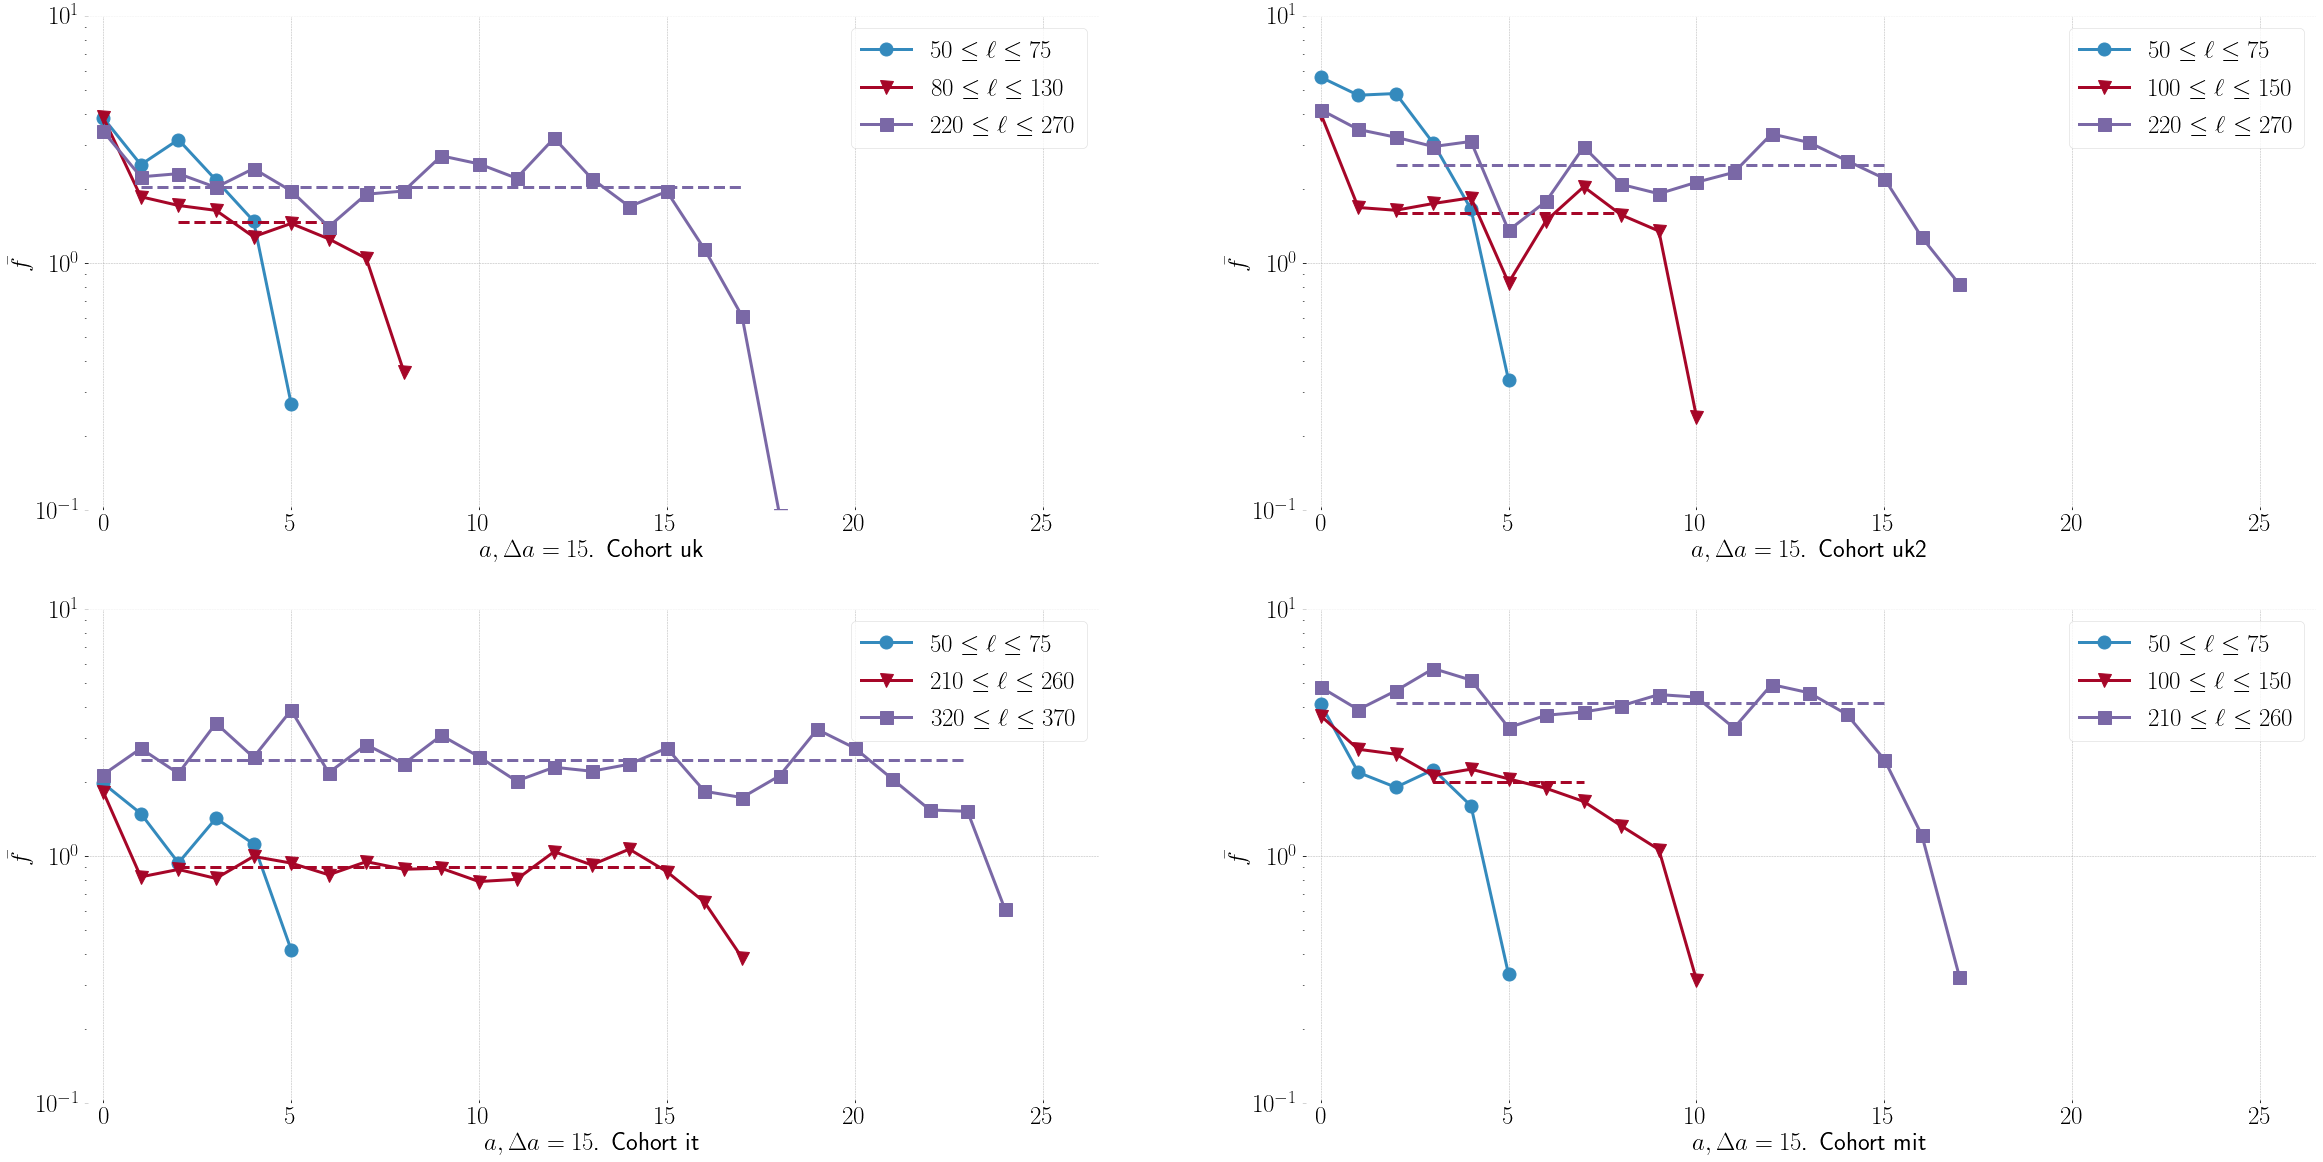

In [7]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [8]:
# for c in fig1.keys():
#     tmp = pd.DataFrame()
#     for l in fig1[c].keys():
#         df = fig1[c][l]['f']
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     #tmp = tmp.loc[tmp.index < 13]
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

## Fig 1b

30 egos randomly chosen

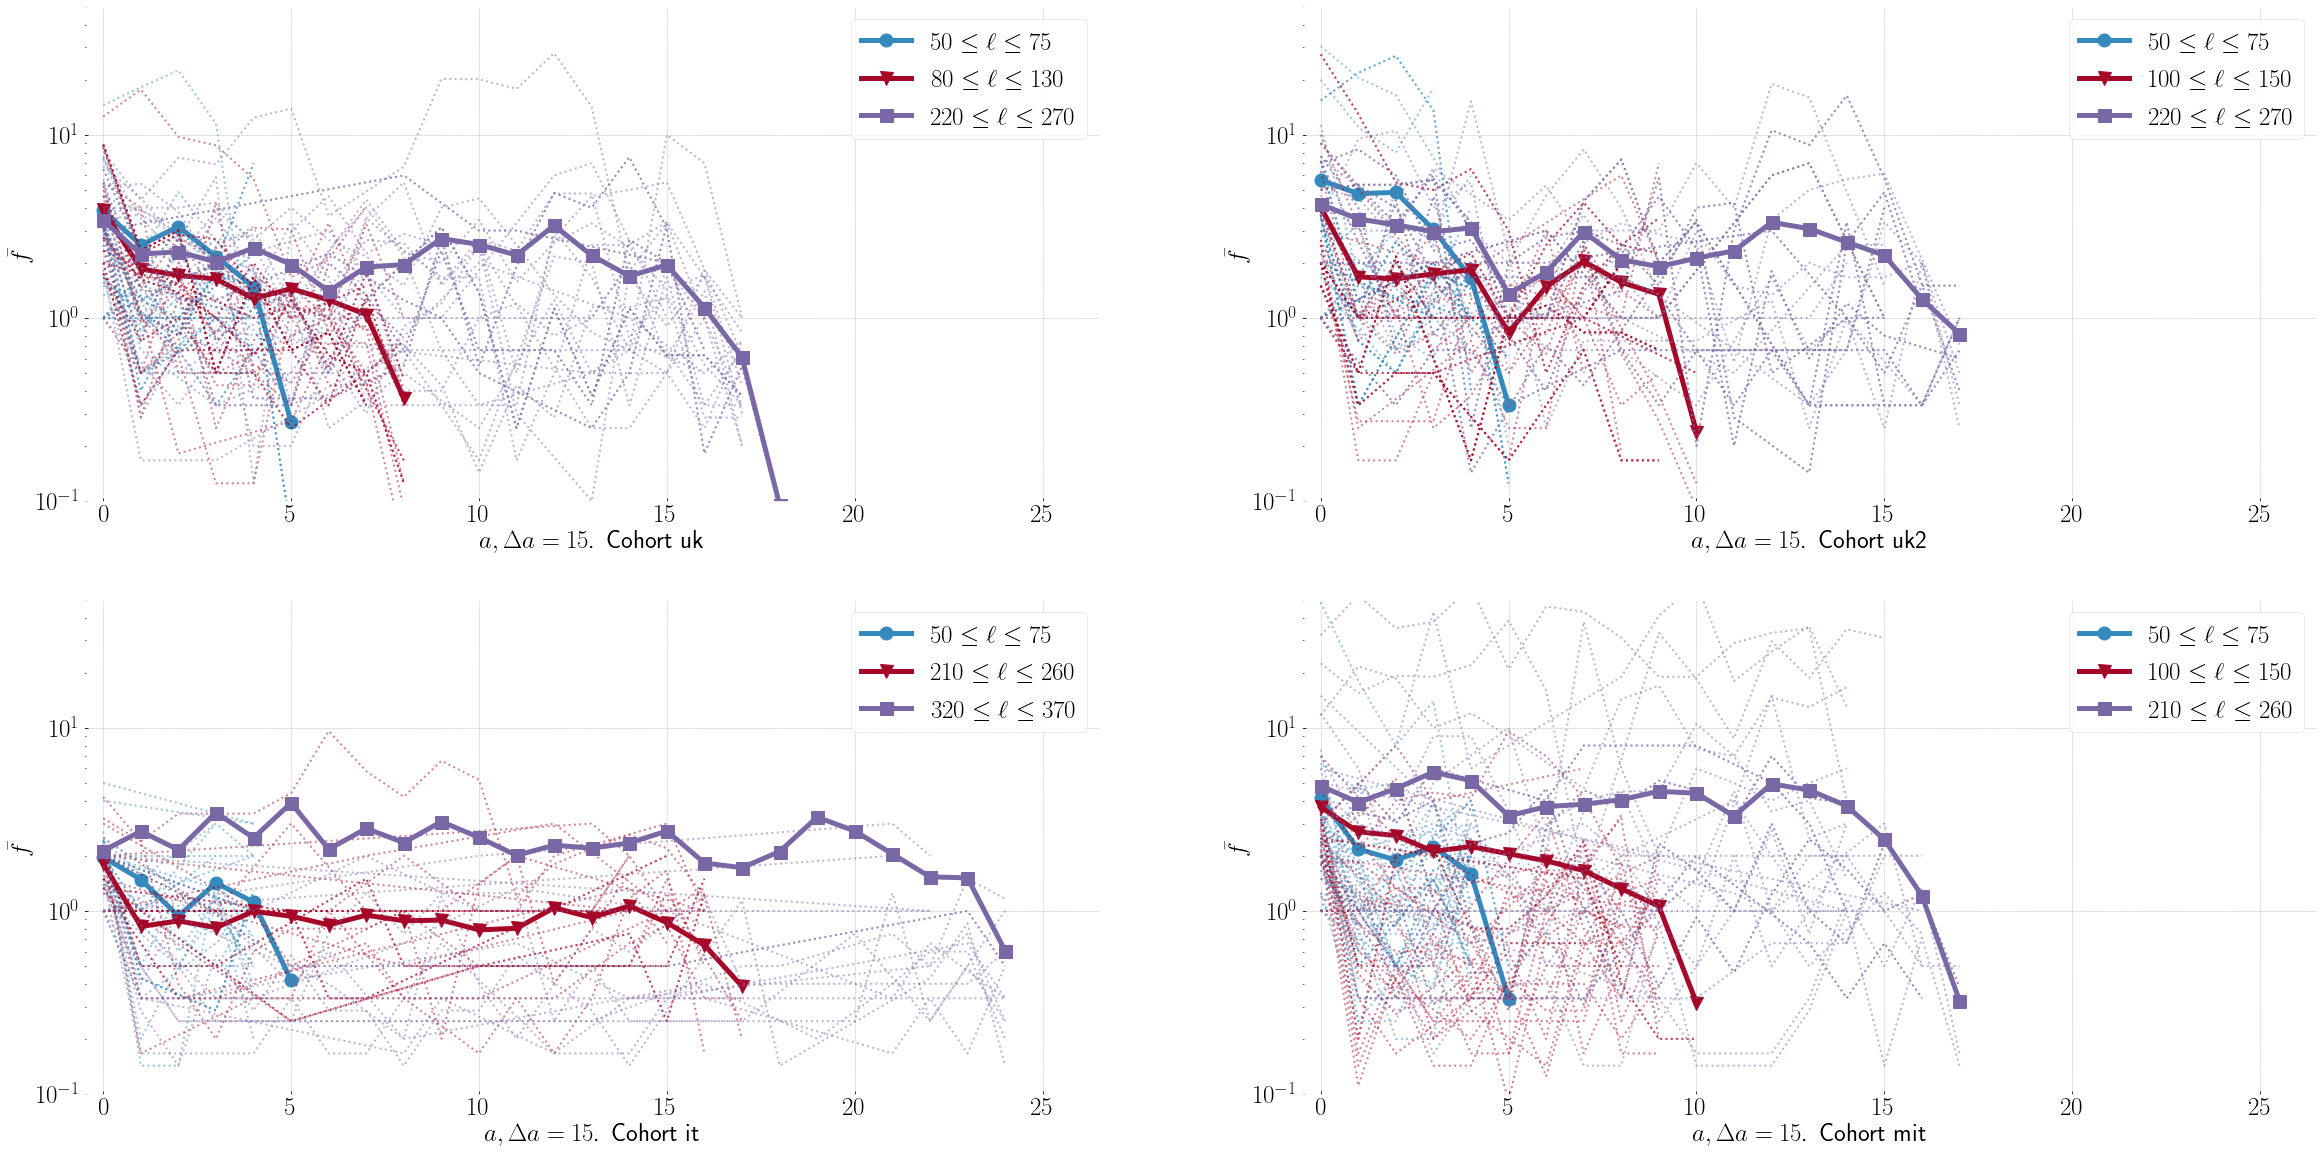

In [9]:
np.random.seed(0)
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=30)
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
    plt.legend()
    p += 1
plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)#, pad_inches=2)

# Fig 3 (survival curves)

In [125]:
dff = {}
dff['all'] = {}
for c in calls.keys():
    dff[c] = pc.get_f(calls[c], 'all', 30, 10)
    dff['all'].update(dff[c])
    
dff['it'] = itdffa30[60]
dff['all'].update(dff['it'])

In [126]:
survival = {}
for c in dff.keys():
    survival[c] = pc.get_survival(dff[c], lambdamax=25)

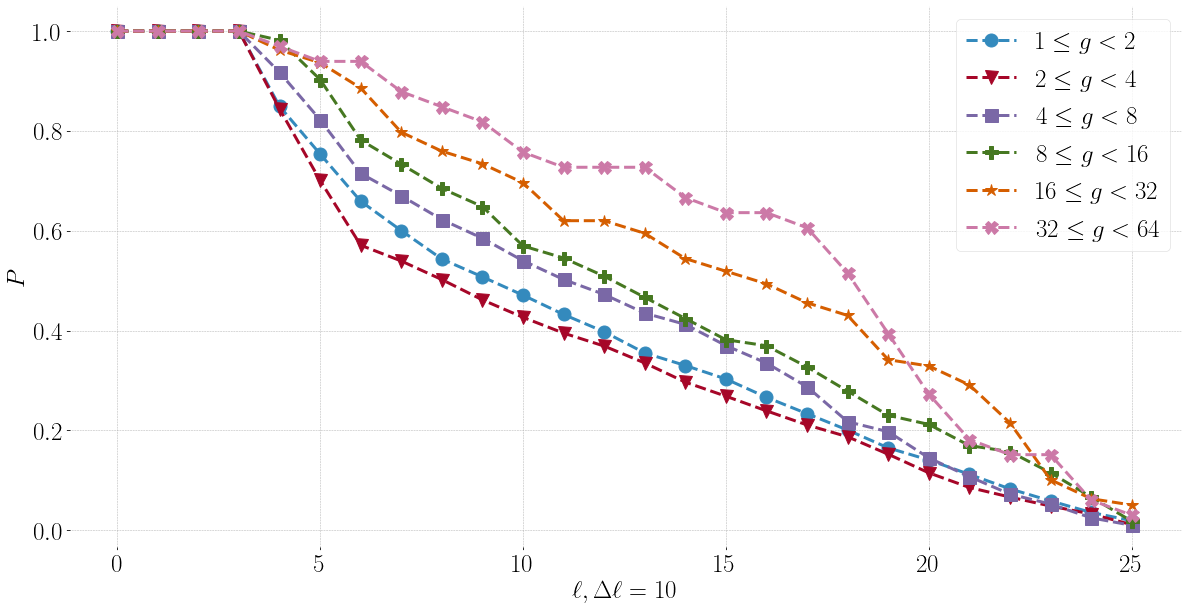

In [12]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

In [13]:
# tmp = pd.DataFrame({'lc': list(survival['all'][0].index)})
# for s in range(6):
#     df = survival['all'][s]
#     tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

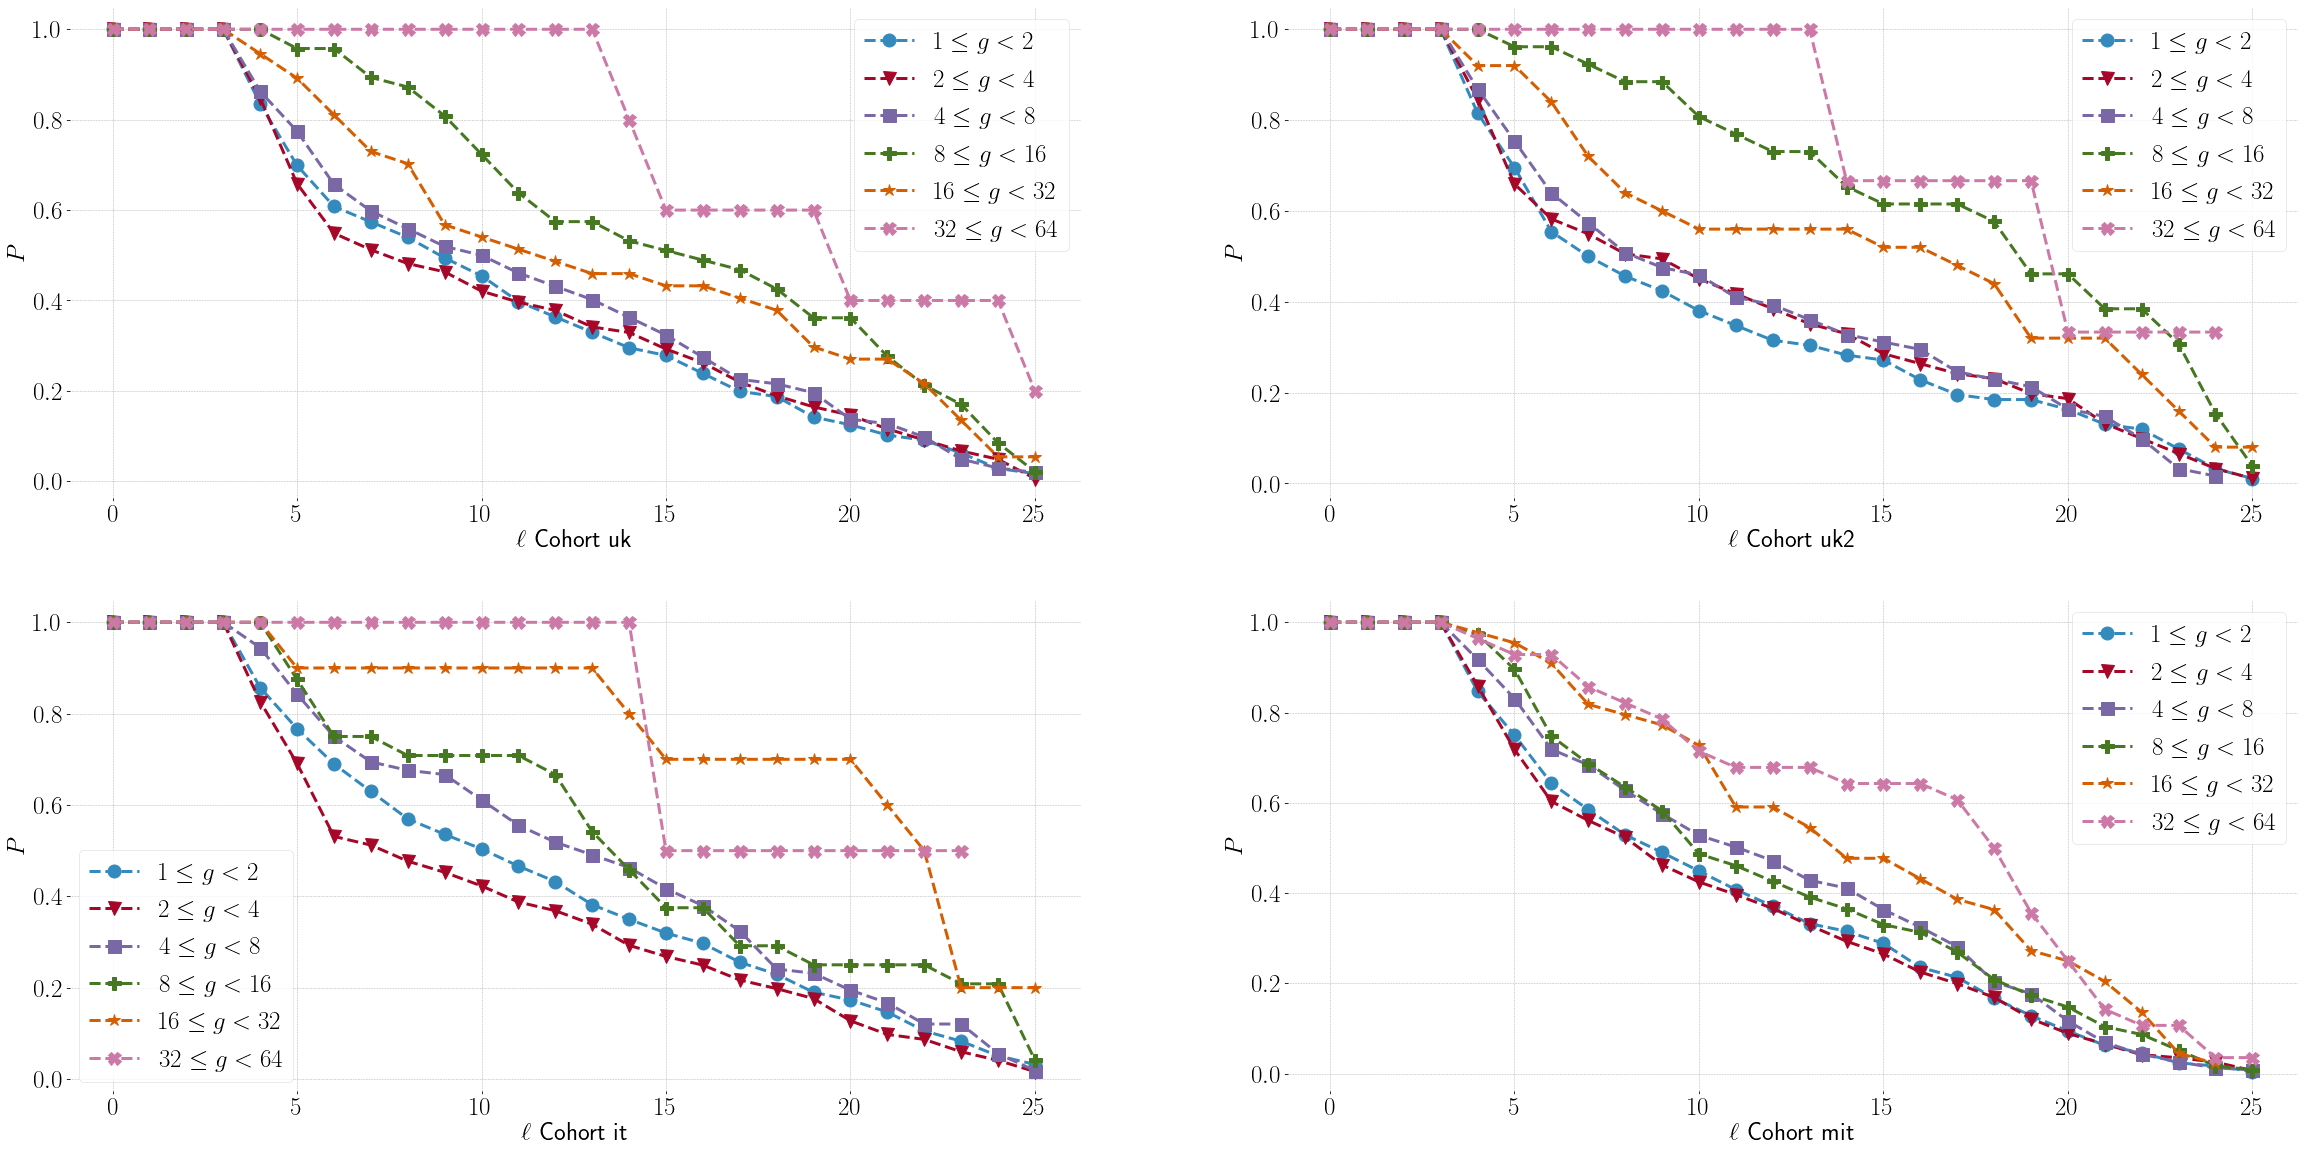

In [14]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(6):
        plt.plot(survival[c][i].index, survival[c][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
    plt.legend()
    p += 1
plt.savefig("../commpatterns/PNAS_paper/SI/figs/SB.pdf", dpi=200)#, pad_inches=2)

# Fig 4 (contours) 

In [15]:
dffUM = {}
for c in ['uk', 'mit']:
    dffUM.update(dff[c])
    
surv_cont = pc.get_survival(dffUM, lambdamax = 25)

In [16]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = surv_cont[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [17]:
points_it = pc.get_survival(dff['it'], unbinned=True, lambdamax=25)

tmp = pd.DataFrame()
for s in points_it.keys():
    if s <= 2**5 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

<center><img src="contours.png" style="width: 50%"/></center>

# Check for ecological fallacy

In [18]:
ksp = {}
for c in ['uk', 'uk2', 'mit']:
    ksp[c] = {}
    for Da in [15, 10, 7, 3]:
        ksp[c][Da] = {}
        series = pc.get_fal(calls[c], limits[c][1][0], limits[c][1][1], Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            idx = sorted(list(df.index))[1:-1]
            if len(idx) > 0:
                mid = len(idx) // 2
                lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
                left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
                right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
                if (len(left) >= 1) and (len(right) >= 1):
                    ksp[c][Da]['m'] = ksp[c][Da].get('m', [])
                    ksp[c][Da]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
        series = pc.get_fal(calls[c], limits[c][2][0], limits[c][2][1], Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            idx = sorted(list(df.index))[1:-1]
            if len(idx) > 0:
                mid = len(idx) // 2
                lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
                left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
                right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
                if (len(left) >= 1) and (len(right) >= 1):
                    ksp[c][Da]['l'] = ksp[c][Da].get('l', [])
                    ksp[c][Da]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

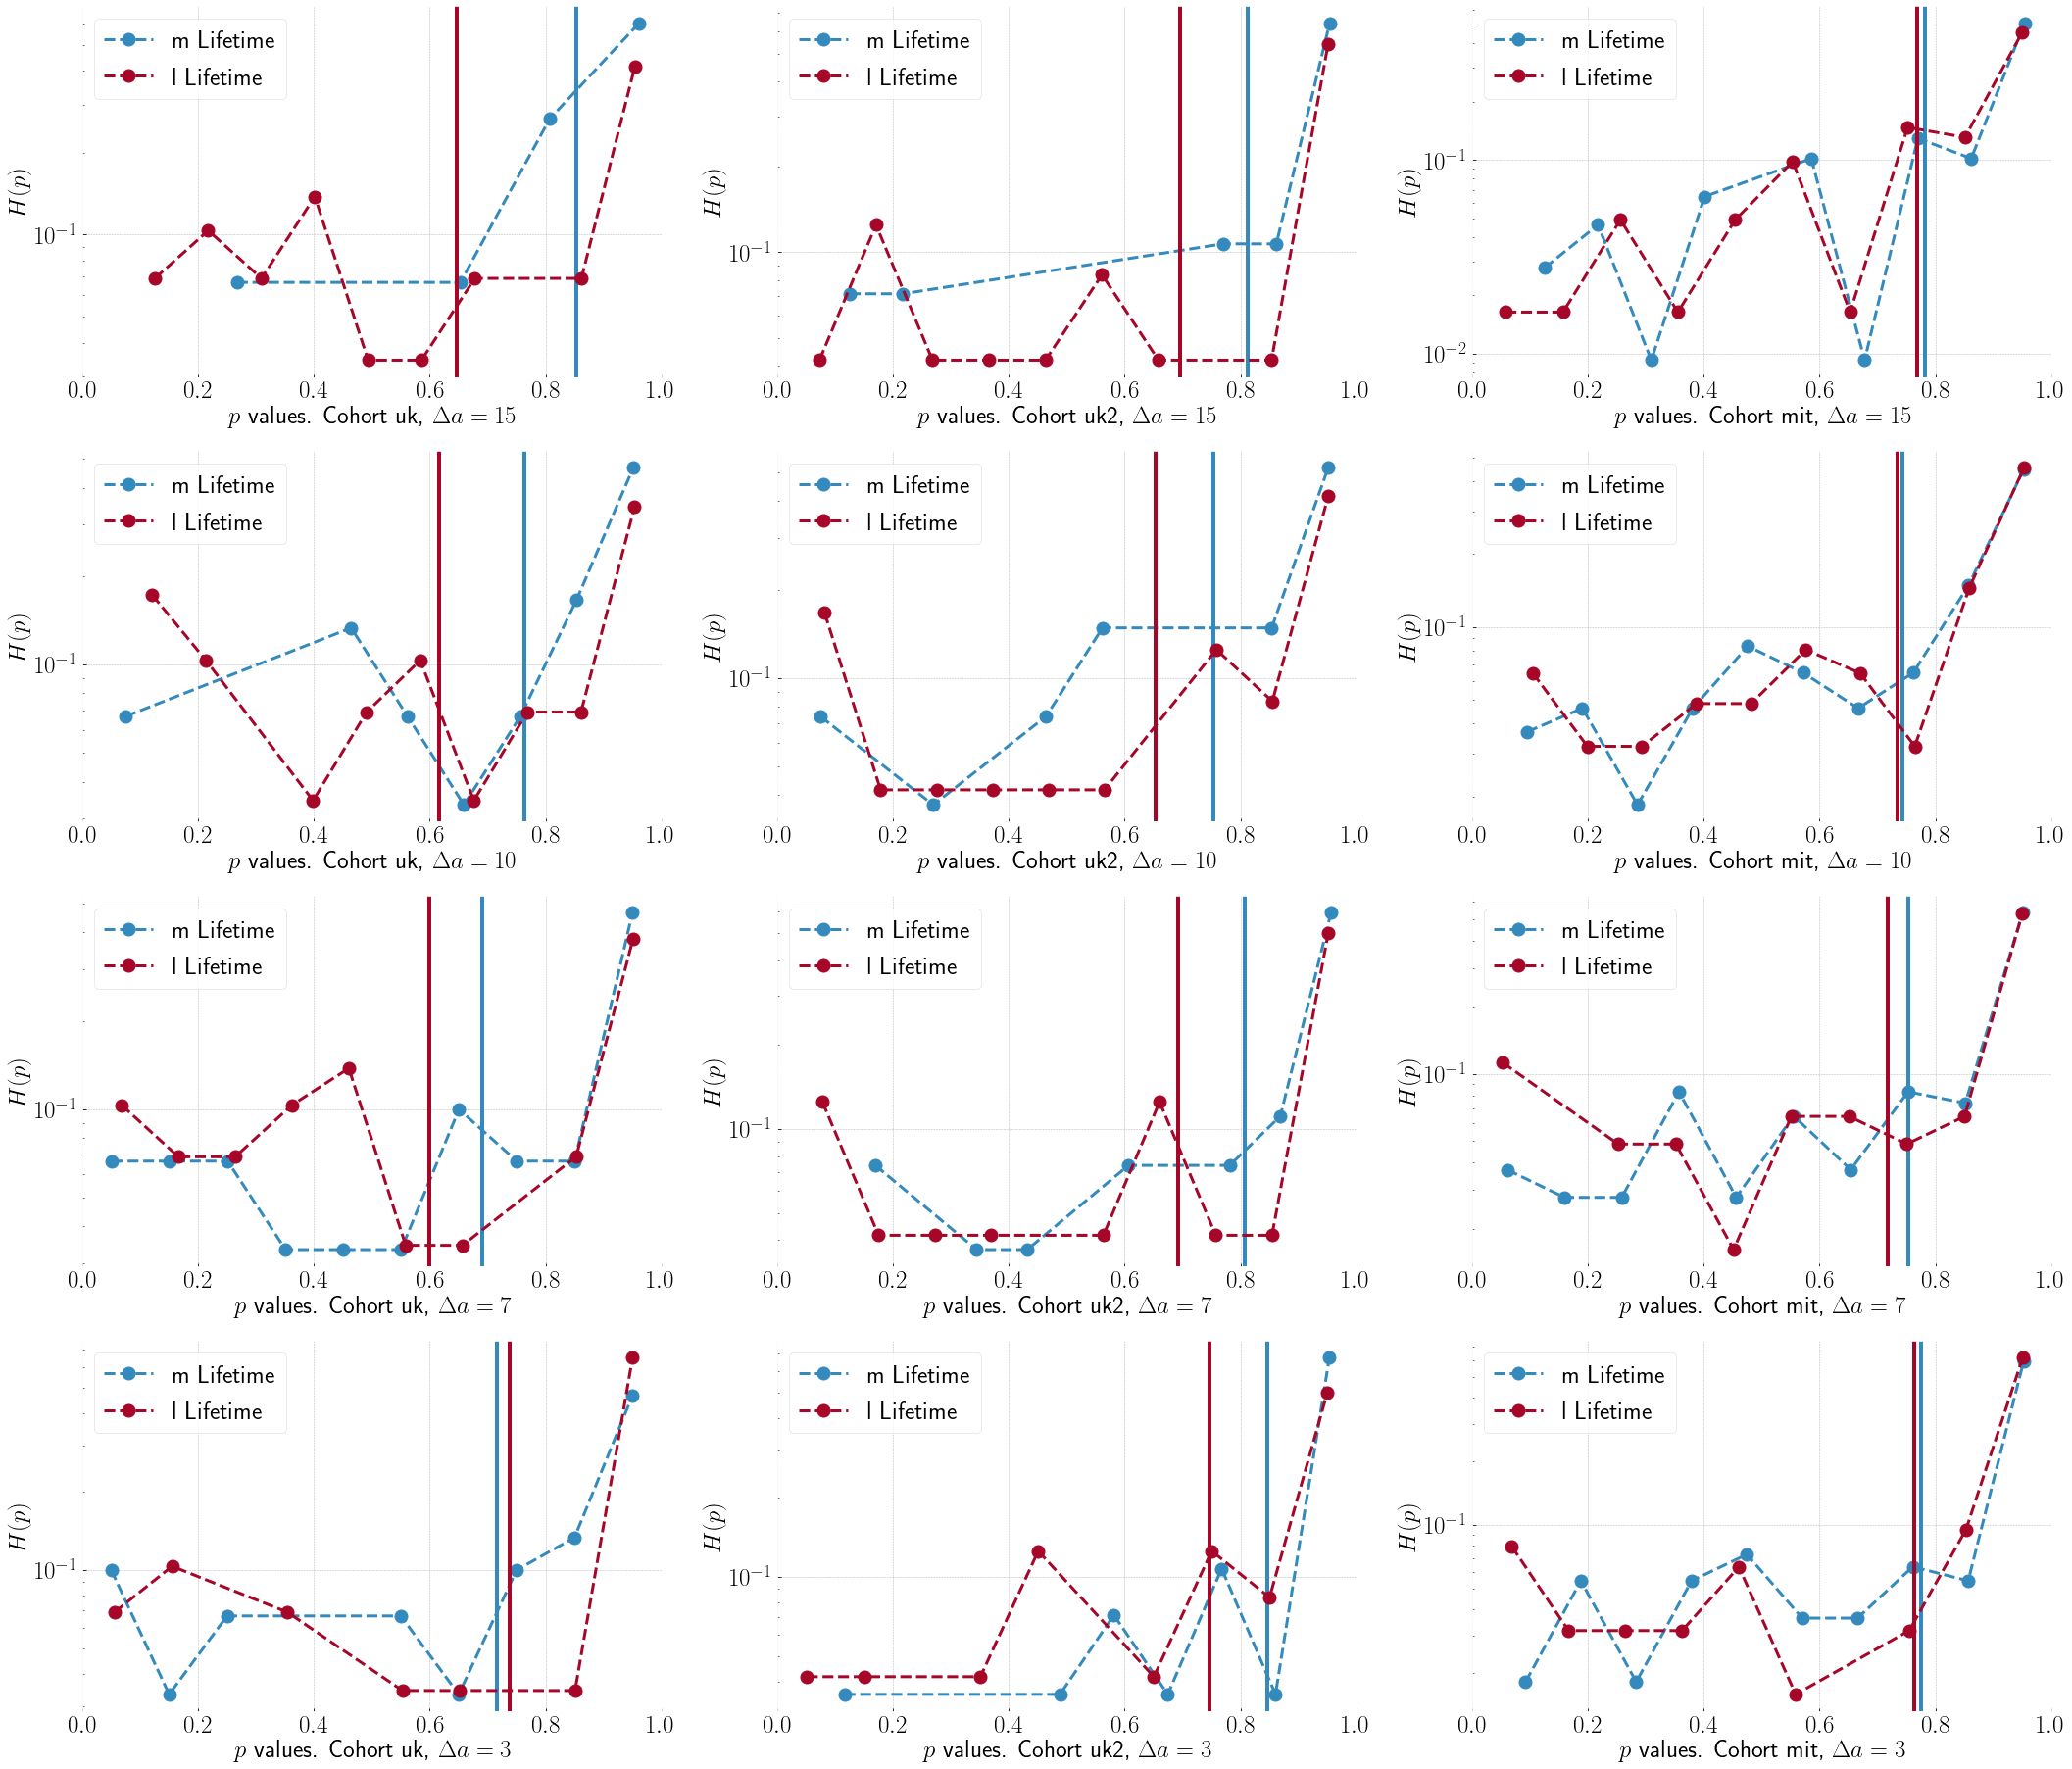

In [19]:
plt.figure(figsize=(12*3, 8*4))
p = 1
for Da in [15, 10, 7, 3]:
    for c in ksp.keys():
        plt.subplot(4, 3, p)
        plt.semilogy()
        plt.xlim(0, 1)
        plt.xlabel(fr"$p$ values. Cohort {c}, $\Delta a = {Da}$")
        plt.ylabel(r'$H(p)$')
        m = 0
        for s in ['m', 'l']:
            H = pc.histogram(ksp[c][Da][s], 10, log=False)
            H['tmp'] = H['label'] * H['h']
            avg = sum(H['tmp']) / sum(H['h'])
            plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
            plt.axvline(avg, ls="solid", lw=4, c=colors[m])
            m += 1
        plt.legend()
        p += 1
#plt.savefig("/home/vsvh/Desktop/A.png", dpi=150, pad_inches=2)

## Using all cohorts and $\Delta a = 15$

In [20]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

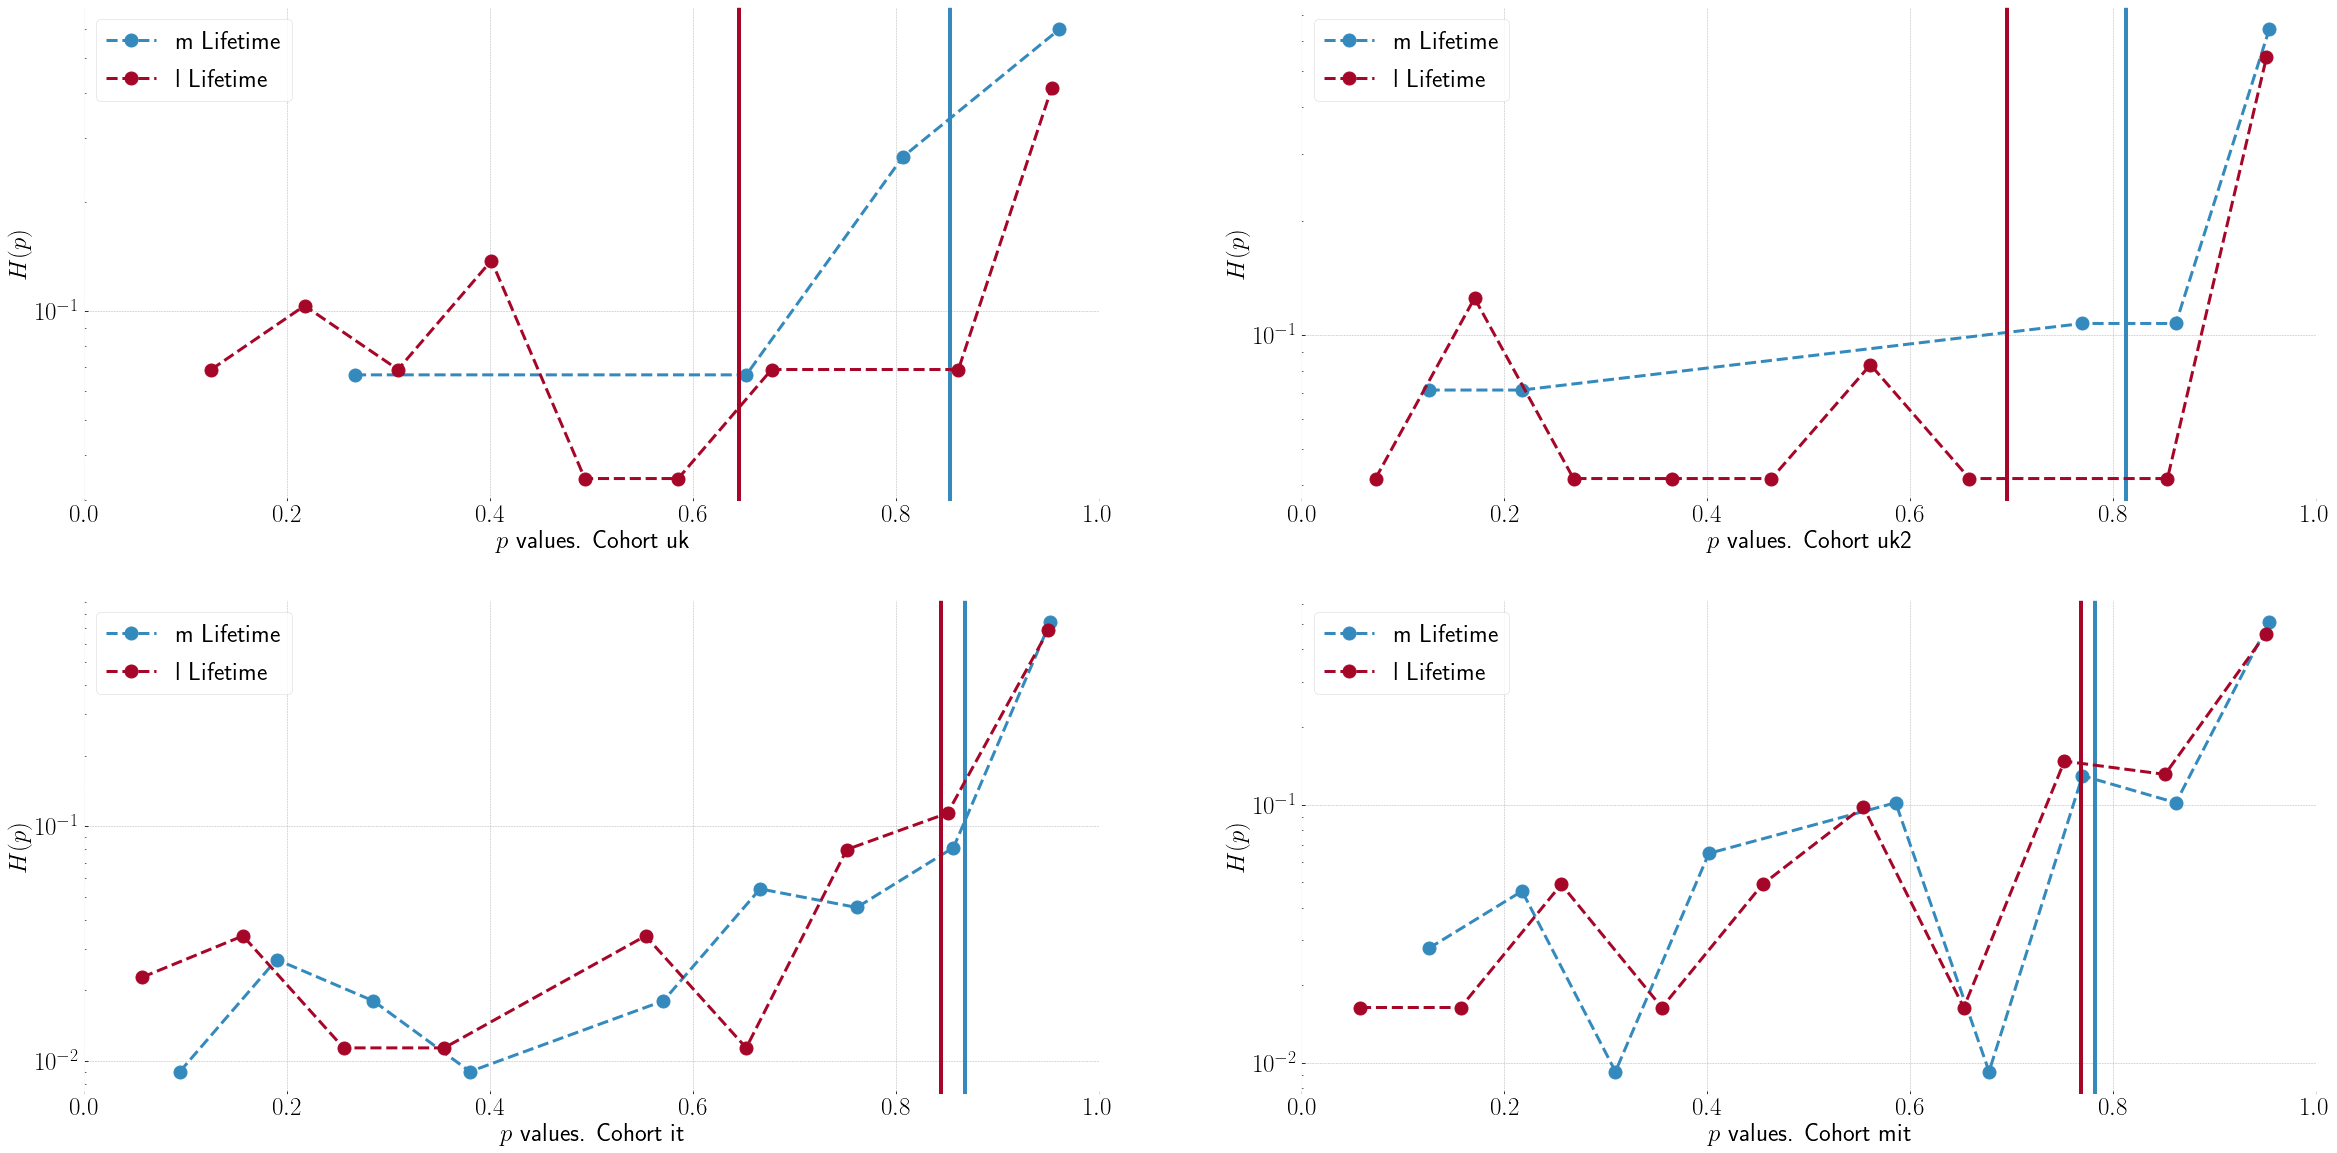

In [21]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ksp.keys():
    plt.subplot(2, 2, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        H['tmp'] = H['label'] * H['h']
        avg = sum(H['tmp']) / sum(H['h'])
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA1.pdf")

In [22]:
for c in ksp.keys():
    for k in ['m', 'l']:
        print(c, k, len(ksp[c][k]))

uk m 30
uk l 29
uk2 m 28
uk2 l 24
it m 111
it l 88
mit m 108
mit l 61


In [23]:
tmp = pd.DataFrame(index=range(111))
lists = []
for c in ksp.keys():
    for k in ['m', 'l']:
        thelist = ksp[c][k]
        lists.append(thelist)
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{k}'] = thelist[i]

([<matplotlib.axis.XTick at 0x7fa17af9a280>,
 [Text(0, 0, 'uk'), Text(1, 0, 'uk2'), Text(2, 0, 'it'), Text(3, 0, 'mit')])

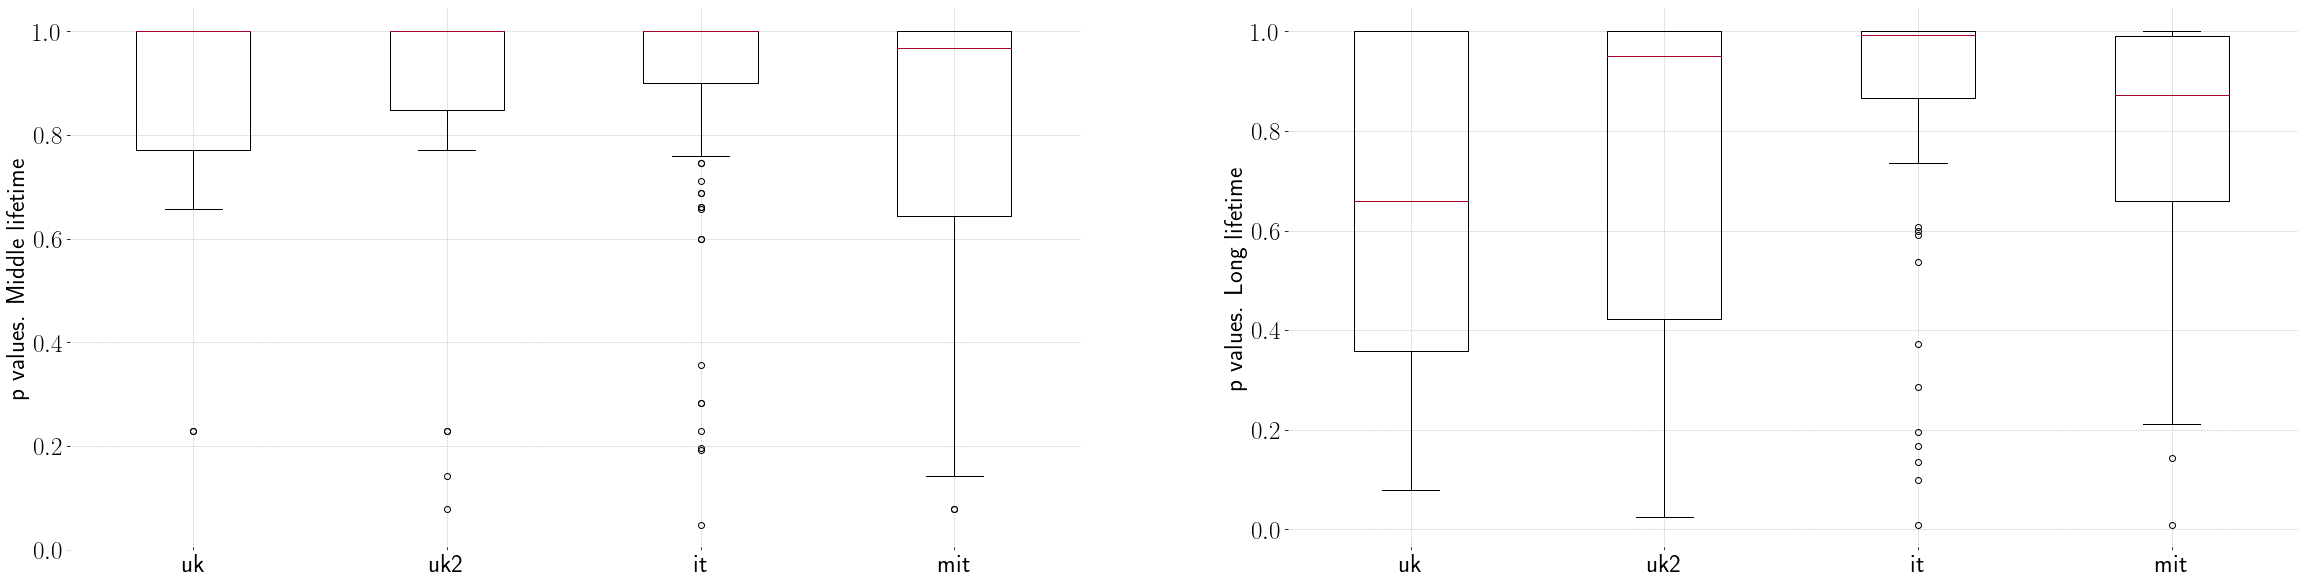

In [24]:
plt.figure(figsize=(40, 10))
plt.subplot(1,2,1)
plt.ylabel('p values. Middle lifetime')
plt.boxplot([lists[i] for i in [0,2,4,6]], positions=range(4))
plt.xticks(list(range(4)), labels=['uk', 'uk2', 'it', 'mit'])

plt.subplot(1,2,2)
plt.ylabel('p values. Long lifetime')
plt.boxplot([lists[i] for i in [1,3,5,7]], positions=range(4))
plt.xticks(range(4), labels=['uk', 'uk2', 'it', 'mit'])

In [25]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2.dat", index=False, header=True, sep="\t")

In [26]:
tmp

ukm       ukl      uk2m      uk2l       itm       itl      mitm  \
0    0.771429  0.460304  1.000000  0.980109  1.000000  1.000000  0.885714   
1    1.000000  1.000000  0.971429  1.000000  0.885714  0.600000  1.000000   
2    1.000000  1.000000  0.771429  0.900000  0.046894  0.957263  1.000000   
3    0.657143  0.962704  1.000000  0.428571  0.999961  0.962704  0.873016   
4    1.000000  0.079365  1.000000  0.962704  1.000000  1.000000  0.600000   
..        ...       ...       ...       ...       ...       ...       ...   
106       NaN       NaN       NaN       NaN  1.000000       NaN  0.657143   
107       NaN       NaN       NaN       NaN  1.000000       NaN  1.000000   
108       NaN       NaN       NaN       NaN  1.000000       NaN       NaN   
109       NaN       NaN       NaN       NaN  0.962704       NaN       NaN   
110       NaN       NaN       NaN       NaN  1.000000       NaN       NaN   

         mitl  
0    0.507692  
1    0.008159  
2    0.372805  
3    0.968254  
4    0.474026  
..        ...  
106       NaN  
107       NaN  
108       NaN  
109       NaN  
110       NaN  

[111 rows x 8 columns]

In [27]:
cols = ['ukm', 'uk2m', 'itm', 'mitm', 'ukl', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    std = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'std'] = std
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
# a.to_csv("../commpatterns/PNAS_paper/figs/fig2bm.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/figs/fig2bl.dat", index=True, header=True, sep="\t")

In [28]:
tmp3 = pd.DataFrame()
idx = 0
for i in tmp2.index:
    col = tmp2.at[i, 'c']
    pvals = tmp[col].dropna()
    for p in [0.1, 0.05, 0.01]:
        notsim = [x for x in pvals if x <= p]
        tmp3.at[idx, 'pos'] = tmp2.at[i, 'pos']
        tmp3.at[idx, 'c'] = col
        tmp3.at[idx, 'thres'] = p
        tmp3.at[idx, 'prop'] = len(notsim) / len(pvals)
        idx += 1
tmp3

pos     c  thres      prop
0    0.0   ukm   0.10  0.000000
1    0.0   ukm   0.05  0.000000
2    0.0   ukm   0.01  0.000000
3    3.0  uk2m   0.10  0.035714
4    3.0  uk2m   0.05  0.000000
5    3.0  uk2m   0.01  0.000000
6    6.0   itm   0.10  0.009009
7    6.0   itm   0.05  0.009009
8    6.0   itm   0.01  0.000000
9    9.0  mitm   0.10  0.018519
10   9.0  mitm   0.05  0.000000
11   9.0  mitm   0.01  0.000000
12   1.0   ukl   0.10  0.034483
13   1.0   ukl   0.05  0.000000
14   1.0   ukl   0.01  0.000000
15   4.0  uk2l   0.10  0.041667
16   4.0  uk2l   0.05  0.041667
17   4.0  uk2l   0.01  0.000000
18   7.0   itl   0.10  0.022727
19   7.0   itl   0.05  0.011364
20   7.0   itl   0.01  0.011364
21  10.0  mitl   0.10  0.016393
22  10.0  mitl   0.05  0.016393
23  10.0  mitl   0.01  0.016393

In [29]:
tmp3.loc[(tmp3['thres'] == 0.1) & (tmp3['pos'].isin([0, 3, 6, 9]))]

pos     c  thres      prop
0  0.0   ukm    0.1  0.000000
3  3.0  uk2m    0.1  0.035714
6  6.0   itm    0.1  0.009009
9  9.0  mitm    0.1  0.018519

In [30]:
marks = {0.1: 'square*', 0.05: 'triangle*', 0.01: 'diamond*'}
for t in marks.keys():
    df = tmp3.loc[(tmp3['thres'] == t) & (tmp3['pos'].isin([0, 3, 6, 9]))]
    x = list(df['pos'])
    props = list(df['prop'])
    print(f'\\addplot[only marks, squirtle, mark={marks[t]}, mark size=4] coordinates {{({x[0]}, {props[0]}) ({x[1]}, {props[1]}) ({x[2]}, {props[2]}) ({x[3]}, {props[3]})}};')
    df = tmp3.loc[(tmp3['thres'] == t) & (tmp3['pos'].isin([1, 4, 7, 10]))]
    x = list(df['pos'])
    props = list(df['prop'])
    print(f'\\addplot[only marks, ekans, mark={marks[t]}, mark size=4] coordinates {{({x[0]}, {props[0]}) ({x[1]}, {props[1]}) ({x[2]}, {props[2]}) ({x[3]}, {props[3]})}};')

\addplot[only marks, squirtle, mark=square*, mark size=4] coordinates {(0.0, 0.0) (3.0, 0.03571428571428571) (6.0, 0.009009009009009009) (9.0, 0.018518518518518517)};
\addplot[only marks, ekans, mark=square*, mark size=4] coordinates {(1.0, 0.034482758620689655) (4.0, 0.041666666666666664) (7.0, 0.022727272727272728) (10.0, 0.01639344262295082)};
\addplot[only marks, squirtle, mark=triangle*, mark size=4] coordinates {(0.0, 0.0) (3.0, 0.0) (6.0, 0.009009009009009009) (9.0, 0.0)};
\addplot[only marks, ekans, mark=triangle*, mark size=4] coordinates {(1.0, 0.0) (4.0, 0.041666666666666664) (7.0, 0.011363636363636364) (10.0, 0.01639344262295082)};
\addplot[only marks, squirtle, mark=diamond*, mark size=4] coordinates {(0.0, 0.0) (3.0, 0.0) (6.0, 0.0) (9.0, 0.0)};
\addplot[only marks, ekans, mark=diamond*, mark size=4] coordinates {(1.0, 0.0) (4.0, 0.0) (7.0, 0.011363636363636364) (10.0, 0.01639344262295082)};


In [31]:
# a = tmp3.loc[tmp3['thres'] == 0.1][['pos', 'prop']]
# a.to_csv("../commpatterns/PNAS_paper/figs/fig2prop01.dat", index=False, header=True, sep="\t")

# b = tmp3.loc[tmp3['thres'] == 0.05][['pos', 'prop']]
# b.to_csv("../commpatterns/PNAS_paper/figs/fig2prop005.dat", index=False, header=True, sep="\t")

# c = tmp3.loc[tmp3['thres'] == 0.01][['pos', 'prop']]
# c.to_csv("../commpatterns/PNAS_paper/figs/fig2prop001.dat", index=False, header=True, sep="\t")

# Explore relationship between $\ell$ and $b$

In [32]:
test = fig1['it'][2]['f']

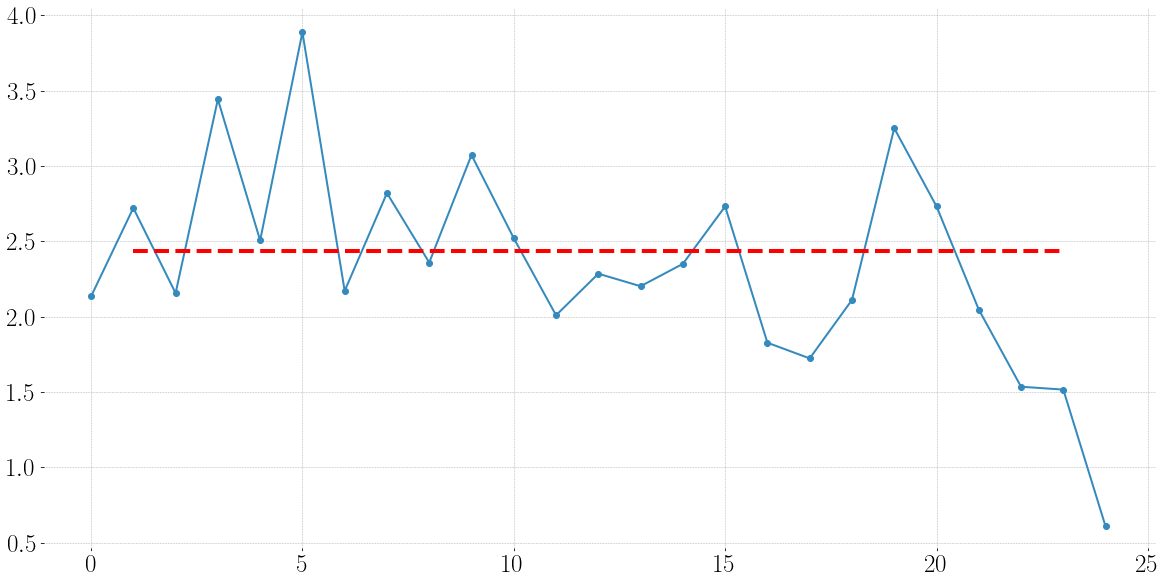

In [33]:
plt.plot(test.index, test['f'], "o-")
points = pc.get_plateau(test, pstar=0.01)
plt.plot([x[0] for x in points], [y[1] for y in points], marker="", ls="dashed", lw=4, c="red")

In [34]:
for i in range(max(test.index) // 2):
    df = test.loc[(test.index >= (0 + i)) & (test.index <= (max(test.index) - i))]
    X = sm.add_constant(df.index)
    Y = df['f']
    tmp = sm.OLS(Y, X).fit()
    print(f'{i}: \t slope {tmp.params[1]:.4f} \t p-value {tmp.pvalues[1]:.4f} \t R-squared {tmp.rsquared:.3f}')

0: 	 slope -0.0478 	 p-value 0.0080 	 R-squared 0.268
1: 	 slope -0.0433 	 p-value 0.0169 	 R-squared 0.243
2: 	 slope -0.0397 	 p-value 0.0580 	 R-squared 0.176
3: 	 slope -0.0427 	 p-value 0.0718 	 R-squared 0.178
4: 	 slope -0.0289 	 p-value 0.2990 	 R-squared 0.072
5: 	 slope -0.0486 	 p-value 0.1686 	 R-squared 0.141
6: 	 slope -0.0503 	 p-value 0.0786 	 R-squared 0.255
7: 	 slope -0.0799 	 p-value 0.0349 	 R-squared 0.406
8: 	 slope -0.0550 	 p-value 0.2800 	 R-squared 0.164
9: 	 slope -0.0419 	 p-value 0.5840 	 R-squared 0.064
10: 	 slope -0.0148 	 p-value 0.8427 	 R-squared 0.015
11: 	 slope 0.0964 	 p-value 0.5230 	 R-squared 0.464


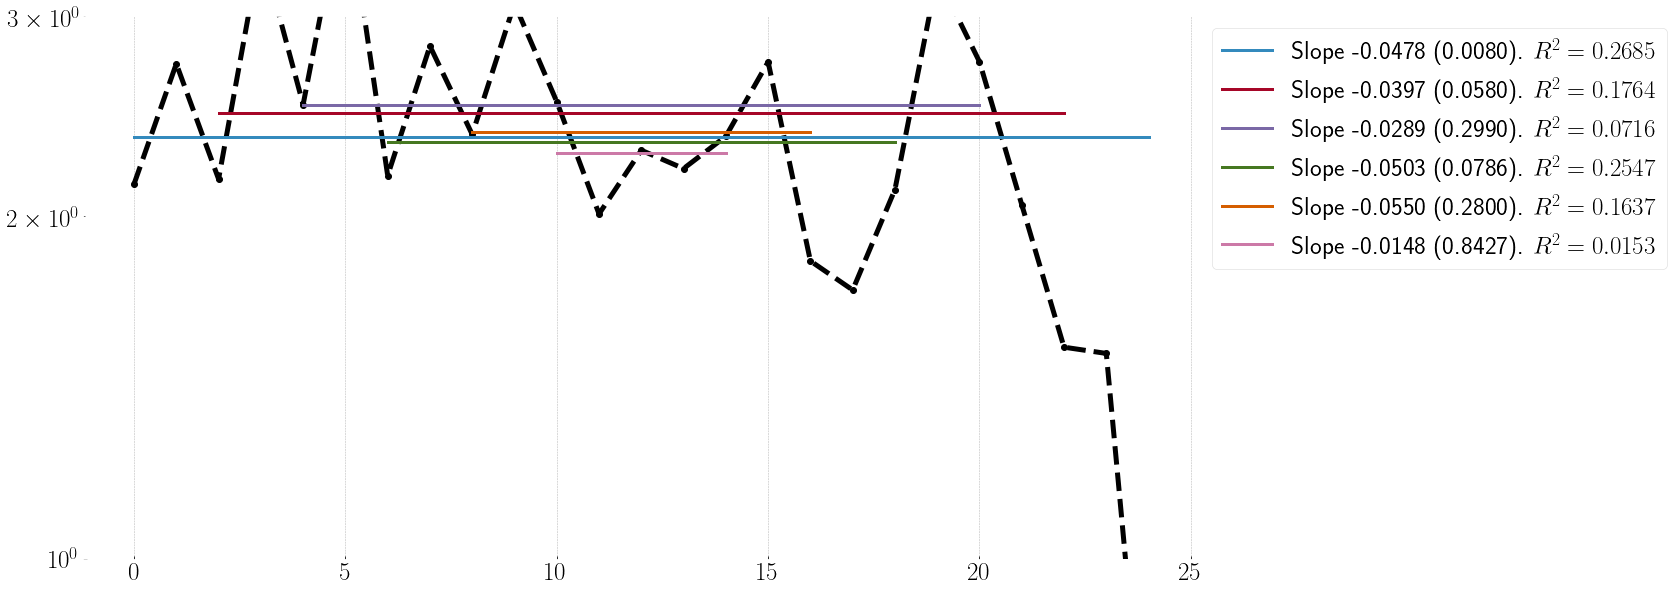

In [35]:
plt.figsize=(30, 15)
plt.plot(test.index, test['f'], c="black", marker="o", ls="dashed", lw=5)
plt.semilogy()
plt.ylim(1, 3)
for i in range(0, max(test.index) // 2, 2):
    df = test.loc[(test.index >= (0 + i)) & (test.index <= (max(test.index) - i))]
    X = sm.add_constant(df.index)
    Y = df['f']
    tmp = sm.OLS(Y, X).fit()
    xpoints, ypoints = [min(df.index), max(df.index)], [np.mean(Y), np.mean(Y)]
    plt.plot(xpoints, ypoints, ls="solid", lw=3, marker="", label=fr'Slope {tmp.params[1]:.4f} ({tmp.pvalues[1]:.4f}). $R^2 = {tmp.rsquared:.4f}$')
plt.legend(bbox_to_anchor=(1, 1))

In [36]:
# !pip install pymannkendall
import pymannkendall as mk

In [37]:
for i in range(max(test.index) // 2):
    df = test.loc[(test.index >= (0 + i)) & (test.index <= (max(test.index) - i))]
    print(mk.original_test(df))

Mann_Kendall_Test(trend='decreasing', h=True, p=0.014195743882660095, z=-2.4522716741087978, Tau=-0.35333333333333333, s=-106.0, var_s=1833.3333333333333, slope=-0.04282761125623934, intercept=2.799077868435691)
Mann_Kendall_Test(trend='decreasing', h=True, p=0.01745687657638273, z=-2.3769410746493627, Tau=-0.35968379446640314, s=-91.0, var_s=1433.6666666666667, slope=-0.04257721376076862, intercept=2.8188753757316882)
Mann_Kendall_Test(trend='no trend', h=False, p=0.06547335845953506, z=-1.842012247120261, Tau=-0.29523809523809524, s=-62.0, var_s=1096.6666666666667, slope=-0.03716771624801081, intercept=2.7222031868433416)
Mann_Kendall_Test(trend='no trend', h=False, p=0.08024287819033638, z=-1.749278571353299, Tau=-0.2982456140350877, s=-51.0, var_s=817.0, slope=-0.040765337356246475, intercept=2.726087170405352)
Mann_Kendall_Test(trend='no trend', h=False, p=0.3434194871827416, z=-0.9474304377573798, Tau=-0.17647058823529413, s=-24.0, var_s=589.3333333333334, slope=-0.03119678015199

In [38]:
a = mk.original_test(test)
a[0]

'decreasing'

## Two functions to obtain $b$

In [39]:
def get_b_olstocenter(series, pstar=0.1):
    for i in range(max(series.index) // 2):
        df = series.loc[(series.index >= (0 + i)) & (series.index <= (max(series.index) - i))]
        X = sm.add_constant(series.index)
        Y = series['f']
        tmp = sm.OLS(Y, X).fit()
        if tmp.pvalues[1] > pstar:
            df = series.loc[(series.index >= (0 + i - 1)) & (series.index <= (max(series.index) - i + 1))]
            xo = min(df.index)
            xf = max(df.index)
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
    else:
        df = series.loc[(series.index >= (0 + 1)) & (series.index <= (max(series.index) - 1))]
        xo = min(df.index)
        xf = max(df.index)
        yo = np.mean(df['f'])
        yf = yo
        return [[xo, xf], [yo, yf]]

In [40]:
def get_b_slopes(series, patternsize=3):
    allslopes = []
    X = list(series.index)
    N = len(X)
    xo, xf = X[0], X[-1]
    yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
    slope = (yf - yo) / (xf - xo)
    allslopes.append(slope)
    for i in range(1, N):
        newx = X[i // 2: N - ((i + 1) // 2)]
        if len(newx) > 1:
            xo, xf = newx[0], newx[-1]
            yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
            slope = (yf - yo) / (xf - xo)
            allslopes.append(slope)
        else:
            xo, xf = X[1], X[-2]
            df = series.loc[(series.index >= xo) & (series.index <= xf)]
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
        if (len(allslopes) >= patternsize):
            checkSlopes = list(np.sign(allslopes[-patternsize:]))
            if checkSlopes.count(checkSlopes[0]) != len(checkSlopes):
                df = series.loc[(series.index >= xo) & (series.index <= xf)]
                yo = np.mean(df['f'])
                yf = yo
                return [[xo, xf], [yo, yf]]        

In [41]:
def get_b_mk(series):
    for i in range(max(series.index) // 2):
        df = series.loc[(series.index >= (0 + i)) & (series.index <= (max(series.index) - i))]
        tmp = mk.original_test(df['f'])
        if tmp[0] == 'no trend':
            df = series.loc[(series.index >= (0 + i - 1)) & (series.index <= (max(series.index) - i + 1))]
            xo = min(df.index)
            xf = max(df.index)
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
    else:
        df = series.loc[(series.index >= (0 + 1)) & (series.index <= (max(series.index) - 1))]
        xo = min(df.index)
        xf = max(df.index)
        yo = np.mean(df['f'])
        yf = yo
        return [[xo, xf], [yo, yf]]

In [42]:
calls['uk1'] = pc.apply_filters(unfiltered['uk1'], 60)

## Testing the functions

In [43]:
maxa = {}
for c in calls.keys():
    maxa[c] = max(calls[c]['aclock'])
maxit = 0
for ego in itlives[60].keys():
    for alter in itlives[60][ego].keys():
        if itlives[60][ego][alter]['ell'] > maxit:
            maxit = itlives[60][ego][alter]['ell']
maxa['it'] = maxit
maxa

{'uk': 482, 'uk2': 291, 'mit': 442, 'uk1': 481, 'it': 633}

In [44]:
t0 = dt.datetime.now()
tests = ['olsToEnds', 'olsToCenter', 'mk', 'slopes']
functs = [pc.get_plateau, get_b_olstocenter, get_b_mk, get_b_slopes]
fa = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    fa[c] = {}
    for t in tests:
        fa[c][t] = {}
    for ell in range(maxa[c]):
        if c == 'it':
            curve  = {'f': pc.get_avgfa(itdffa15[60], itlives[60], ell, ell + 50)}
        else:
            curve = pc.get_fal(calls[c], ell, ell + 50, 15)
        if len(curve['f']) > 3:
            for ft in range(len(tests)):
                points = functs[ft](curve['f'])
                fa[c][tests[ft]][ell] = points[1][1]
    for t in fa[c].keys():
        fa[c][t] = pd.DataFrame.from_dict(fa[c][t], orient='index').sort_index()
print(f'Took {dt.datetime.now() - t0}')

Took 0:03:33.684487


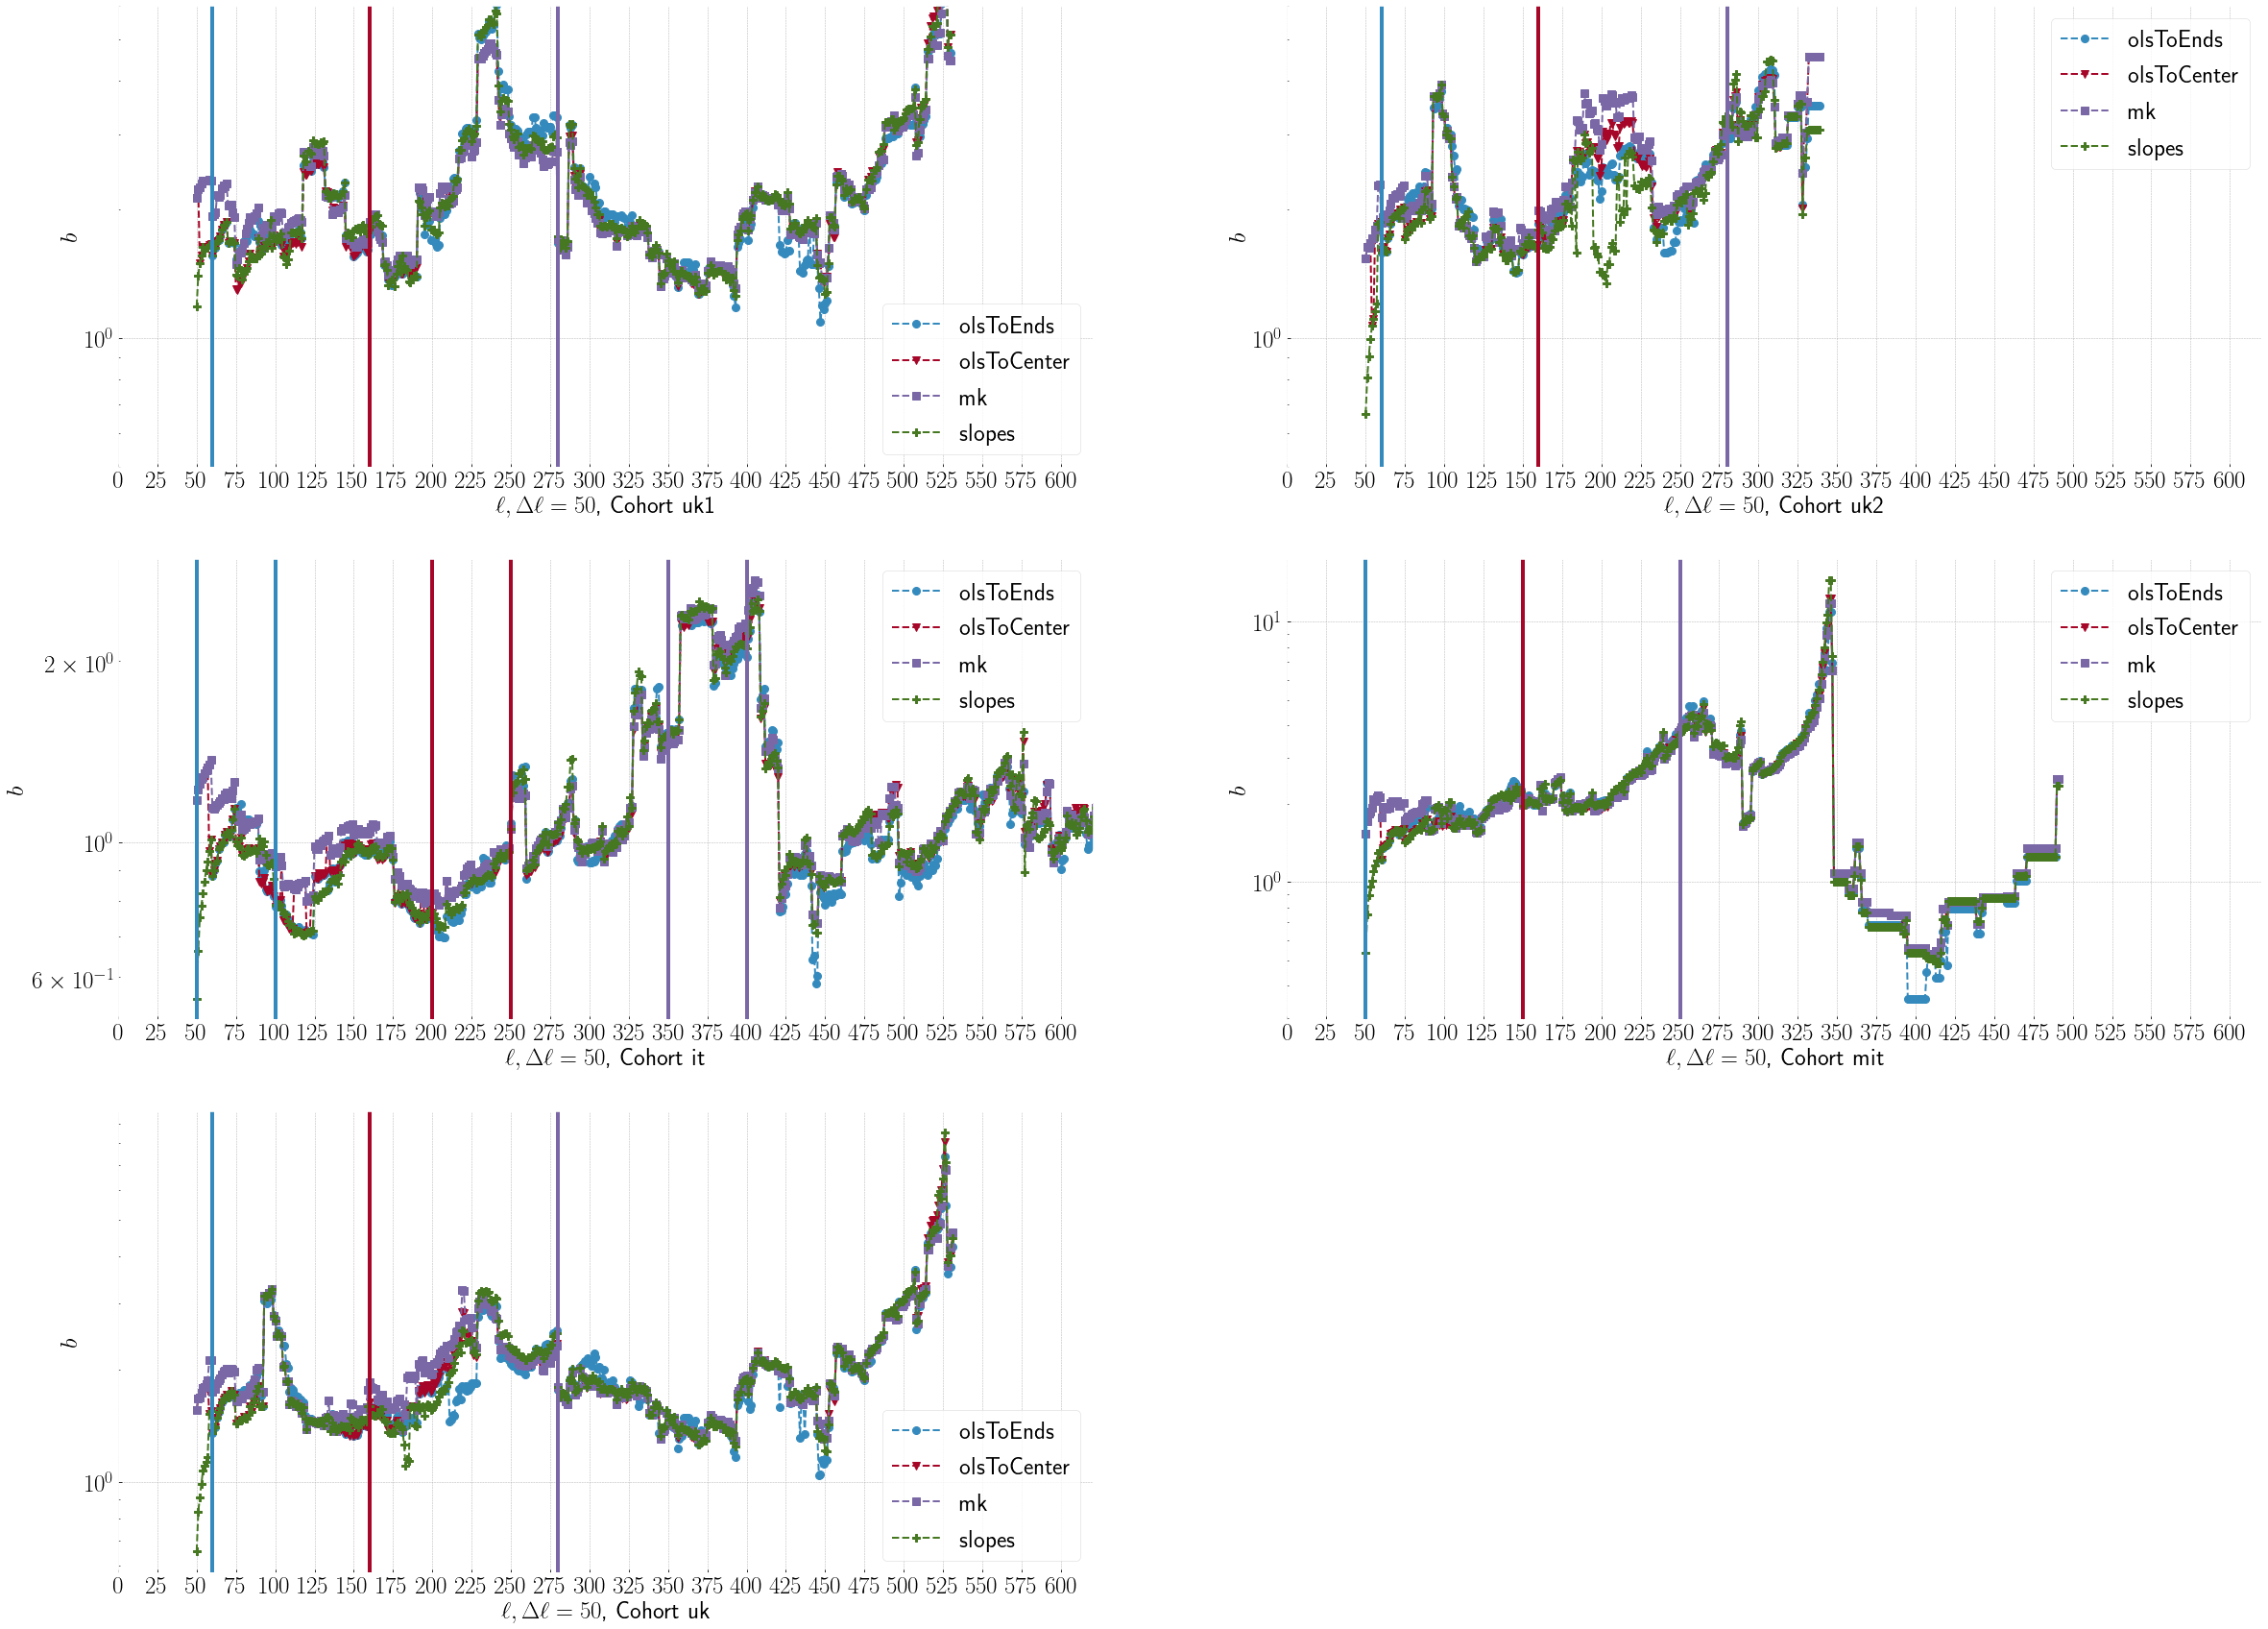

In [45]:
plt.figure(figsize=(20*2, 10*3))
p = 1
for c in ['uk1', 'uk2', 'it', 'mit', 'uk']:
    plt.subplot(3, 2, p)
    plt.xlabel(fr'$\ell, \Delta \ell = 50$, Cohort {c}')
    plt.ylabel(r'$b$')
    plt.xlim(0, 620)
    if p <= 2:
        plt.ylim(0.5, 6)
    plt.xticks(range(0, 620, 25))
    plt.semilogy()
    m = 0
    for t in fa[c].keys():
        plt.plot([x + 50 for x in fa[c][t].index], fa[c][t][0], marker=markers[m], markersize=8, ls="dashed", lw=2, label=t)
        m += 1
    if c == 'mit':
        plt.axvline(50, ls="solid", lw=4, c=colors[0])
        plt.axvline(150, ls="solid", lw=4, c=colors[1])
        plt.axvline(250, ls="solid", lw=4, c=colors[2])
    elif c == 'it':
        plt.axvline(50, ls="solid", lw=4, c=colors[0])
        plt.axvline(100, ls="solid", lw=4, c=colors[0])
        plt.axvline(200, ls="solid", lw=4, c=colors[1])
        plt.axvline(250, ls="solid", lw=4, c=colors[1])
        plt.axvline(350, ls="solid", lw=4, c=colors[2])
        plt.axvline(400, ls="solid", lw=4, c=colors[2])
    else:
        plt.axvline(60, ls="solid", lw=4, c=colors[0])
        plt.axvline(160, ls="solid", lw=4, c=colors[1])
        plt.axvline(280, ls="solid", lw=4, c=colors[2])
    plt.legend()
    p += 1

## Separate methods and calculate moving average

In [46]:
for c in fa.keys():
    for t in fa[c].keys():
        df = fa[c][t]
        df['ma50'] = df.rolling(window=50).mean()

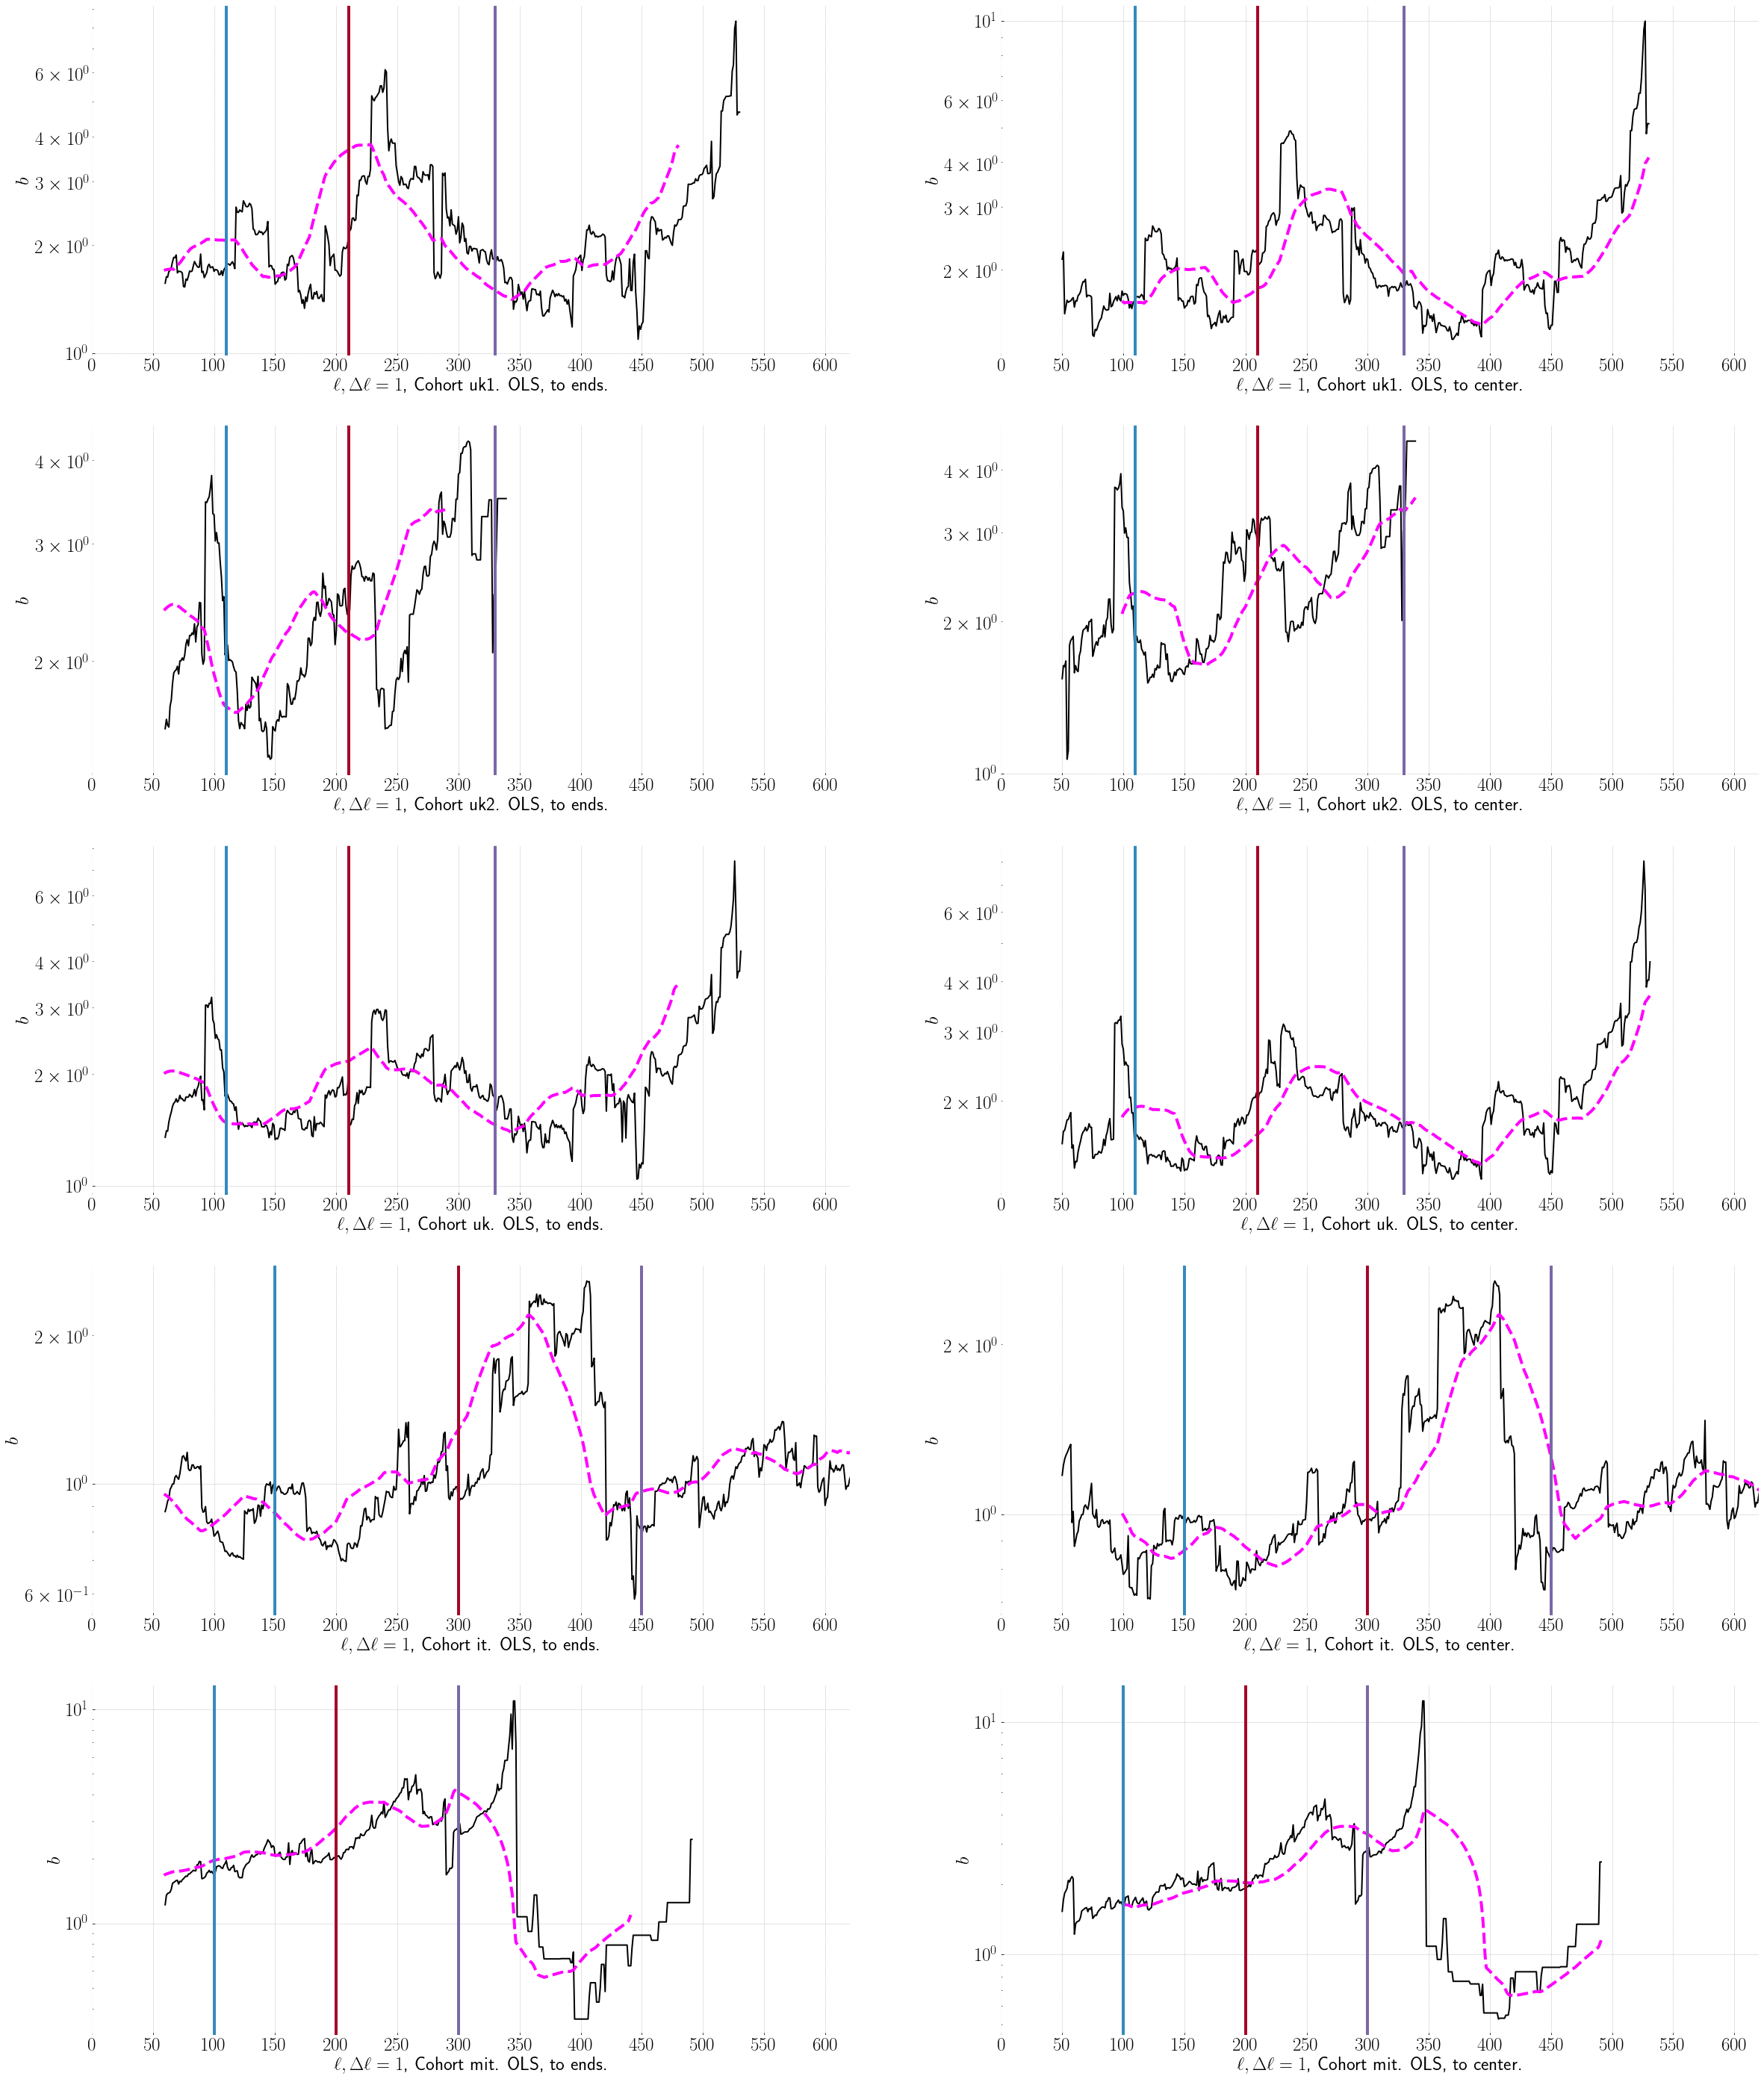

In [47]:
plt.figure(figsize=(20*2, 10*5))
p = 1
for c in ['uk1', 'uk2', 'uk', 'it', 'mit']:
    plt.subplot(5, 2, p)
    plt.xlabel(fr'$\ell, \Delta \ell = 1$, Cohort {c}. OLS, to ends.')
    plt.ylabel(r'$b$')
    plt.semilogy()
    plt.xlim(0, 620)
    plt.xticks(range(0, 620, 50))
    plt.plot([x + 50 for x in fa[c]['olsToEnds'].index], fa[c]['olsToEnds'][0], markersize=8, ls="solid", c="black", lw=2)
    plt.plot([x + 0 for x in fa[c]['olsToEnds'].index], fa[c]['olsToEnds']['ma50'], marker="", ls="dashed", c='magenta', lw=4)
    if c == 'mit':
        plt.axvline(100, ls="solid", lw=4, c=colors[0])
        plt.axvline(200, ls="solid", lw=4, c=colors[1])
        plt.axvline(300, ls="solid", lw=4, c=colors[2])
    elif c == 'it':
        plt.axvline(150, ls="solid", lw=4, c=colors[0])
        plt.axvline(300, ls="solid", lw=4, c=colors[1])
        plt.axvline(450, ls="solid", lw=4, c=colors[2])
    else:
        plt.axvline(110, ls="solid", lw=4, c=colors[0])
        plt.axvline(210, ls="solid", lw=4, c=colors[1])
        plt.axvline(330, ls="solid", lw=4, c=colors[2])
    p += 1
    
    plt.subplot(5, 2, p)
    plt.xlabel(fr'$\ell, \Delta \ell = 1$, Cohort {c}. OLS, to center.')
    plt.ylabel(r'$b$')
    plt.semilogy()
    plt.xlim(0, 620)
    plt.xticks(range(0, 620, 50))
    plt.plot([x + 50 for x in fa[c]['olsToCenter'].index], fa[c]['olsToCenter'][0], markersize=8, ls="solid", c="black", lw=2)
    plt.plot([x + 50 for x in fa[c]['olsToCenter'].index], fa[c]['olsToCenter']['ma50'], marker="", ls="dashed", c='magenta', lw=4)
    if c == 'mit':
        plt.axvline(100, ls="solid", lw=4, c=colors[0])
        plt.axvline(200, ls="solid", lw=4, c=colors[1])
        plt.axvline(300, ls="solid", lw=4, c=colors[2])
    elif c == 'it':
        plt.axvline(150, ls="solid", lw=4, c=colors[0])
        plt.axvline(300, ls="solid", lw=4, c=colors[1])
        plt.axvline(450, ls="solid", lw=4, c=colors[2])
    else:
        plt.axvline(110, ls="solid", lw=4, c=colors[0])
        plt.axvline(210, ls="solid", lw=4, c=colors[1])
        plt.axvline(330, ls="solid", lw=4, c=colors[2])
    p += 1

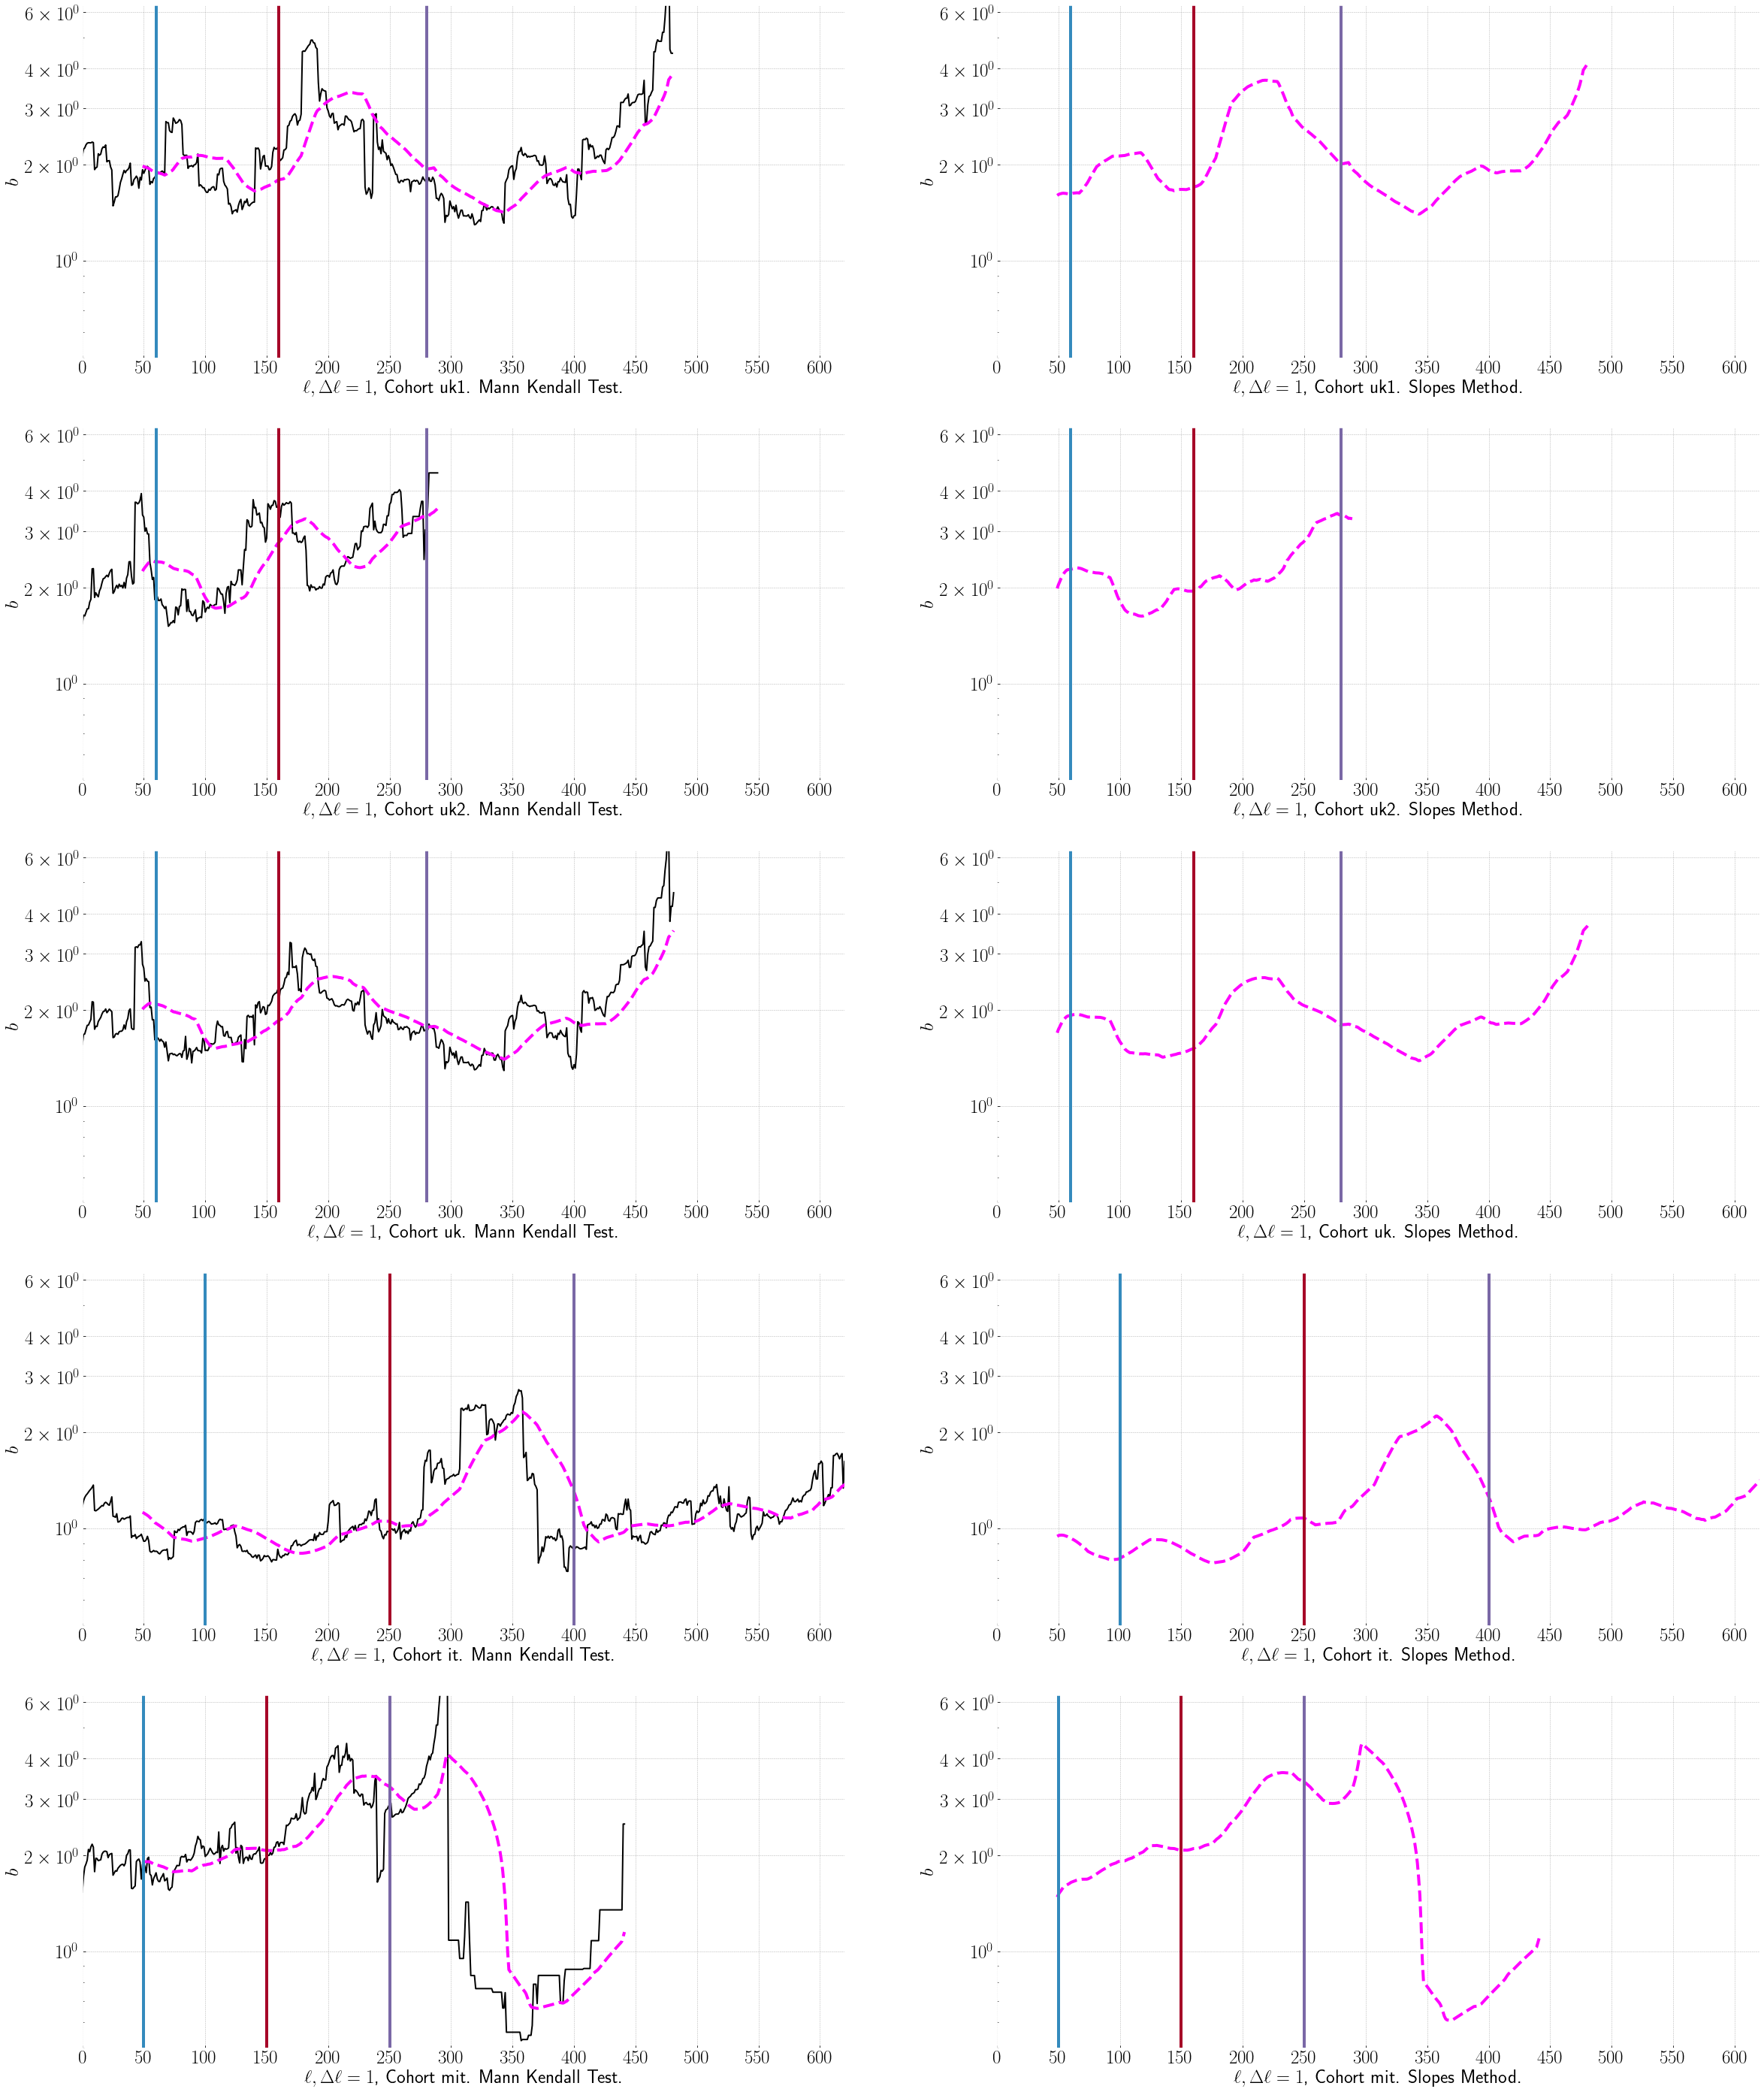

In [48]:
plt.figure(figsize=(20*2, 10*5))
p = 1
for c in ['uk1', 'uk2', 'uk', 'it', 'mit']:
    plt.subplot(5, 2, p)
    plt.xlabel(fr'$\ell, \Delta \ell = 1$, Cohort {c}. Mann Kendall Test.')
    plt.ylabel(r'$b$')
    plt.semilogy()
    plt.xlim(0, 620)
    plt.ylim(0.5, 6.3)
    plt.yticks([1, 2, 3, 4, 6], [r'$10^0$', r'$2\times10^0$', r'$3\times 10^0$', r'$4\times 10^0$', r'$6\times 10^0$'])
    plt.xticks(range(0, 620, 50))
    plt.plot([x + 0 for x in fa[c]['mk'].index], fa[c]['mk'][0], markersize=8, ls="solid", c="black", lw=2)
    plt.plot([x + 0 for x in fa[c]['mk'].index], fa[c]['mk']['ma50'], marker="", ls="dashed", c='magenta', lw=4)
    if c == 'mit':
        plt.axvline(50, ls="solid", lw=4, c=colors[0])
        plt.axvline(150, ls="solid", lw=4, c=colors[1])
        plt.axvline(250, ls="solid", lw=4, c=colors[2])
    elif c == 'it':
        plt.axvline(100, ls="solid", lw=4, c=colors[0])
        plt.axvline(250, ls="solid", lw=4, c=colors[1])
        plt.axvline(400, ls="solid", lw=4, c=colors[2])
    else:
        plt.axvline(60, ls="solid", lw=4, c=colors[0])
        plt.axvline(160, ls="solid", lw=4, c=colors[1])
        plt.axvline(280, ls="solid", lw=4, c=colors[2])
    p += 1
    
    plt.subplot(5, 2, p)
    plt.xlabel(fr'$\ell, \Delta \ell = 1$, Cohort {c}. Slopes Method.')
    plt.ylabel(r'$b$')
    plt.semilogy()
    plt.xlim(0, 620)
    plt.ylim(0.5, 6.3)
    plt.yticks([1, 2, 3, 4, 6], [r'$10^0$', r'$2\times10^0$', r'$3\times 10^0$', r'$4\times 10^0$', r'$6\times 10^0$'])
    plt.xticks(range(0, 620, 50))
    #plt.plot([x + 50 for x in fa[c]['slopes'].index], fa[c]['slopes'][0], markersize=8, ls="solid", c="black", lw=2)
    plt.plot([x + 0 for x in fa[c]['slopes'].index], fa[c]['slopes']['ma50'], marker="", ls="dashed", c='magenta', lw=4)
    if c == 'mit':
        plt.axvline(50, ls="solid", lw=4, c=colors[0])
        plt.axvline(150, ls="solid", lw=4, c=colors[1])
        plt.axvline(250, ls="solid", lw=4, c=colors[2])
    elif c == 'it':
        plt.axvline(100, ls="solid", lw=4, c=colors[0])
        plt.axvline(250, ls="solid", lw=4, c=colors[1])
        plt.axvline(400, ls="solid", lw=4, c=colors[2])
    else:
        plt.axvline(60, ls="solid", lw=4, c=colors[0])
        plt.axvline(160, ls="solid", lw=4, c=colors[1])
        plt.axvline(280, ls="solid", lw=4, c=colors[2])
    p += 1

In [49]:
faslopes = {}
faslopes['uk'] = fa['uk']['slopes'].loc[fa['uk']['slopes'].index <= 300]
faslopes['uk1'] = fa['uk1']['slopes'].loc[fa['uk1']['slopes'].index <= 300]
faslopes['uk2'] = fa['uk2']['slopes'].loc[fa['uk2']['slopes'].index <= 300]
faslopes['it'] = fa['it']['slopes'].loc[fa['it']['slopes'].index <= 420]
faslopes['mit'] = fa['mit']['slopes'].loc[fa['mit']['slopes'].index <= 300]

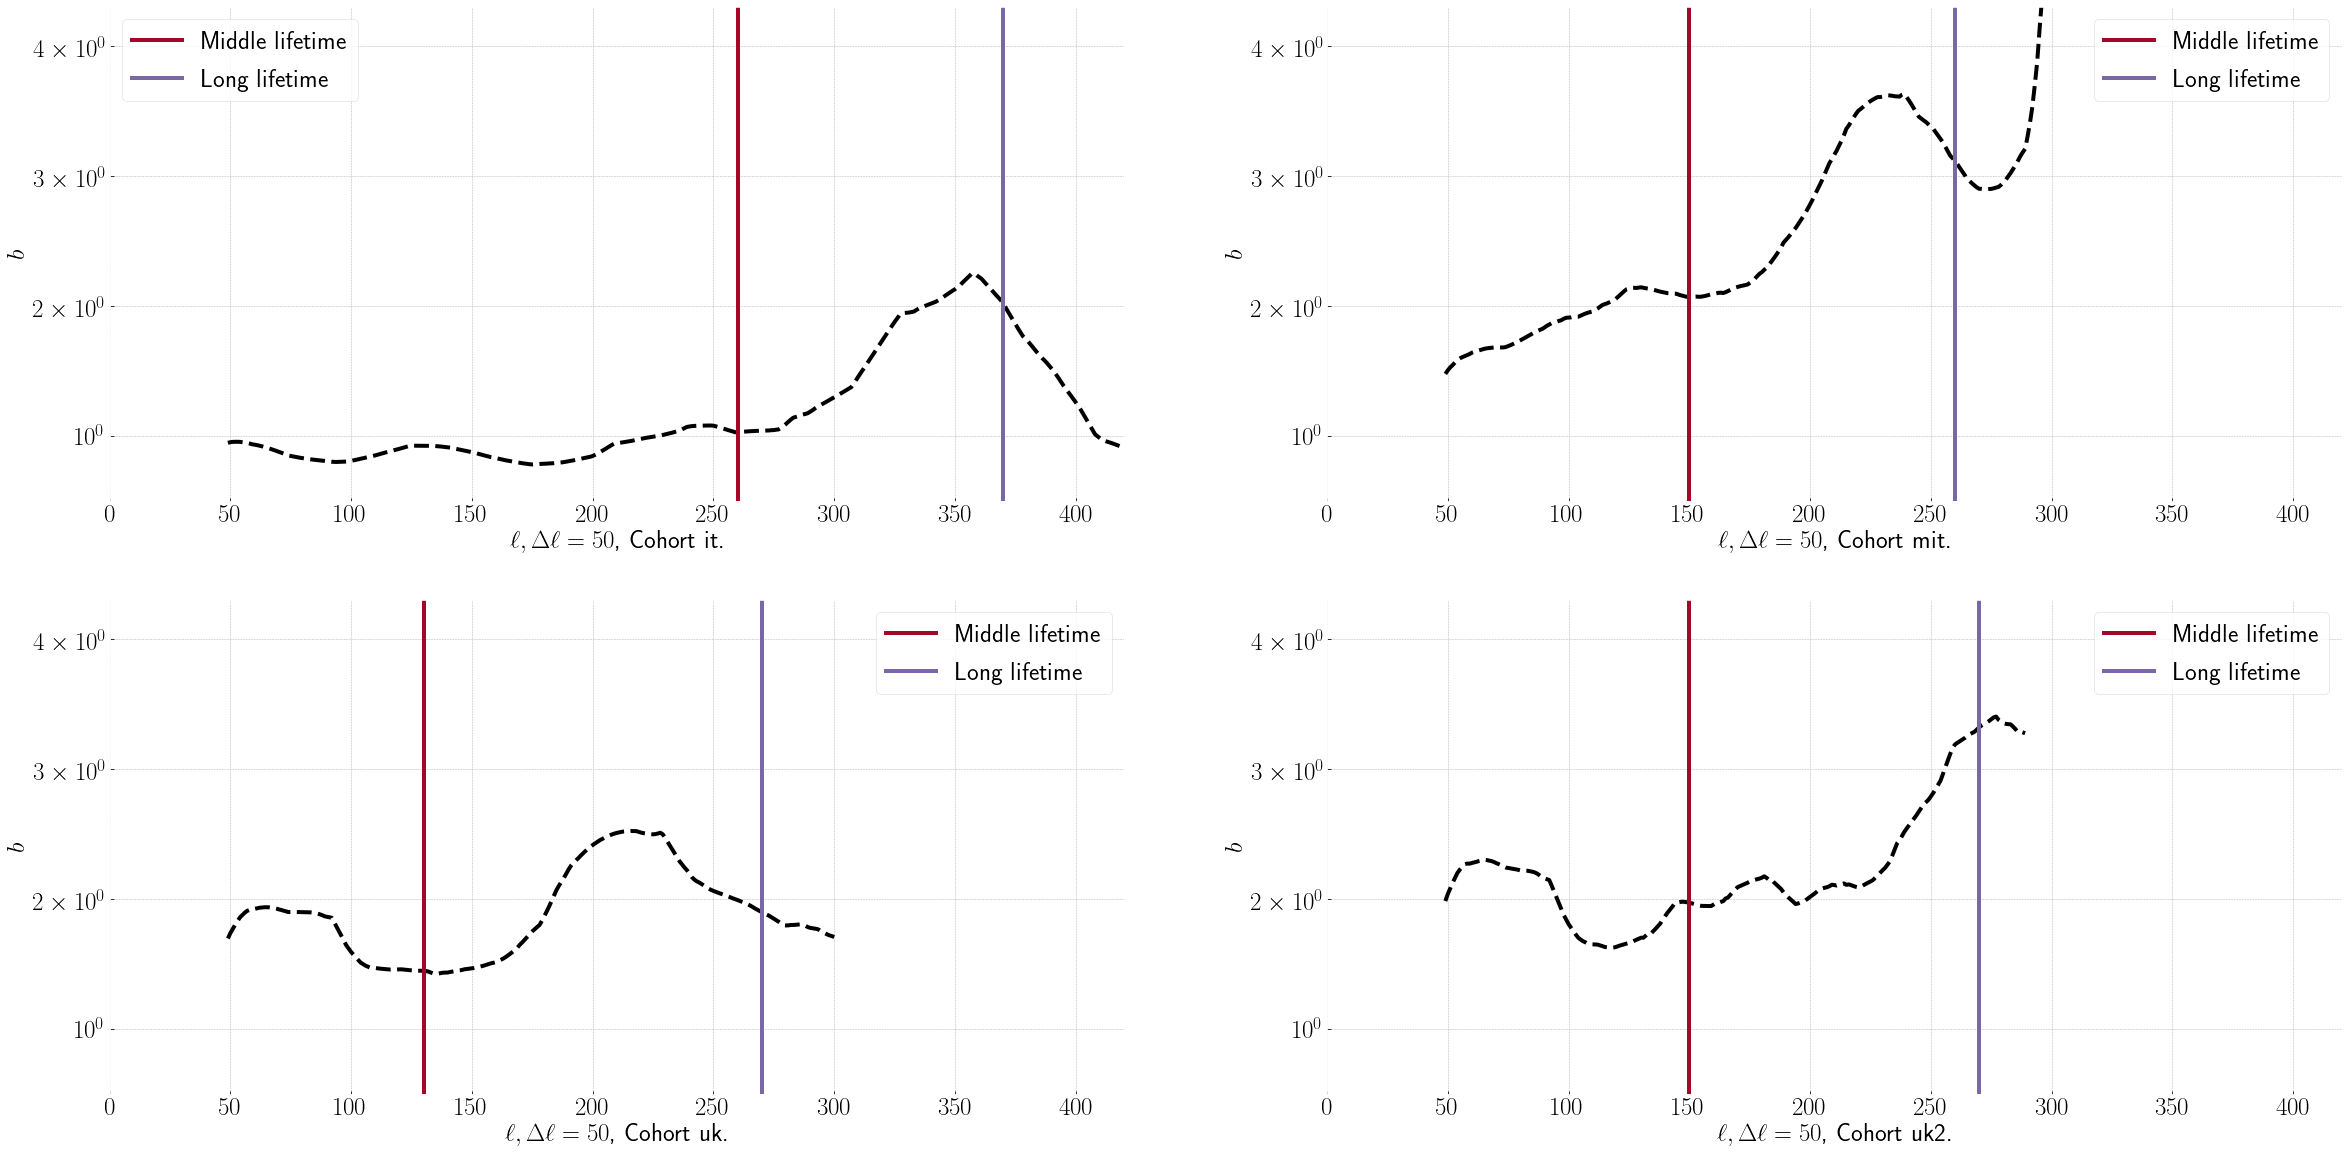

In [50]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['it', 'mit', 'uk', 'uk2']:
    plt.subplot(2, 2, p)
    plt.xlabel(fr'$\ell, \Delta \ell = 50$, Cohort {c}.')
    plt.ylabel(r'$b$')
    #plt.semilogy()
    plt.xlim(0, 420)
    plt.ylim(0.5, 4.3)
    plt.yticks([1, 2, 3, 4], [r'$10^0$', r'$2\times10^0$', r'$3\times 10^0$', r'$4\times 10^0$'])
    plt.xticks(range(0, 420, 50))
    #plt.plot([x + 0 for x in faslopes[c].index], faslopes[c][0], markersize=8, ls="solid", c="magenta", lw=2)
    plt.plot([x + 0 for x in faslopes[c].index], faslopes[c]['ma50'], marker="", ls="dashed", c='black', lw=4)
    if c == 'mit':
        #plt.axvline(50, ls="solid", lw=4, c=colors[0], label="Short lifetime")
        plt.axvline(150, ls="solid", lw=4, c=colors[1], label="Middle lifetime")
        plt.axvline(260, ls="solid", lw=4, c=colors[2], label="Long lifetime")
    elif c == 'it':
        #plt.axvline(100, ls="solid", lw=4, c=colors[0], label="Short lifetime")
        plt.axvline(260, ls="solid", lw=4, c=colors[1], label="Middle lifetime")
        plt.axvline(370, ls="solid", lw=4, c=colors[2], label="Long lifetime")
    elif c == 'uk':
        #plt.axvline(100, ls="solid", lw=4, c=colors[0], label="Short lifetime")
        plt.axvline(130, ls="solid", lw=4, c=colors[1], label="Middle lifetime")
        plt.axvline(270, ls="solid", lw=4, c=colors[2], label="Long lifetime")
    else:
        #plt.axvline(60, ls="solid", lw=4, c=colors[0], label="Short lifetime")
        plt.axvline(150, ls="solid", lw=4, c=colors[1], label="Middle lifetime")
        plt.axvline(270, ls="solid", lw=4, c=colors[2], label="Long lifetime")
    p += 1
    plt.legend()
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA2.pdf", dpi=200)

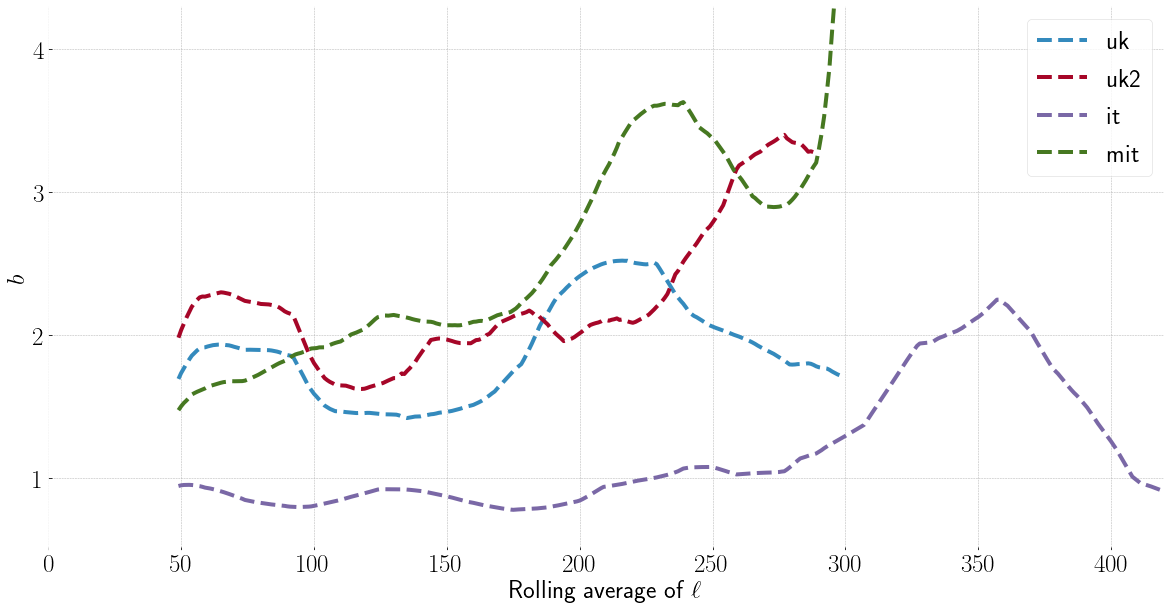

In [51]:
plt.figure(figsize=(20, 10))

plt.xlabel(fr'Rolling average of $\ell$')
plt.ylabel(r'$b$')
#plt.semilogy()
plt.xlim(0, 420)
plt.ylim(0.5, 4.3)
plt.yticks([1, 2, 3, 4])
plt.xticks(range(0, 420, 50))
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.plot([x + 0 for x in faslopes[c].index], faslopes[c]['ma50'], marker="", ls="dashed",lw=4, label=c)
#plt.plot([x + 0 for x in faslopes[c].index], faslopes[c][0], markersize=8, ls="solid", c="magenta", lw=2)
    #plt.plot([x + 0 for x in faslopes[c].index], faslopes[c]['ma50'], marker="", ls="dashed",lw=4)
p += 1
plt.legend()
plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA3.pdf", dpi=200)

## Flag when the algorithm does not converge. 

I will only test the slopes algorithm, since it produced the most *smooth* results

In [52]:
def get_b_slopes(series, patternsize=3, FlagConverge=False):
    allslopes = []
    X = list(series.index)
    N = len(X)
    xo, xf = X[0], X[-1]
    yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
    slope = (yf - yo) / (xf - xo)
    allslopes.append(slope)
    for i in range(1, N):
        newx = X[i // 2: N - ((i + 1) // 2)]
        if len(newx) > 1:
            xo, xf = newx[0], newx[-1]
            yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
            slope = (yf - yo) / (xf - xo)
            allslopes.append(slope)
        else:
            xo, xf = X[1], X[-2]
            df = series.loc[(series.index >= xo) & (series.index <= xf)]
            yo = np.mean(df['f'])
            yf = yo
            if FlagConverge:
                return [[xo, xf], [yo, yf], False]
            else:
                return [[xo, xf], [yo, yf]]
        if (len(allslopes) >= patternsize):
            checkSlopes = list(np.sign(allslopes[-patternsize:]))
            if checkSlopes.count(checkSlopes[0]) != len(checkSlopes):
                df = series.loc[(series.index >= xo) & (series.index <= xf)]
                yo = np.mean(df['f'])
                yf = yo
                if FlagConverge:
                    return [[xo, xf], [yo, yf], True]
                else:
                    return [[xo, xf], [yo, yf]]

In [53]:
t0 = dt.datetime.now()
fa = {}
converge = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    fa[c] = {}
    converge[c] = {}
    for ell in range(maxa[c]):
        if c == 'it':
            curve  = {'f': pc.get_avgfa(itdffa15[60], itlives[60], ell, ell + 50)}
        else:
            curve = pc.get_fal(calls[c], ell, ell + 50, 15)
        if len(curve['f']) > 3:
            points = get_b_slopes(curve['f'], FlagConverge=True)
            fa[c][ell] = points[1][1]
            converge[c][ell] = points[2]
    fa[c] = pd.DataFrame.from_dict(fa[c], orient='index').sort_index().rename({0: 'b'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
    fa[c] = fa[c].merge(tmp, left_index=True, right_index=True, how='outer')
    fa[c]['ma50'] = fa[c]['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:03:04.576592


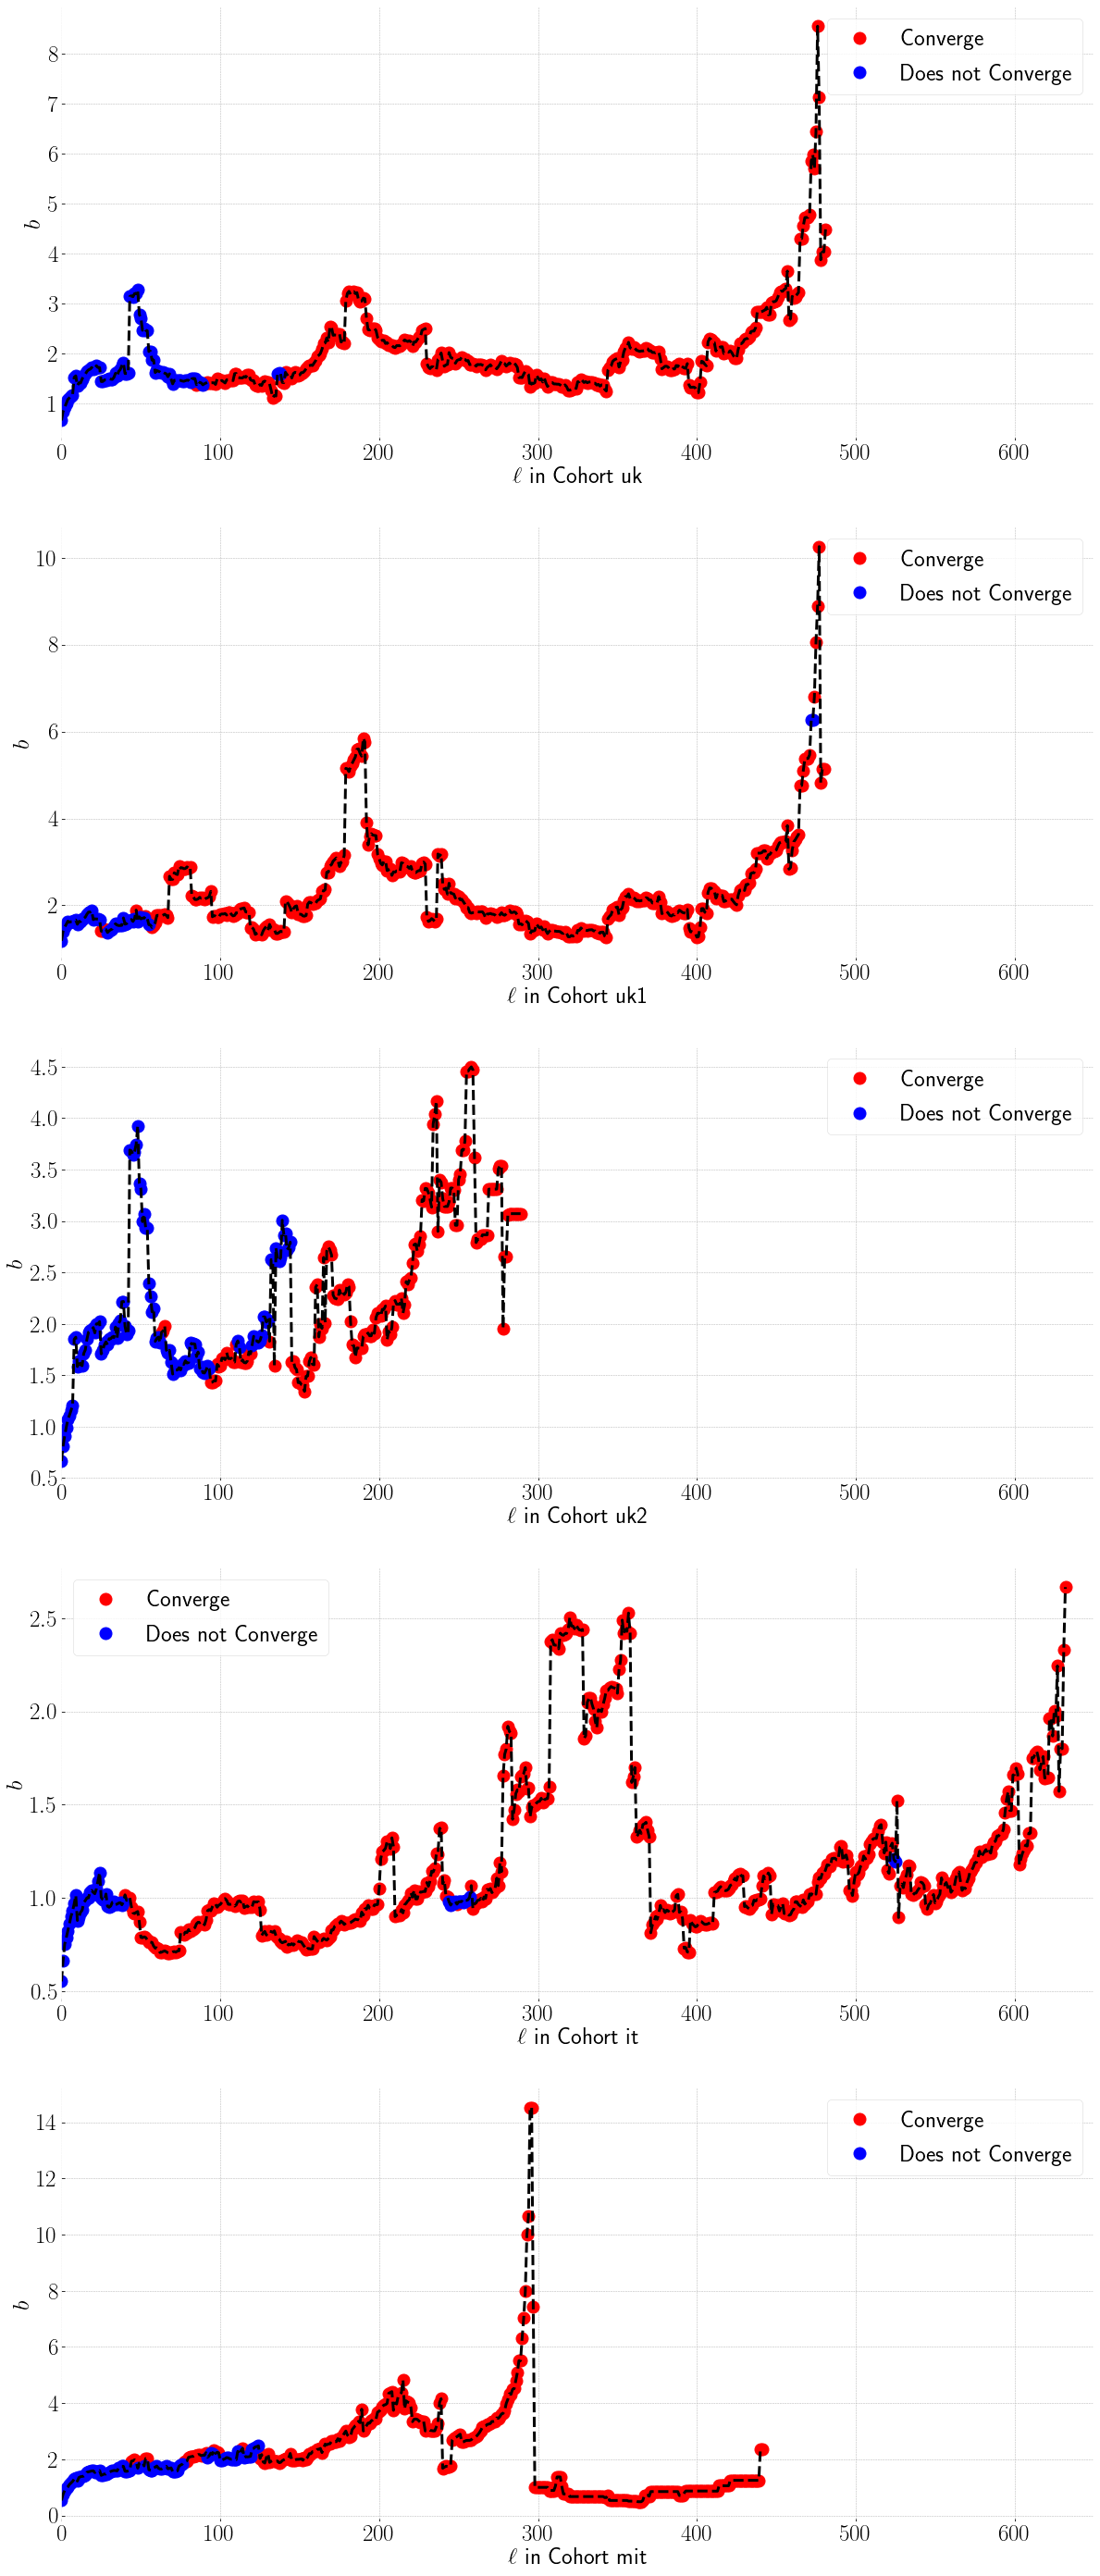

In [54]:
plt.figure(figsize=(20, 10*5))
p = 1
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    plt.subplot(5, 1, p)
    plt.xlabel(fr"$\ell$ in Cohort {c}")
    plt.ylabel(r"$b$")
    plt.xlim(0, 650)
    #plt.ylim(0.5, 4.3)
    df = fa[c].copy(deep=True)
    df1 = df.loc[df['converge'] == True]
    df2 = df.loc[df['converge'] == False]
    plt.plot(df1.index, df1['b'], marker="o", markersize=13, c="red", ls="", label="Converge")
    plt.plot(df2.index, df2['b'], marker="o", markersize=13, c="blue", ls="", label="Does not Converge")
    plt.plot(df.index, df['b'], marker="", ls="dashed", lw=3, c="black")
    plt.legend()
    p += 1

In [55]:
fa2 = {}
fa2['uk'] = fa['uk'].loc[fa['uk'].index <= 300]
fa2['uk2'] = fa['uk2'].loc[fa['uk2'].index <= 300]
fa2['it'] = fa['it'].loc[fa['it'].index <= 420]
fa2['mit'] = fa['mit'].loc[fa['mit'].index <= 300]

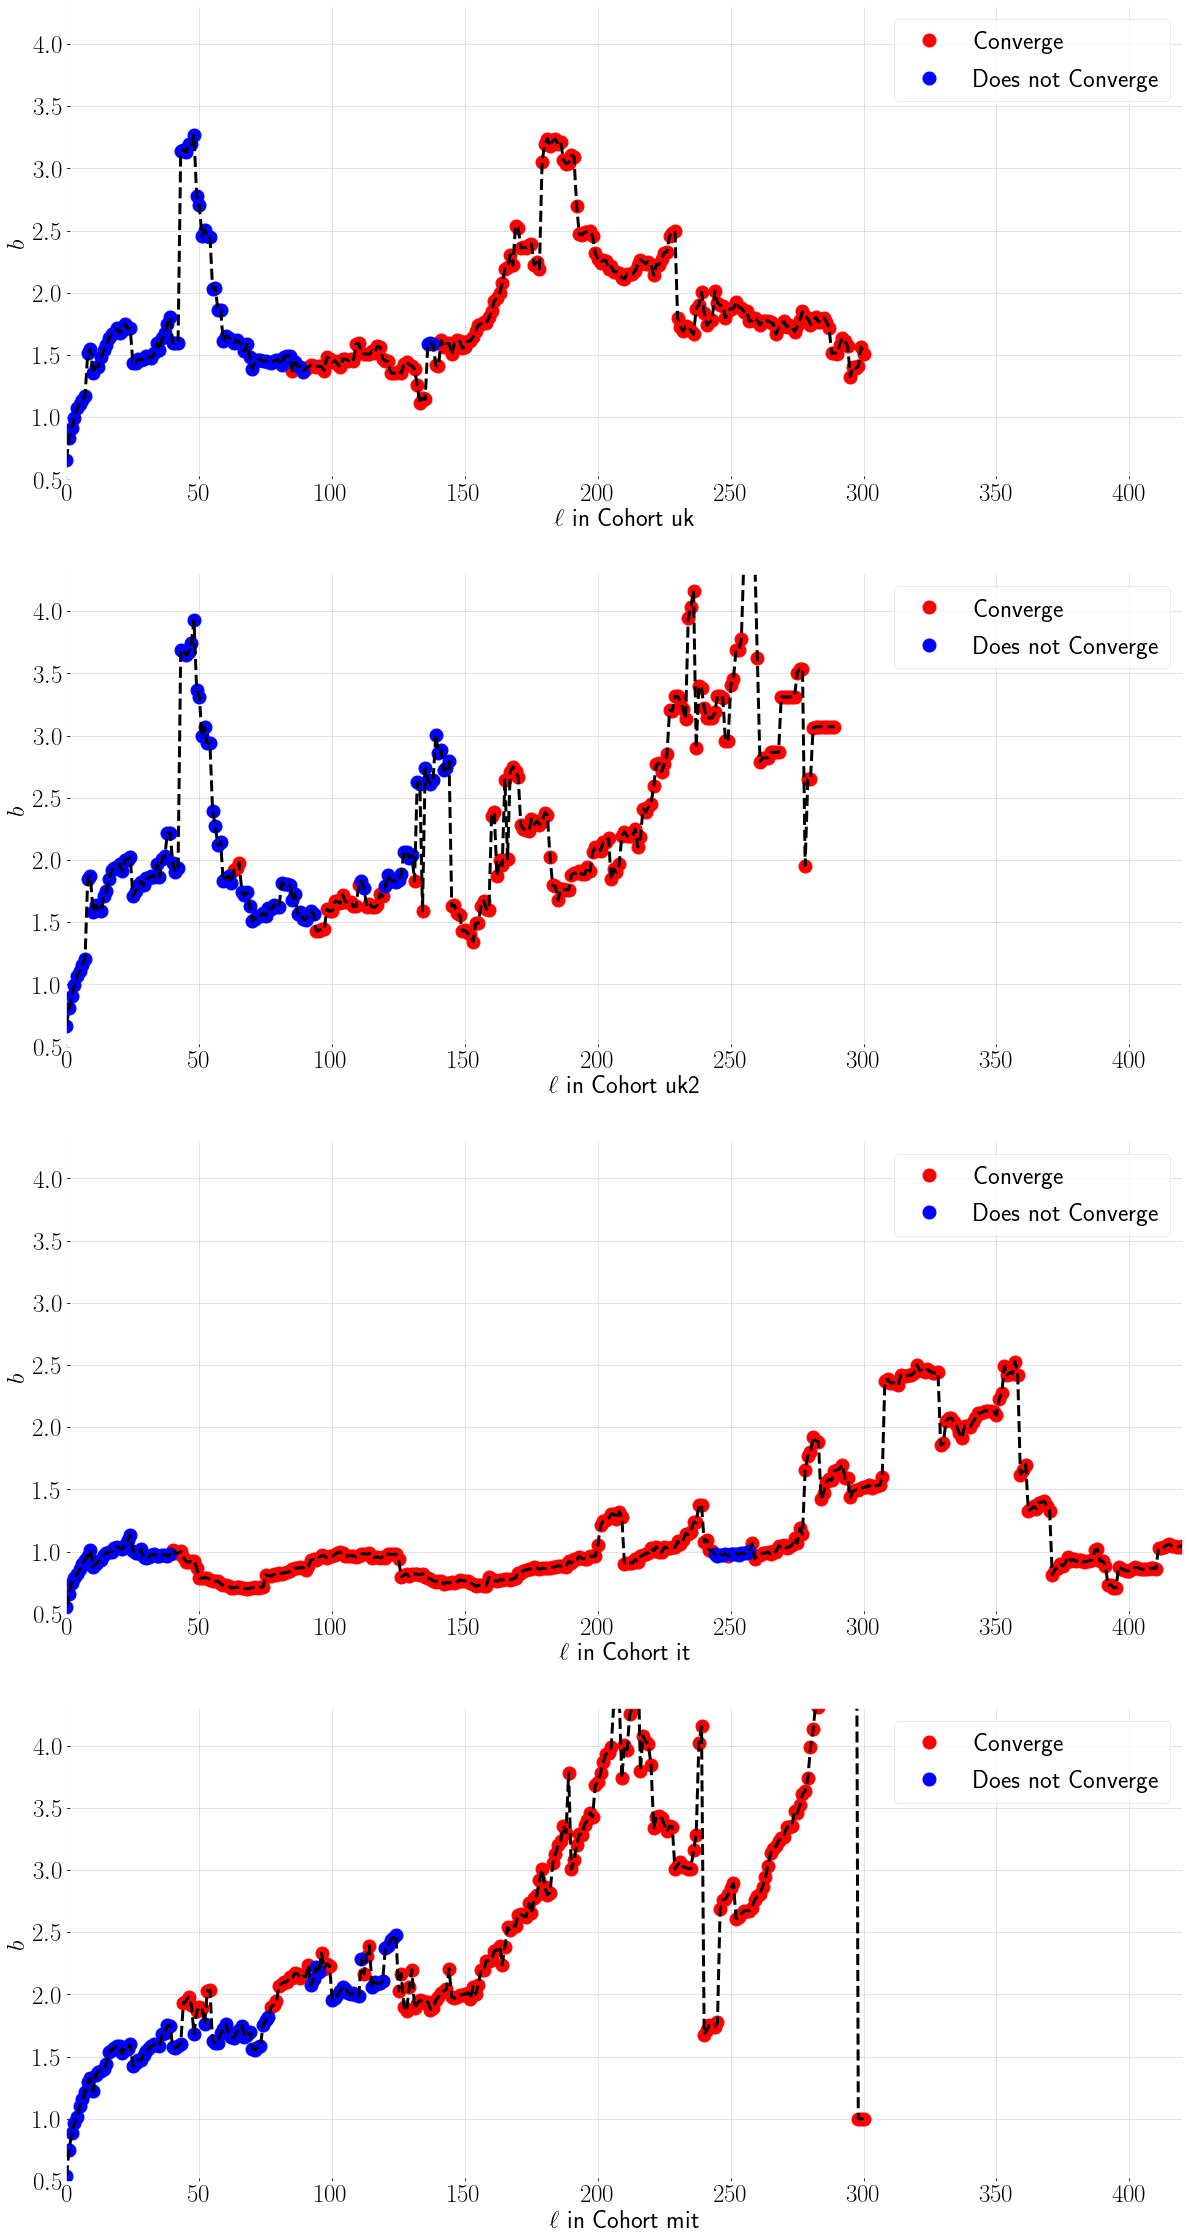

In [56]:
plt.figure(figsize=(20, 10*4))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(4, 1, p)
    plt.xlabel(fr"$\ell$ in Cohort {c}")
    plt.ylabel(r"$b$")
    plt.xlim(0, 420)
    plt.ylim(0.5, 4.3)
    df = fa2[c].copy(deep=True)
    df1 = df.loc[df['converge'] == True]
    df2 = df.loc[df['converge'] == False]
    plt.plot(df1.index, df1['b'], marker="o", markersize=13, c="red", ls="", label="Converge")
    plt.plot(df2.index, df2['b'], marker="o", markersize=13, c="blue", ls="", label="Does not Converge")
    plt.plot(df.index, df['b'], marker="", ls="dashed", lw=3, c="black")
    plt.legend()
    p += 1

## Identify $\tilde{\ell}$

In [57]:
t0 = dt.datetime.now()
b = {}
converge = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    b[c] = {}
    converge[c] = {}
    for ell in range(maxa[c]):
        if c == 'it':
            curve  = {'f': pc.get_avgfa(itdffa15[60], itlives[60], ell, ell + 50)}
        else:
            curve = pc.get_fal(calls[c], ell, ell + 50, 15)
        if len(curve['f']) > 2:
            points = get_b_slopes(curve['f'], FlagConverge=True)
            b[c][ell] = points[1][1]
            converge[c][ell] = points[2]
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'b'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c]['ma50'] = b[c]['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:03:02.848779


In [58]:
tildeb = {}
for c in b.keys():
    df = fa[c].copy(deep=True)
    df1 = df.loc[df['converge'] == True]
    tildeb[c] = min(df1.index)

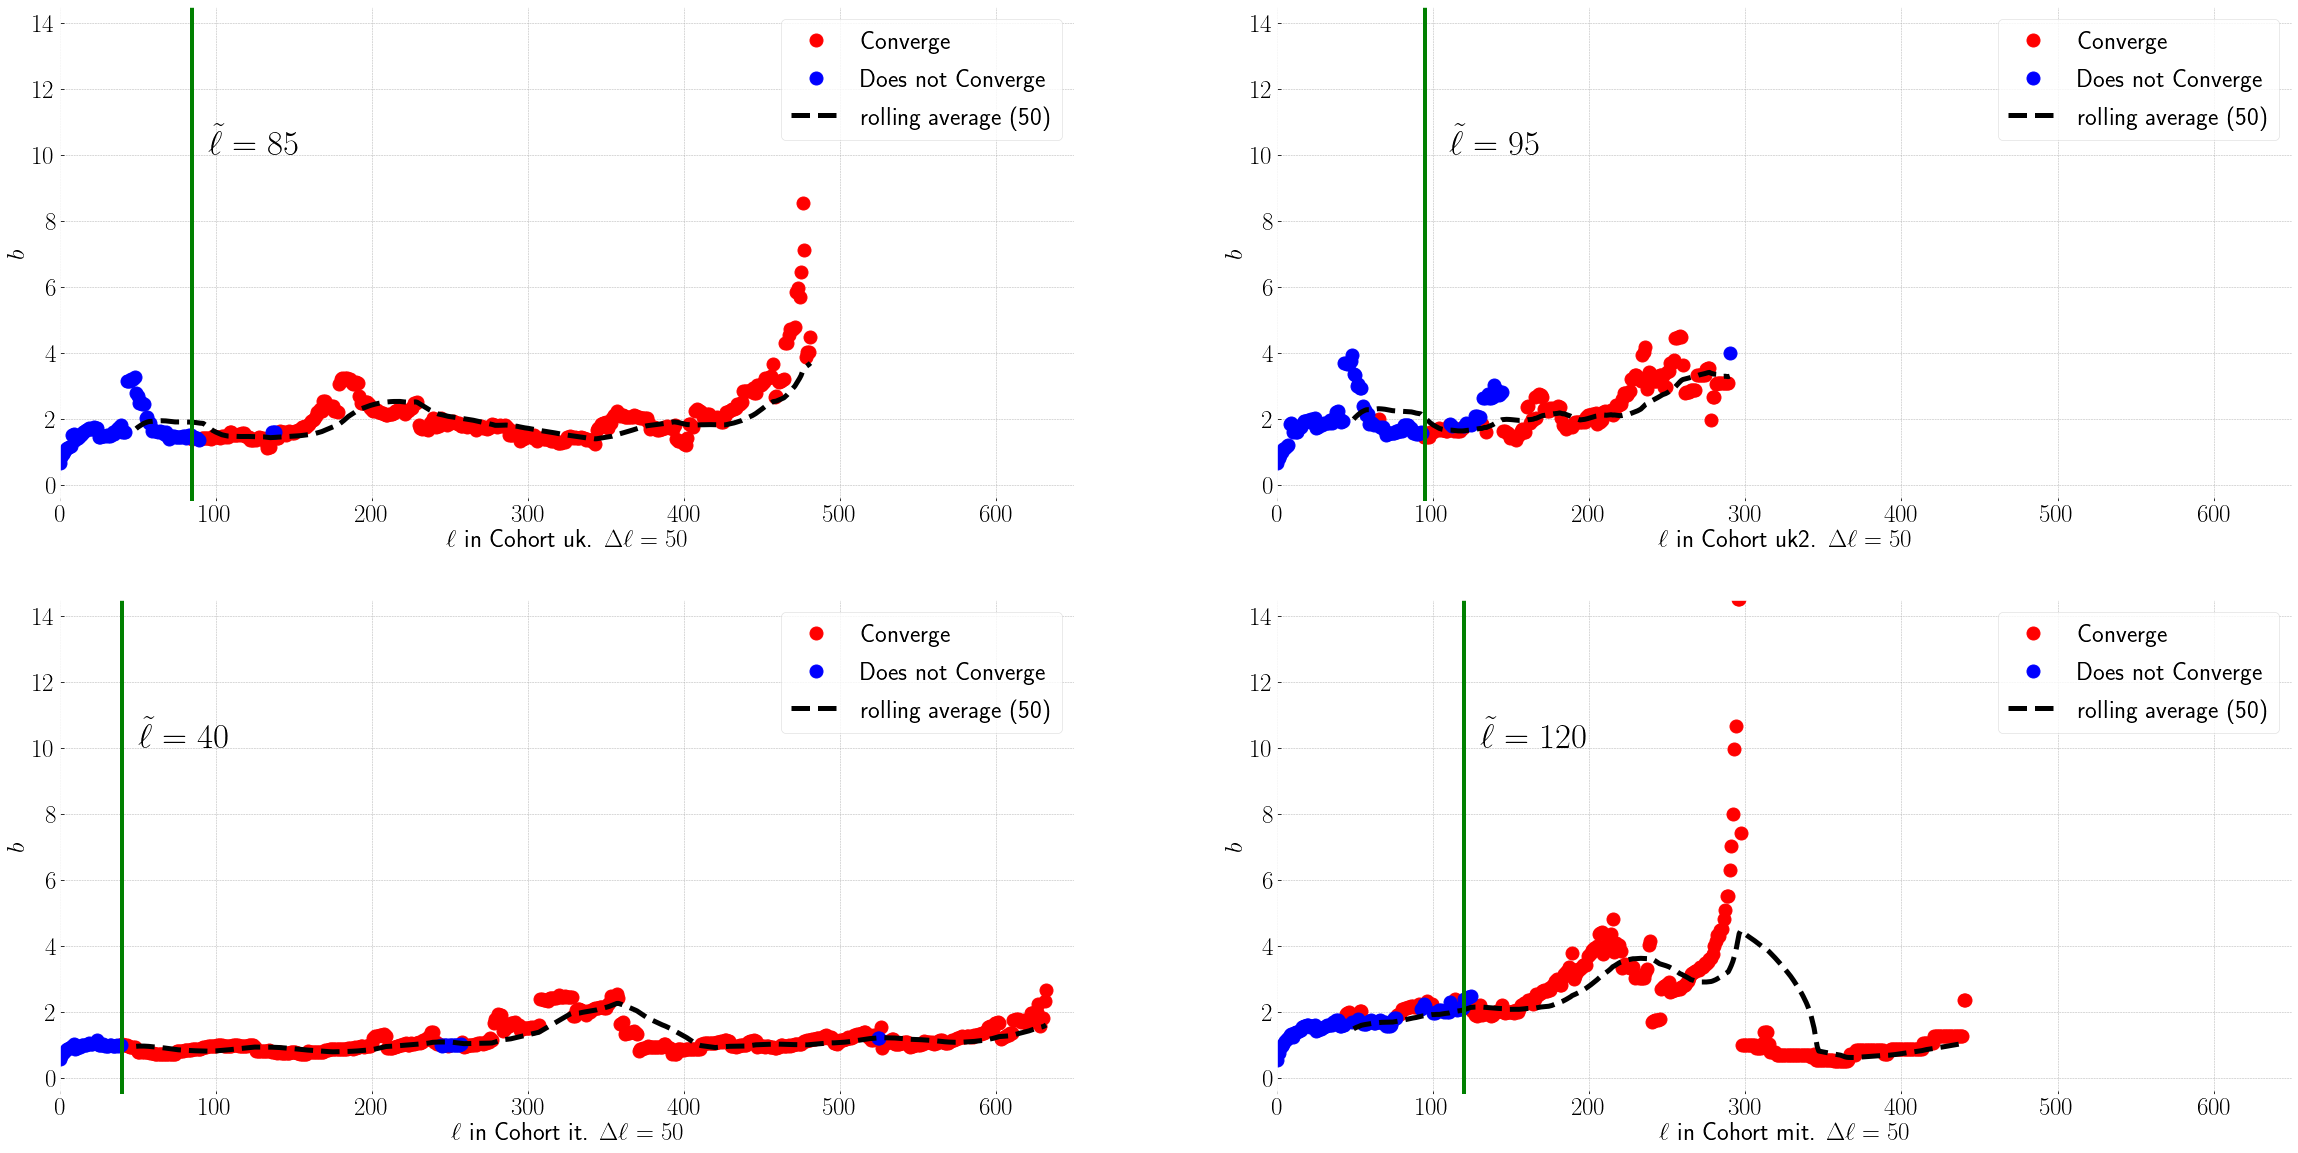

In [59]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.xlabel(fr"$\ell$ in Cohort {c}. $\Delta \ell = 50$")
    plt.ylabel(r"$b$")
    plt.xlim(0, 650)
    plt.ylim(-0.5, 14.5)
    df = b[c].copy(deep=True)
    df1 = df.loc[df['converge'] == True]
    df2 = df.loc[df['converge'] == False]
    plt.plot(df1.index, df1['b'], marker="o", markersize=13, c="red", ls="", label="Converge")
    plt.plot(df2.index, df2['b'], marker="o", markersize=13, c="blue", ls="", label="Does not Converge")
    plt.plot(df.index, df['ma50'], marker="", ls="dashed", lw=5, c="black", label="rolling average (50)")
    if c == 'uk2':
        plt.axvline(95, c="green", lw=4)
        plt.annotate(r'$\tilde{\ell} = 95$', (110, 10), fontsize=35)
    elif c == 'mit':
        plt.axvline(120, c="green", lw=4)
        plt.annotate(r'$\tilde{\ell} = 120$', (130, 10), fontsize=35)
    else:
        plt.axvline(tildeb[c], c="green", lw=4)
        plt.annotate(fr'$\tilde \ell = {tildeb[c]}$', (tildeb[c] + 10, 10), fontsize=35)
    plt.legend()
    p += 1

In [60]:
def get_tildeell(bdf, lookforward=15):
    bdf = bdf.sort_index()
    c = bdf.loc[bdf['converge'] == True]
    for i in c.index:
        for j in range(1, lookforward + 1):
            if i + j not in c.index:
                break
        else:
            return i

In [61]:
for c in b.keys():
    print(c, get_tildeell(b[c]))

uk 90
uk1 56
uk2 94
it 40
mit 125


In [62]:
egolist = {}
for c in ['uk', 'uk2', 'mit']:
    egolist[c] = list(calls[c]['ego'].unique())
egolist['it'] = list(itdffa15[60].keys())

In [63]:
t0 = dt.datetime.now()
bi = {}
converge = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    bi[c] = {}
    converge[c] = {}
    for ego in egolist[c]:
        bi[c][ego] = {}
        converge[c][ego] = {}
        if c == 'it':
            lf = {alter: itlives[60][ego][alter]['ell'] for alter in itlives[60][ego].keys()}
            for ell in range(max(lf.values())):
                tmp = {ego: itdffa15[60][ego]}
                curve  = {'fi': pc.get_avgfa(tmp, itlives[60], ell, ell + 50)}
                if len(curve['fi']) > 2:
                    points = get_b_slopes(curve['fi'], FlagConverge=True)
                    bi[c][ego][ell] = points[1][1]
                    converge[c][ego][ell] = points[2]
        else:
            df = calls[c].loc[calls[c]['ego'] == ego]
            for ell in range(max(df['aclock'])):
                curve = pc.get_fal(df, ell, ell + 50, 15)
                if (curve is not None) and (len(curve['fi'][ego]) > 2):
                    points = get_b_slopes(curve['fi'][ego], FlagConverge=True)
                    bi[c][ego][ell] = points[1][1]
                    converge[c][ego][ell] = points[2]
        if len(bi[c][ego].keys()) > 0:
            bi[c][ego] = pd.DataFrame.from_dict(bi[c][ego], orient='index').sort_index().rename({0: 'b'}, axis='columns')
            tmp = pd.DataFrame.from_dict(converge[c][ego], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
            bi[c][ego] = bi[c][ego].merge(tmp, left_index=True, right_index=True, how='outer')
            bi[c][ego]['ma50'] = bi[c][ego]['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:05:09.136878


In [64]:
bif = {}
for c in bi.keys():
    bif[c] = {}
    for ego in bi[c].keys():
        if type(bi[c][ego]) == pd.core.frame.DataFrame:
            bif[c][ego] = bi[c][ego]

In [65]:
tildellH = {}
for c in bif.keys():
    tildellH[c] = pc.histogram([get_tildeell(bif[c][ego], 16) for ego in bif[c].keys() if get_tildeell(bif[c][ego]) is not None], 15, log=False)

In [66]:
sum(tildellH['uk']['h'] * tildellH['uk']['label'])

937.6666666666667

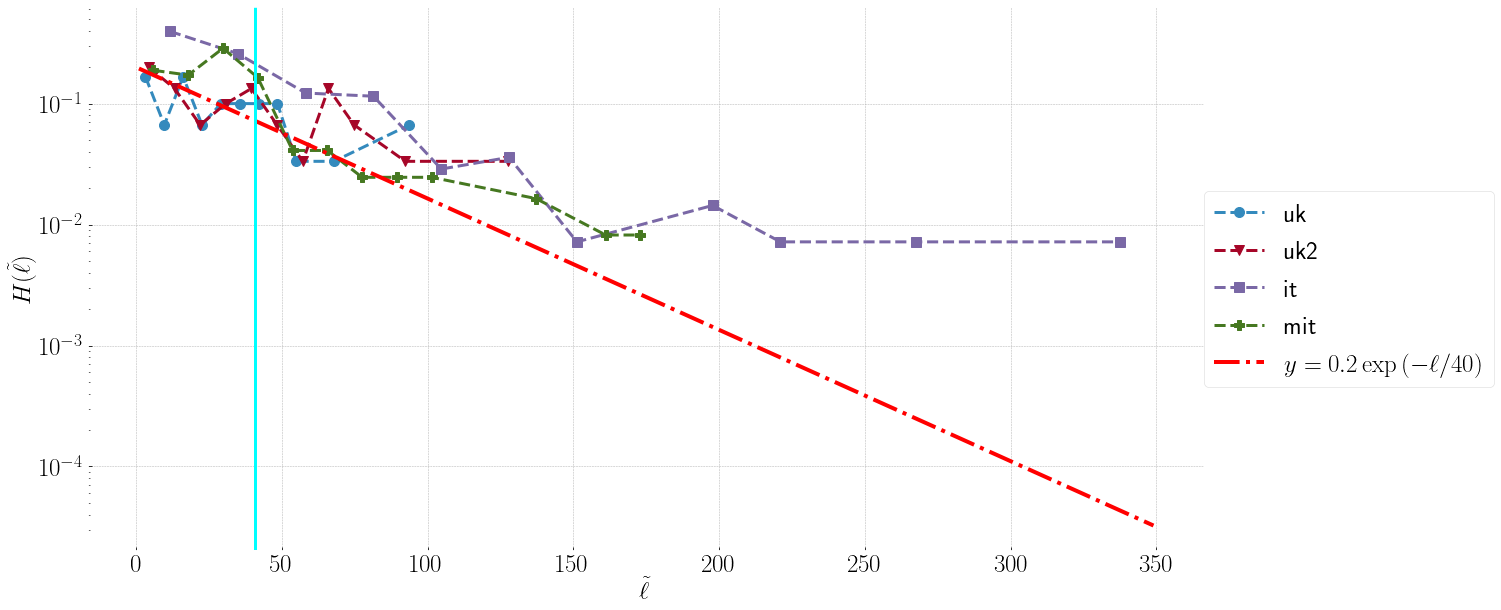

In [67]:
plt.figure(figsize=(20, 10))
plt.xlabel(fr'$\tilde \ell$')
plt.ylabel(r'$H(\tilde{\ell})$')
plt.semilogy()
m = 0
avg = 0
sumh = 0
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.plot(tildellH[c]['label'], tildellH[c]['pmf'], marker=markers[m], markersize=10, ls="dashed", lw=3, c=colors[m], label=c)
    avg += sum(tildellH[c]['h'] * tildellH[c]['label'])
    sumh += sum(tildellH[c]['h'])
    #plt.axvline(get_tildeell(b[c]), c=colors[m], lw=4)
    m += 1
avg /= sumh
# plt.plot(range(1, 350), [0.2 * np.exp(-ell / 80) for ell in range(1, 350)], marker="", ls="solid", lw=4, c="black", label=r"$y = 0.2\exp{(-\ell / 80)}$")
# plt.plot(range(1, 350), [0.2 * np.exp(-ell / 70) for ell in range(1, 350)], marker="", ls="dashed", lw=4, c="black", label=r"$y = 0.2\exp{(-\ell / 70)}$")
# plt.plot(range(1, 350), [0.2 * np.exp(-ell / 60) for ell in range(1, 350)], marker="", ls="dotted", lw=4, c="black", label=r"$y = 0.2\exp{(-\ell / 60)}$")
# plt.plot(range(1, 350), [0.2 * np.exp(-ell / 50) for ell in range(1, 350)], marker="", ls="dashdot", lw=4, c="black", label=r"$y = 0.2\exp{(-\ell / 50)}$")
plt.plot(range(1, 350), [0.2 * np.exp(-ell / 40) for ell in range(1, 350)], marker="", ls="dashdot", lw=4, c="red", label=r"$y = 0.2\exp{(-\ell / 40)}$")
plt.axvline(avg, c="cyan", lw=3)
plt.legend(loc=(1, 0.3))

In [68]:
tmp = []
for c in ['uk', 'mit', 'it']:
    tmp += [get_tildeell(bif[c][ego], 16) for ego in bif[c].keys() if get_tildeell(bif[c][ego]) is not None]

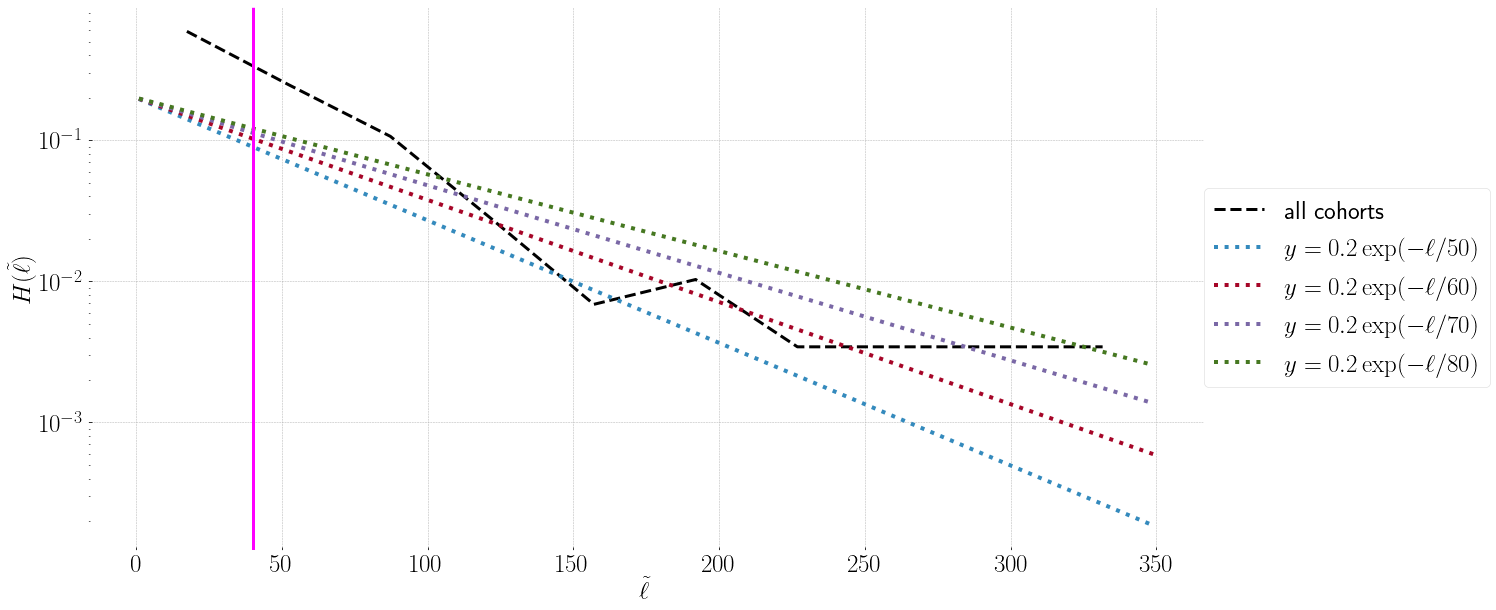

In [69]:
plt.figure(figsize=(20, 10))
plt.xlabel(fr'$\tilde \ell$')
plt.ylabel(r'$H(\tilde{\ell})$')
plt.semilogy()
H = pc.histogram(tmp, 10, log=False)
plt.plot(H['label'], H['pmf'], ls="dashed", lw=3, c="black", label="all cohorts")
for m in range(50, 81, 10):
    plt.plot(range(1, 350), [0.2 * np.exp(-ell / m) for ell in range(1, 350)], marker="", ls="dotted", lw=4, label=fr"$y = 0.2\exp(-\ell / {m})$")
plt.axvline(np.mean(tmp), c="magenta", lw=3)
plt.legend(loc=(1, 0.3))

In [70]:
lims = {}
lims[0] = (25, 75)
lims[1] = (50, 100)
lims[2] = (70, 120)

testing = {}
for i in range(3):
    testing[i] = {}
    for c in ['uk', 'uk2', 'it', 'mit']:
        if c == 'it':
            testing[i][c] = pc.get_avgfa(itdffa15[60], itlives[60], lims[i][0], lims[i][1])
        else:
            tmp = pc.get_fal(calls[c], lims[i][0], lims[i][1], 15)
            testing[i][c] = tmp['f']

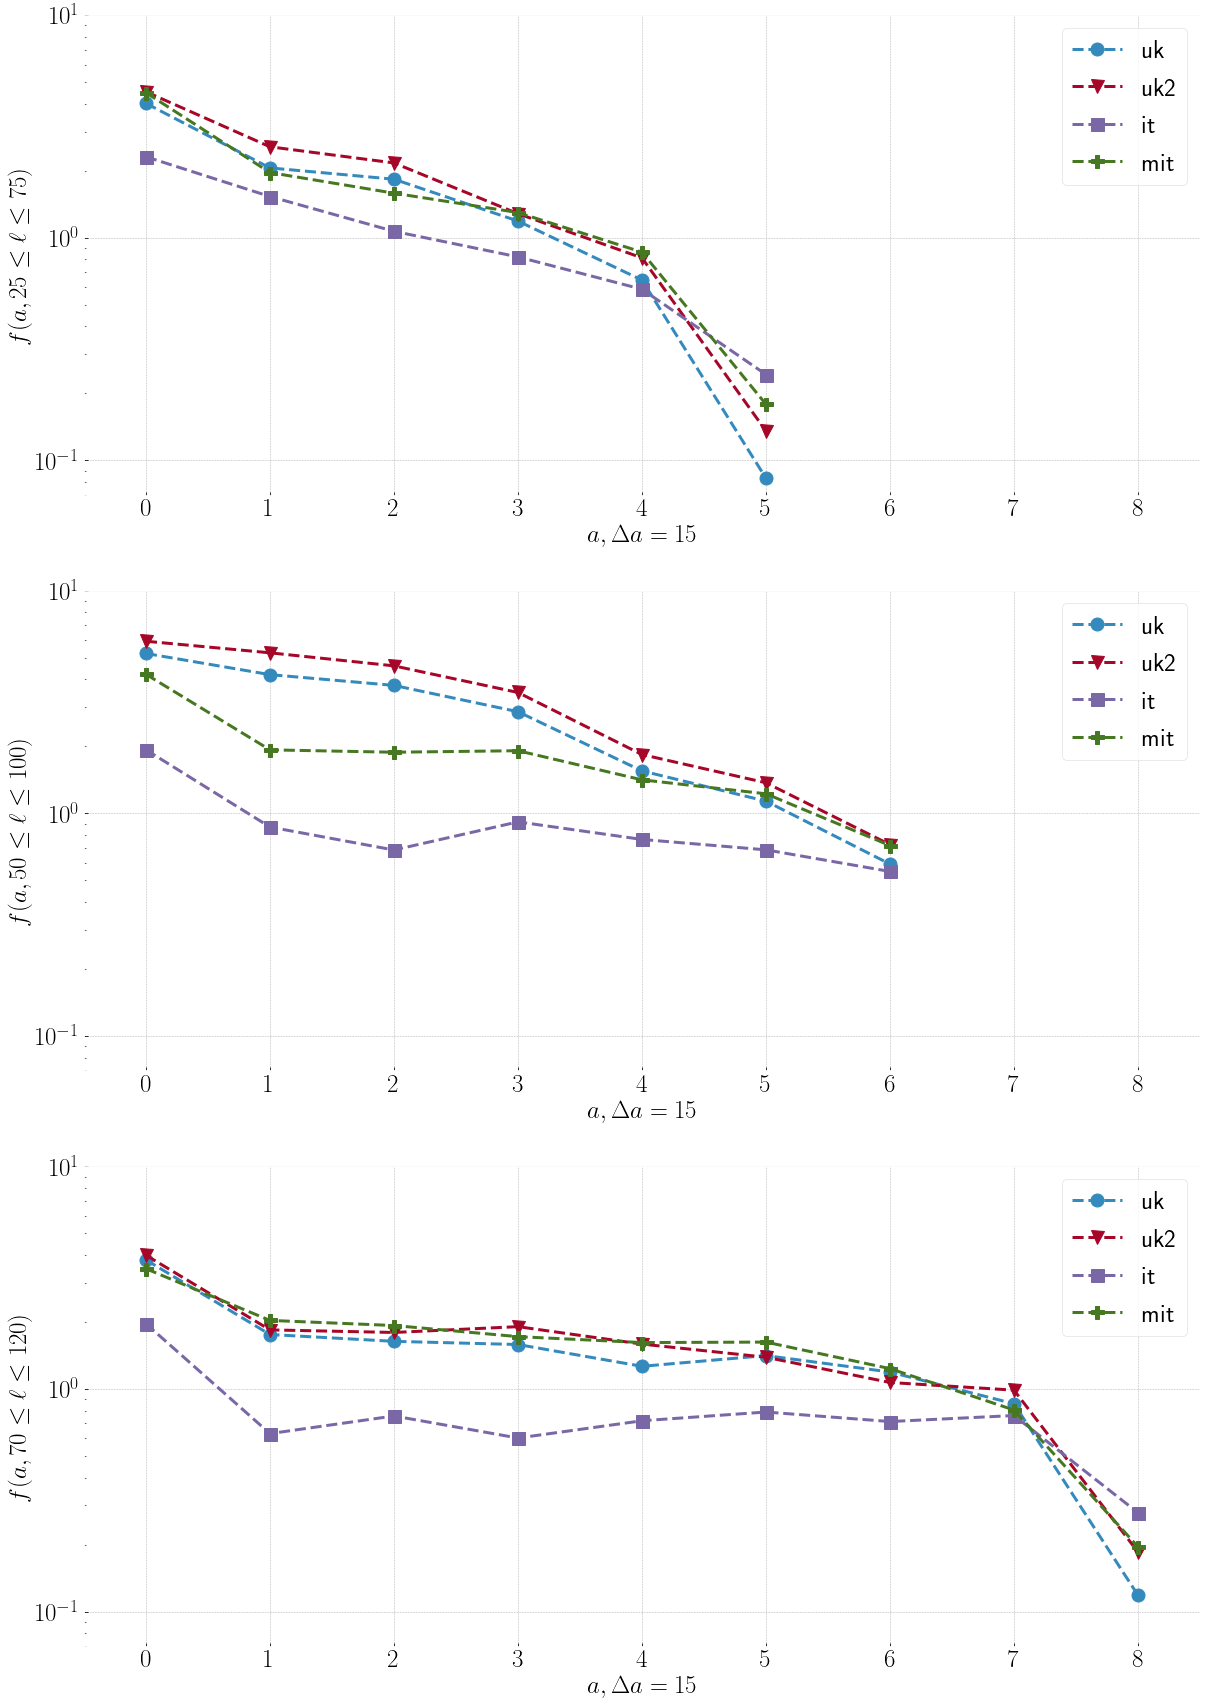

In [71]:
plt.figure(figsize=(20*1, 10*3))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.xlim(-0.5, 8.5)
    plt.ylim(7*10**(-2), 10)
    plt.xlabel(fr"$a, \Delta a  = 15$")
    plt.ylabel(fr"$f(a, {lims[i][0]} \leq \ell \leq {lims[i][1]})$")
    plt.semilogy()
    m = 0
    for c in testing[i].keys():
        plt.plot(testing[i][c].index, testing[i][c]['f'], marker=markers[m], markersize=13, ls="dashed", lw=3, label=c)
        m += 1
    plt.legend()

## Count the number of alters for each surve in Fig 3

In [72]:
dff = {}
dff['all'] = {}
for c in calls.keys():
    dff[c] = pc.get_f(calls[c], 'all', 30, 10)
    dff['all'].update(dff[c])
    
dff['it'] = itdffa30[60]
dff['all'].update(dff['it'])

survival = {}
for c in dff.keys():
    survival[c] = pc.get_survival(dff[c], lambdamax=25, countA=True)

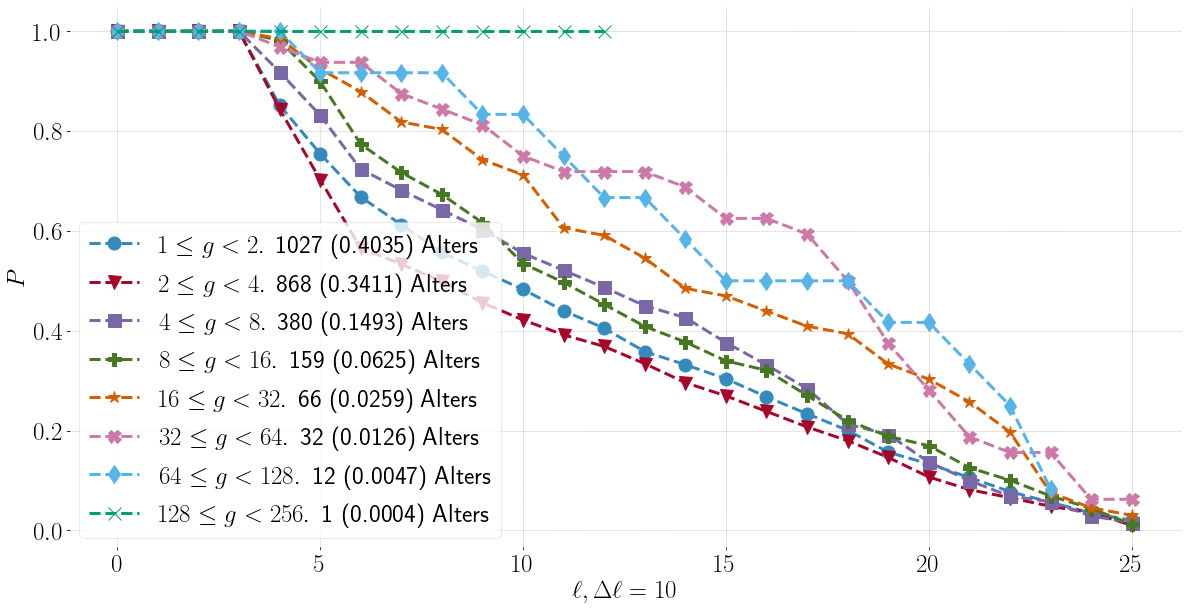

In [73]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
totalA = sum([survival['all'][1][k] for k in survival['all'][1].keys()])
for i in range(8):
    plt.plot(survival['all'][0][i].index, survival['all'][0][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$. {survival["all"][1][i]} ({(survival["all"][1][i] / totalA):.4f}) Alters')
plt.legend()

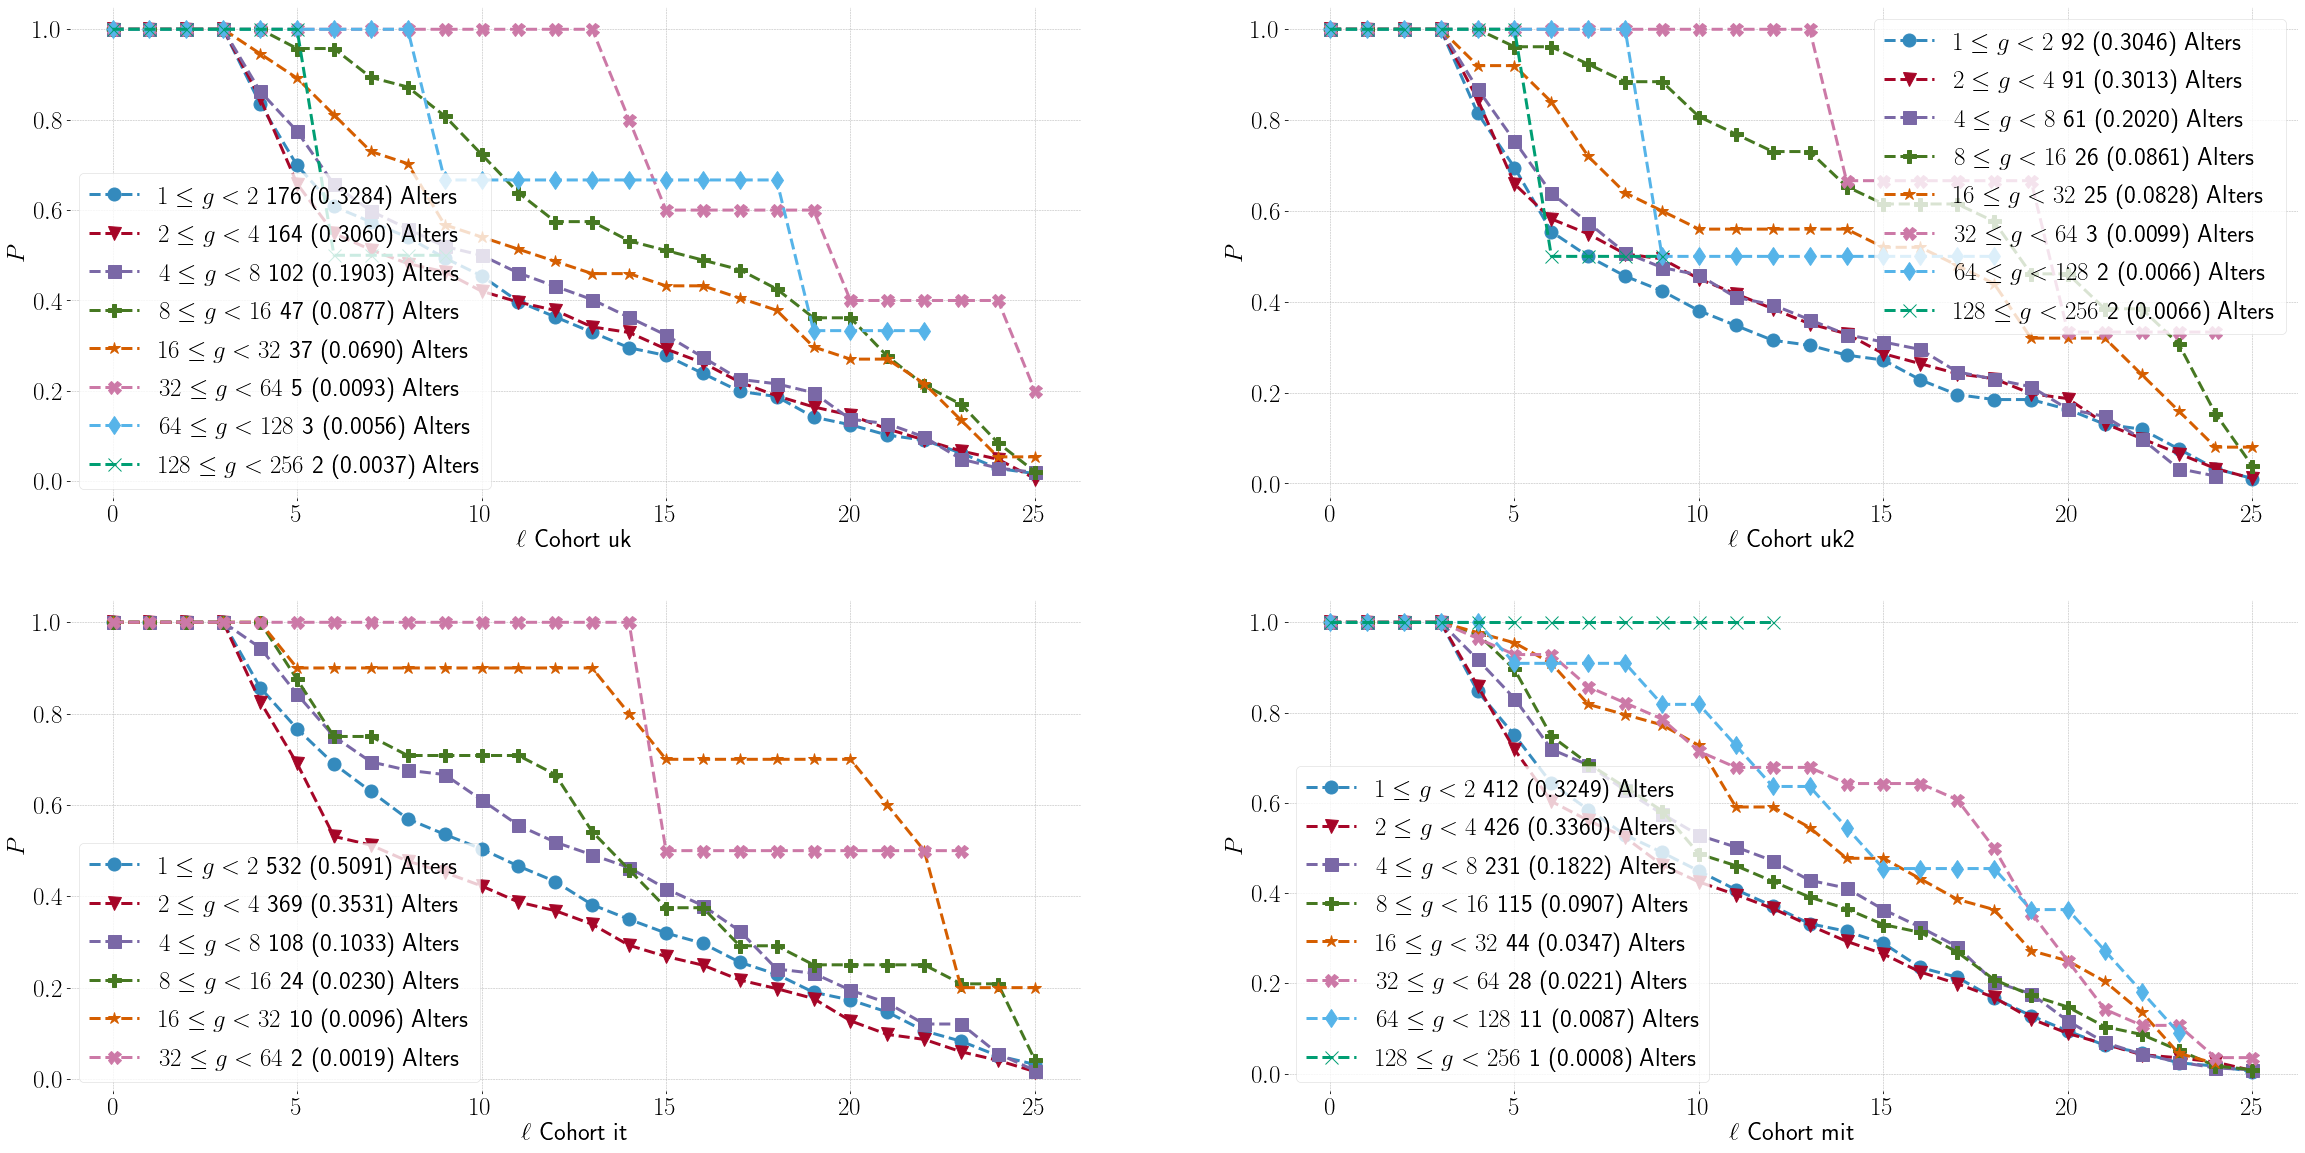

In [74]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    totalA = sum([survival[c][1][k] for k in survival[c][1].keys()])
    for i in sorted(survival[c][1].keys()):
        plt.plot(survival[c][0][i].index, survival[c][0][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$ {survival[c][1][i]} ({(survival[c][1][i] / totalA):.4f}) Alters')
    plt.legend()
    p += 1

## Identify alters in UK2

There are some alter in UK2, particularly those with $50 \leq \ell \leq 100$ that present a higher than usual activity. To explore this *anomaly*, I will separate those alters and check what type of relationship they have with ego

In [75]:
t0 = dt.datetime.now()
import sys

# First, read the files and put them in a list
thefiles = os.listdir("../ukdata/egos_attributeSummaries/")

# now, remove everything that does not follow the structure 'egoxx_...'
for i in thefiles:
    if i[5] != '_':
        thefiles.remove(i)

# I need the following lines because MacOS creates a .DS_Store file
if sys.platform == 'darwin':
    thefiles.remove('.DS_Store')
        
# Next, a list with just the number of the egos.
theindices = [int(i[3:5]) for i in thefiles]

# And finally, everything into a dictionary.
alterinfo = {}
colnames = ['alterid', 'male', 'related', 'sameGen', 'ec1', 'ec2', 'ec3', 'alter_number1', 'alter_number2', 'alter_number3', 'alter_number4']
for i in range(len(thefiles)):
    alterinfo[theindices[i]] = pd.read_csv(f"../ukdata/egos_attributeSummaries/{thefiles[i]}", header=None, sep=" ", names=colnames, na_values=-999, 
                                           dtype={'alter_number1' : 'str', 'alter_number2' : 'str', 'alter_number3' : 'str', 'alter_number4' : 'str'})
    
thefiles = os.listdir("../ukdata/egos_alterNumbers/")
for i in thefiles:
    if i[5] != '_':
        thefiles.remove(i)
idx = [int(i[3:5]) for i in thefiles]
alterid = {}
for eid in range(len(idx)):
    df = pd.read_csv(f'../ukdata/egos_alterNumbers/{thefiles[eid]}', header=None, sep=" ", dtype={0: 'str'})
    tmp2 = {}
    for i in df.index:
        key = df.at[i, 0][-8:]
        val = df.at[i, 1]
        tmp2[key] = val
    alterid[idx[eid]] = tmp2

eid = pd.read_pickle("egoid.pkl")

ukcalls = unfiltered['uk'].copy(deep=True)
ukcalls = ukcalls.drop(columns=['rm'])

egonames = eid.groupby('ego')[['egoid']].mean().to_dict()['egoid']

ukcalls['eid'] = ukcalls['ego'].map(lambda i: egonames[i[-8:]])\

egoaltertable = {}
for ego in alterinfo.keys():
    egoaltertable[ego] = {}
    df = alterinfo[ego]
    for i in df.index:
        for an in ['alter_number1', 'alter_number2', 'alter_number3', 'alter_number4']:
            if not pd.isna(df.at[i, an]):
                number = df.at[i, an]
                egoaltertable[ego][number] = i
                
ukcalls['alter8'] = ukcalls['alter'].map(lambda i: i[-8:])
ukcalls['tmp'] = list(zip(ukcalls['eid'], ukcalls['alter8']))
ukcalls['aid'] = ukcalls['tmp'].map(lambda i: egoaltertable[i[0]].get(i[1], 9999))
ukcalls = ukcalls.drop(columns=['tmp'])
ukcalls = ukcalls.loc[ukcalls['aid'] != 9999]

ukcalls['eaid'] = list(zip(ukcalls['eid'], ukcalls['aid']))
tmp = list(ukcalls['eaid'].unique())
dftmp = pd.DataFrame({'eaid': tmp})
dftmp['family'] = dftmp['eaid'].map(lambda i: alterinfo[i[0]].at[i[1], 'related'])
for ego in alterinfo.keys():
    df = alterinfo[ego]
    df['ec'] = df[['ec1', 'ec2', 'ec3']].mean(axis=1, skipna=True)
dftmp['ec'] = dftmp['eaid'].map(lambda i: alterinfo[i[0]].at[i[1], 'ec'])
ukcalls = ukcalls.merge(dftmp, on='eaid', how='outer')
print(f'Took {dt.datetime.now() - t0}')
ukcalls.head()

Took 0:00:00.596680


ego           alter                time  uclock  aclock  eid  \
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0   30   
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0   30   
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13   30   
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0   11   
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0   11   

     alter8  aid       eaid  family  ec  
0  65636994  177  (30, 177)     NaN NaN  
1  65636994  177  (30, 177)     NaN NaN  
2  65636994  177  (30, 177)     NaN NaN  
3  13487966  182  (11, 182)     NaN NaN  
4  13487966  182  (11, 182)     NaN NaN

In [76]:
calls['uk'].head()

ego         alter                time  uclock  aclock   rm
0  C07779270485  C01132304499 2007-09-26 08:42:00     204       0  0.0
1  C07779270485  C01132304499 2007-10-05 14:32:00     214      10  0.0
2  C07779270485  C01132304499 2007-10-27 01:11:00     235      31  0.0
3  C07779270485  C01132304499 2008-01-09 20:35:00     310     106  0.0
4  C07779270485  C01132416800 2008-05-06 02:16:00     427       0  0.0

In [77]:
ukcalls.head()

ego           alter                time  uclock  aclock  eid  \
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0   30   
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0   30   
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13   30   
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0   11   
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0   11   

     alter8  aid       eaid  family  ec  
0  65636994  177  (30, 177)     NaN NaN  
1  65636994  177  (30, 177)     NaN NaN  
2  65636994  177  (30, 177)     NaN NaN  
3  13487966  182  (11, 182)     NaN NaN  
4  13487966  182  (11, 182)     NaN NaN

In [78]:
ukdf = {}
ukdf['ukfa'] = ukcalls.loc[ukcalls['family'] == 1]
ukdf['ukfr'] = ukcalls.loc[ukcalls['family'] == 0]
ukdf['ukuc'] = ukcalls.loc[(ukcalls['family'] != 0) & (ukcalls['family'] != 1)]

In [79]:
for c in ukdf.keys():
    ukdf[c] = pc.apply_filters(ukdf[c], 60)
    maxa[c] = max(ukdf[c]['aclock'])

In [80]:
ukcalls = pc.apply_filters(ukcalls, 60)
ukcalls['ea'] = list(zip(ukcalls['ego'], ukcalls['alter'], ukcalls['time']))
print(1, len(ukcalls))
uk = {}
for c in ['uk', 'uk2']:
    df = calls[c].copy(deep=True)
    print(2, len(df))
    df2 = ukcalls[['ea', 'family']]
    print(3, len(df2))
    df['ea'] = list(zip(df['ego'], df['alter'], df['time']))
    print(3.5, len(df))
    df = df.merge(df2, left_on='ea', right_on='ea', how='left')
    print(4, len(df))
    df = df.drop(['ea'], axis='columns')
    uk[c] = df

1 35610
2 35638
3 35610
3.5 35638
4 35638
2 13493
3 35610
3.5 13493
4 13493


In [81]:
lf = {}
for c in uk.keys():
    uk[c]['ea'] = list(zip(uk[c]['ego'], uk[c]['alter']))
    lf[c] = uk[c].groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')

In [82]:
tmplives = {}
for c in uk.keys():
    tmplives[c] = pc.lives_dictionary(uk[c])

In [83]:
for c in uk.keys():
    uk[c]['ell'] = uk[c]['ea'].map(lambda i: tmplives[c][i[0]][i[1]]['ell'])

In [84]:
t0 = dt.datetime.now()
for c in ukdf.keys():
    fa[c] = {}
    converge[c] = {}
    for ell in range(maxa[c]):
        curve = pc.get_fal(ukdf[c], ell, ell + 50, 15)
        if len(curve['f']) > 3:
            points = get_b_slopes(curve['f'], FlagConverge=True)
            fa[c][ell] = points[1][1]
            converge[c][ell] = points[2]
    fa[c] = pd.DataFrame.from_dict(fa[c], orient='index').sort_index().rename({0: 'b'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
    fa[c] = fa[c].merge(tmp, left_index=True, right_index=True, how='outer')
    fa[c]['ma50'] = fa[c]['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:01:08.302772


In [85]:
for c in ['ukfa', 'ukfr', 'ukuc']:
    fa2[c] = fa[c].loc[fa[c].index <= 300]
    print(c, len(fa2[c]))

ukfa 285
ukfr 301
ukuc 301


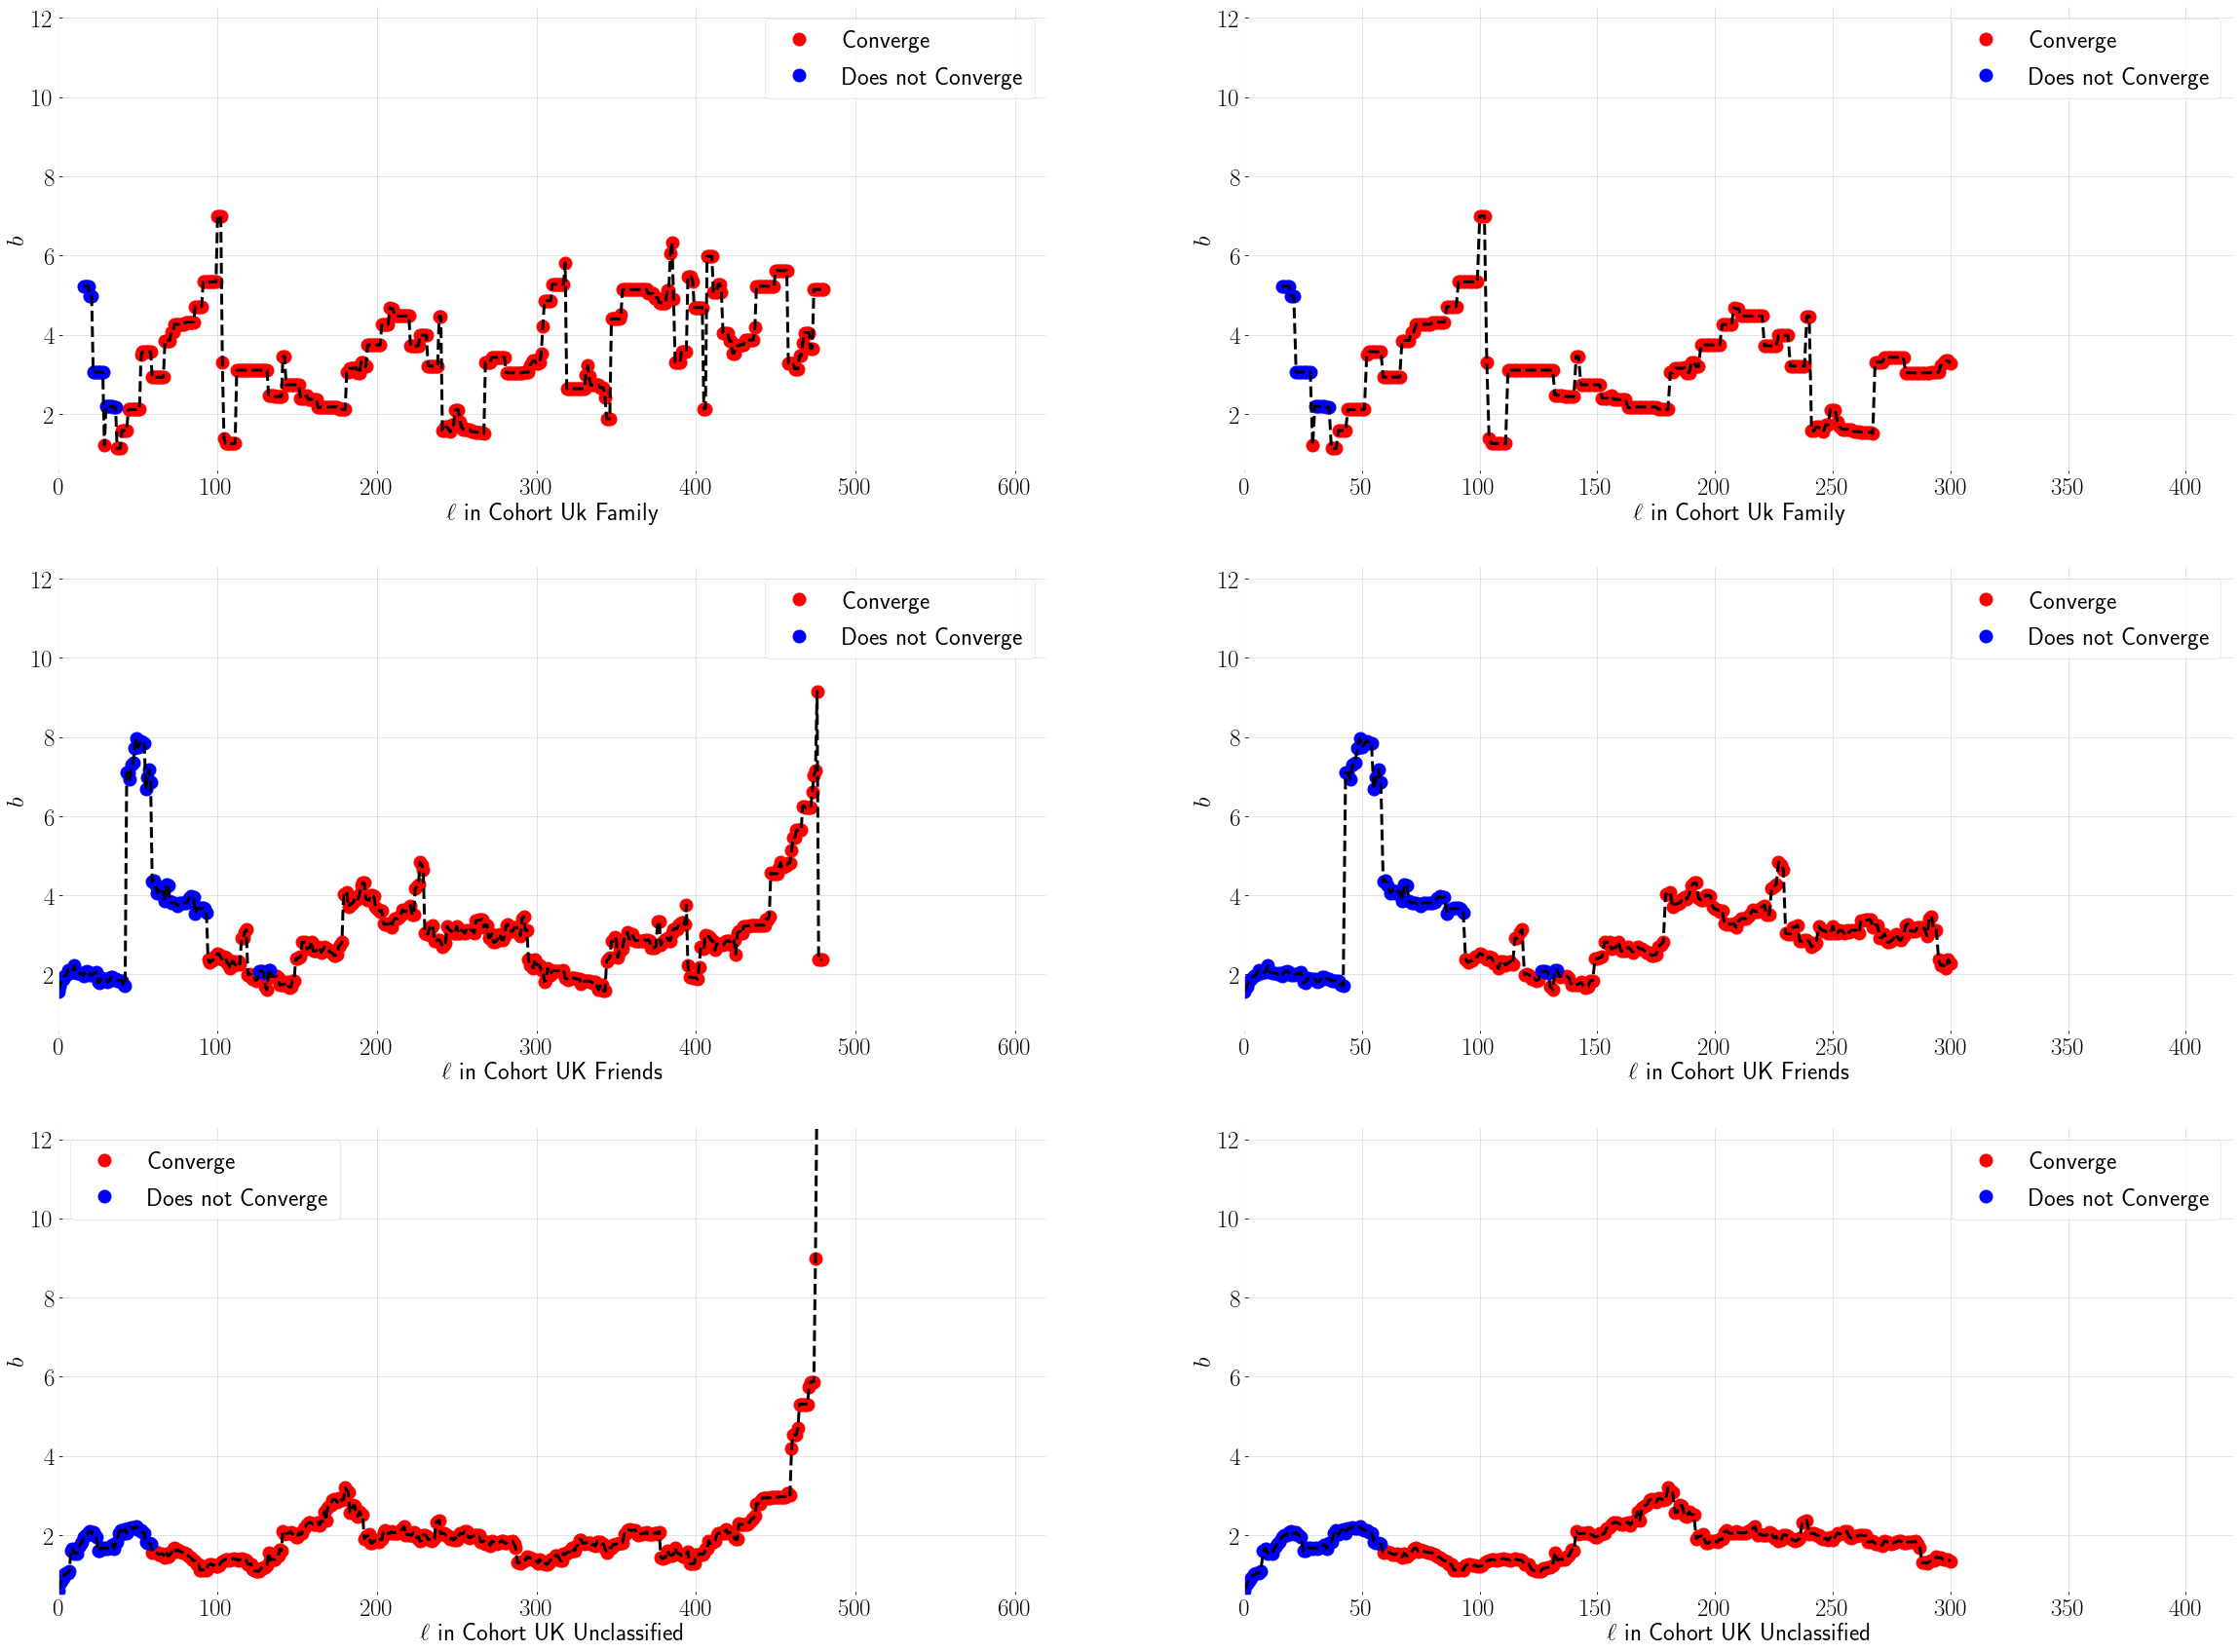

In [86]:
plt.figure(figsize=(20*2, 10*3))
p = 1
cohorts = ['Uk Family', 'UK Friends', 'UK Unclassified']
for c in ukdf.keys():
    plt.subplot(3, 2, p)
    plt.xlabel(fr"$\ell$ in Cohort {cohorts[(p - 1) // 2]}")
    plt.ylabel(r"$b$")
    plt.xlim(0, 620)
    plt.ylim(0.5, 12.3)
    df = fa[c].copy(deep=True)
    df1 = df.loc[df['converge'] == True]
    df2 = df.loc[df['converge'] == False]
    plt.plot(df1.index, df1['b'], marker="o", markersize=13, c="red", ls="", label="Converge")
    plt.plot(df2.index, df2['b'], marker="o", markersize=13, c="blue", ls="", label="Does not Converge")
    plt.plot(df.index, df['b'], marker="", ls="dashed", lw=3, c="black")
    plt.legend()
    p += 1
    
    plt.subplot(3, 2, p)
    plt.xlabel(fr"$\ell$ in Cohort {cohorts[(p - 1) // 2]}")
    plt.ylabel(r"$b$")
    plt.xlim(0, 420)
    plt.ylim(0.5, 12.3)
    df = fa2[c].copy(deep=True)
    df1 = df.loc[df['converge'] == True]
    df2 = df.loc[df['converge'] == False]
    plt.plot(df1.index, df1['b'], marker="o", markersize=13, c="red", ls="", label="Converge")
    plt.plot(df2.index, df2['b'], marker="o", markersize=13, c="blue", ls="", label="Does not Converge")
    plt.plot(df.index, df['b'], marker="", ls="dashed", lw=3, c="black")
    plt.legend()
    p += 1

In [87]:
len(ukcalls.loc[ukcalls['family'] == 1]['eaid'].unique())

78

In [88]:
len(ukcalls.loc[ukcalls['family'] == 0]['eaid'].unique())

435

In [89]:
fa3 = {}
c3 = {}
pfam = {}
t0 = dt.datetime.now()
for c in ['uk', 'uk2']:
    fa3[c] = {}
    c3[c] = {}
    pfam[c] = {}
    for ell in range(maxa[c]):
        curve = pc.get_fal(uk[c], ell, ell + 50, 15)
        if len(curve['f']) > 3:
            points = get_b_slopes(curve['f'], FlagConverge=True)
            fa3[c][ell] = points[1][1]
            c3[c][ell] = points[2]
            df = uk[c].loc[(uk[c]['ell'] >= ell) & (uk[c]['ell'] <= ell + 50)]
            df = df.loc[df['family'] <= 2]
            fam = df.groupby('ea')[['family']].max()
            if 1 in fam['family'].value_counts().index:
                pfam[c][ell] = fam['family'].value_counts()[1] / len(fam)
            else:
                pfam[c][ell] = 0
    fa3[c] = pd.DataFrame.from_dict(fa3[c], orient='index').sort_index().rename({0: 'b'}, axis='columns')
    tmp = pd.DataFrame.from_dict(c3[c], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(pfam[c], orient="index").sort_index().rename({0: 'pfam'}, axis='columns')
    fa3[c] = fa3[c].merge(tmp, left_index=True, right_index=True, how='outer')
    fa3[c] = fa3[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    fa3[c]['ma50'] = fa3[c]['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:01:02.813193


In [90]:
tmp = fa3['uk'].copy(deep=True)

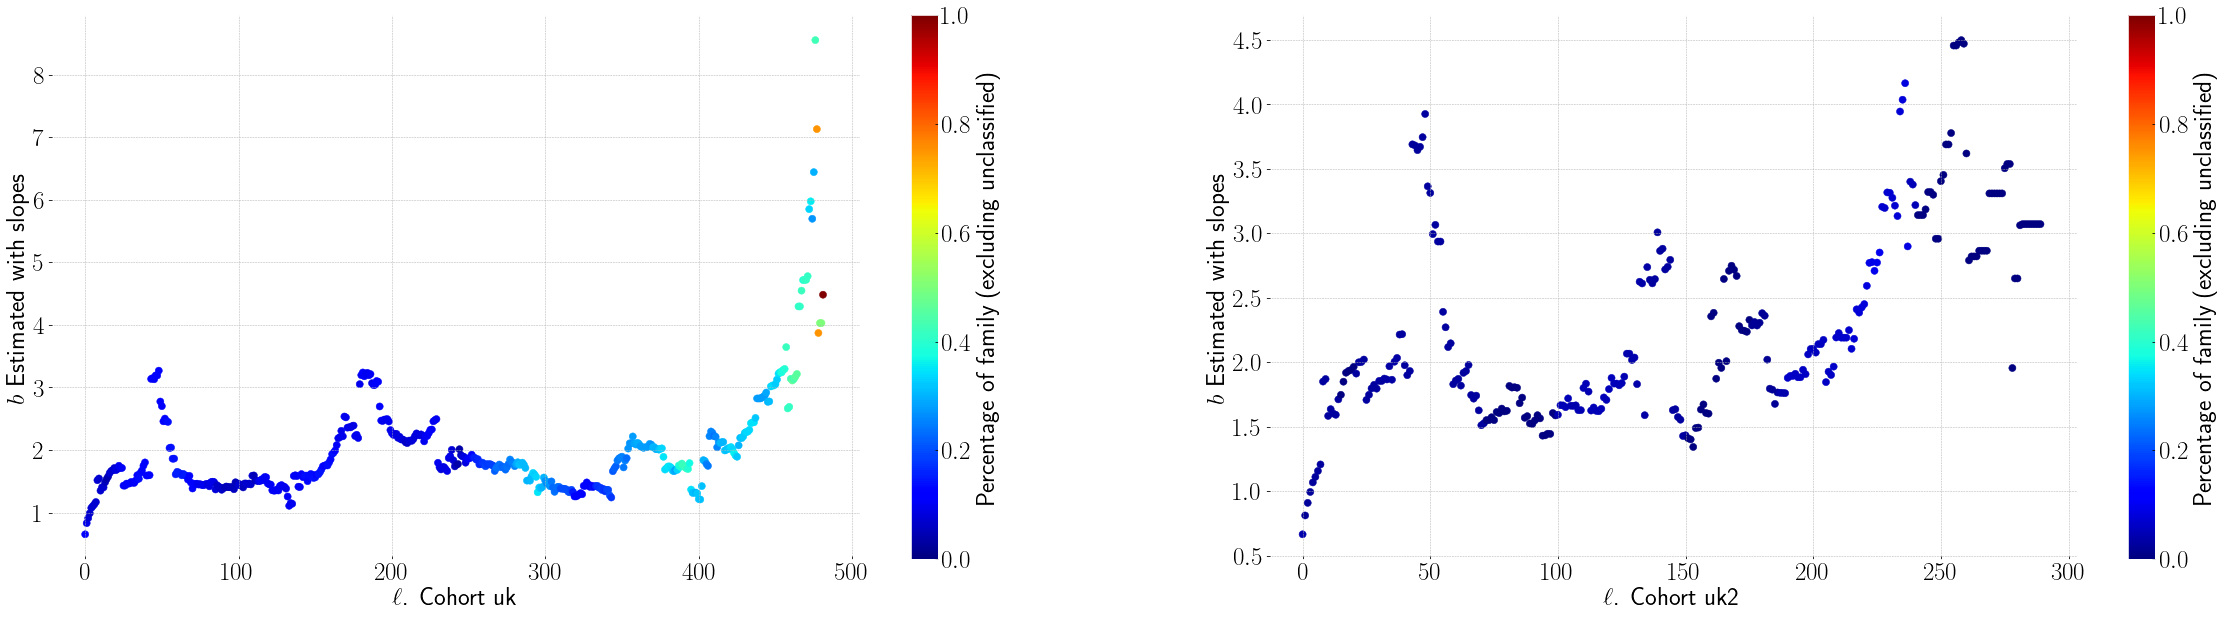

In [91]:
cm = plt.cm.get_cmap('jet')
plt.figure(figsize=(40, 10))
p = 1
for c in fa3.keys():
    plt.subplot(1, 2, p)
    plt.xlabel(fr"$\ell$. Cohort {c}")
    plt.ylabel(r'$b$ Estimated with slopes')
    plt.scatter(fa3[c].index, fa3[c]['b'], c=fa3[c]['pfam'], s=50, vmin=0, vmax=1, cmap=cm)
    plt.colorbar(label="Percentage of family (excluding unclassified)")
    p += 1

## Individual egos and their plateaus

In [92]:
t0 = dt.datetime.now()

# limits = {}
# limits['uk'] = [(0, 50), (100, 160), (220, 280)]
# limits['uk1'] = [(0, 60), (100, 160), (220, 280)]
# limits['uk2'] = [(0, 60), (100, 160), (220, 280)]
# limits['it'] = [(0, 100), (150, 250), (250, 350)]
# limits['mit'] = [(0, 50), (100, 150), (200, 250)]

fig1 = {}
for c in ['uk', 'uk2', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)
        
fig1['it'] = {}
for i in range(3):
    fig1['it'][i] = {}
    fig1['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])
    fig1['it'][i]['fi'] = {}
    for ego in itdffa15[60].keys():
        tmp = {ego: itdffa15[60][ego]}
        fig1['it'][i]['fi'][ego] = pc.get_avgfa(tmp, itlives[60], limits['it'][i][0], limits['it'][i][1])
        
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    for lamb in fig1[c].keys():
        points = get_b_slopes(fig1[c][lamb]['f'])
        dashed[c][lamb] = points[1][1]
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:01.462172


In [93]:
dashed

{'uk': {0: 2.32372083740256, 1: 1.4581887315198958, 2: 2.2256547446074486},
 'uk2': {0: 3.578888888888889, 1: 1.5923360902462018, 2: 2.450963957437888},
 'it': {0: 1.1785400032670363, 1: 0.8991669257367098, 2: 2.5036360856719075},
 'mit': {0: 2.102984419756603, 1: 1.9573264544906632, 2: 4.002288596106485}}

In [94]:
fig1['uk'][0]['fi'].keys()

dict_keys(['C07779270485', 'C07791428359', 'C07792057901', 'C07792058001', 'C07792658311', 'C07792658339', 'C07800643277', 'C07800643415', 'C07800643466', 'C07800650511', 'C07800756002', 'C07800756371', 'C07800759083', 'C07800759255', 'C07805206865', 'C07814508939', 'C07817280467', 'C07855941005', 'C07890818114', 'C07890948782', 'C07896537661', 'C07896556837', 'C07905656488', 'C07970136770', 'C07974937603', 'C07974937643', 'C07999103487'])

In [95]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = {}
        bhist[c][lamb]['converge'] = []
        bhist[c][lamb]['notconverge'] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = get_b_slopes(curve, FlagConverge=True)
                if (b is not None) and (not pd.isna(b[1][1])):
                    if b[2]:
                        bhist[c][lamb]['converge'].append(b[1][1])
                    else:
                        bhist[c][lamb]['notconverge'].append(b[1][1])

In [96]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

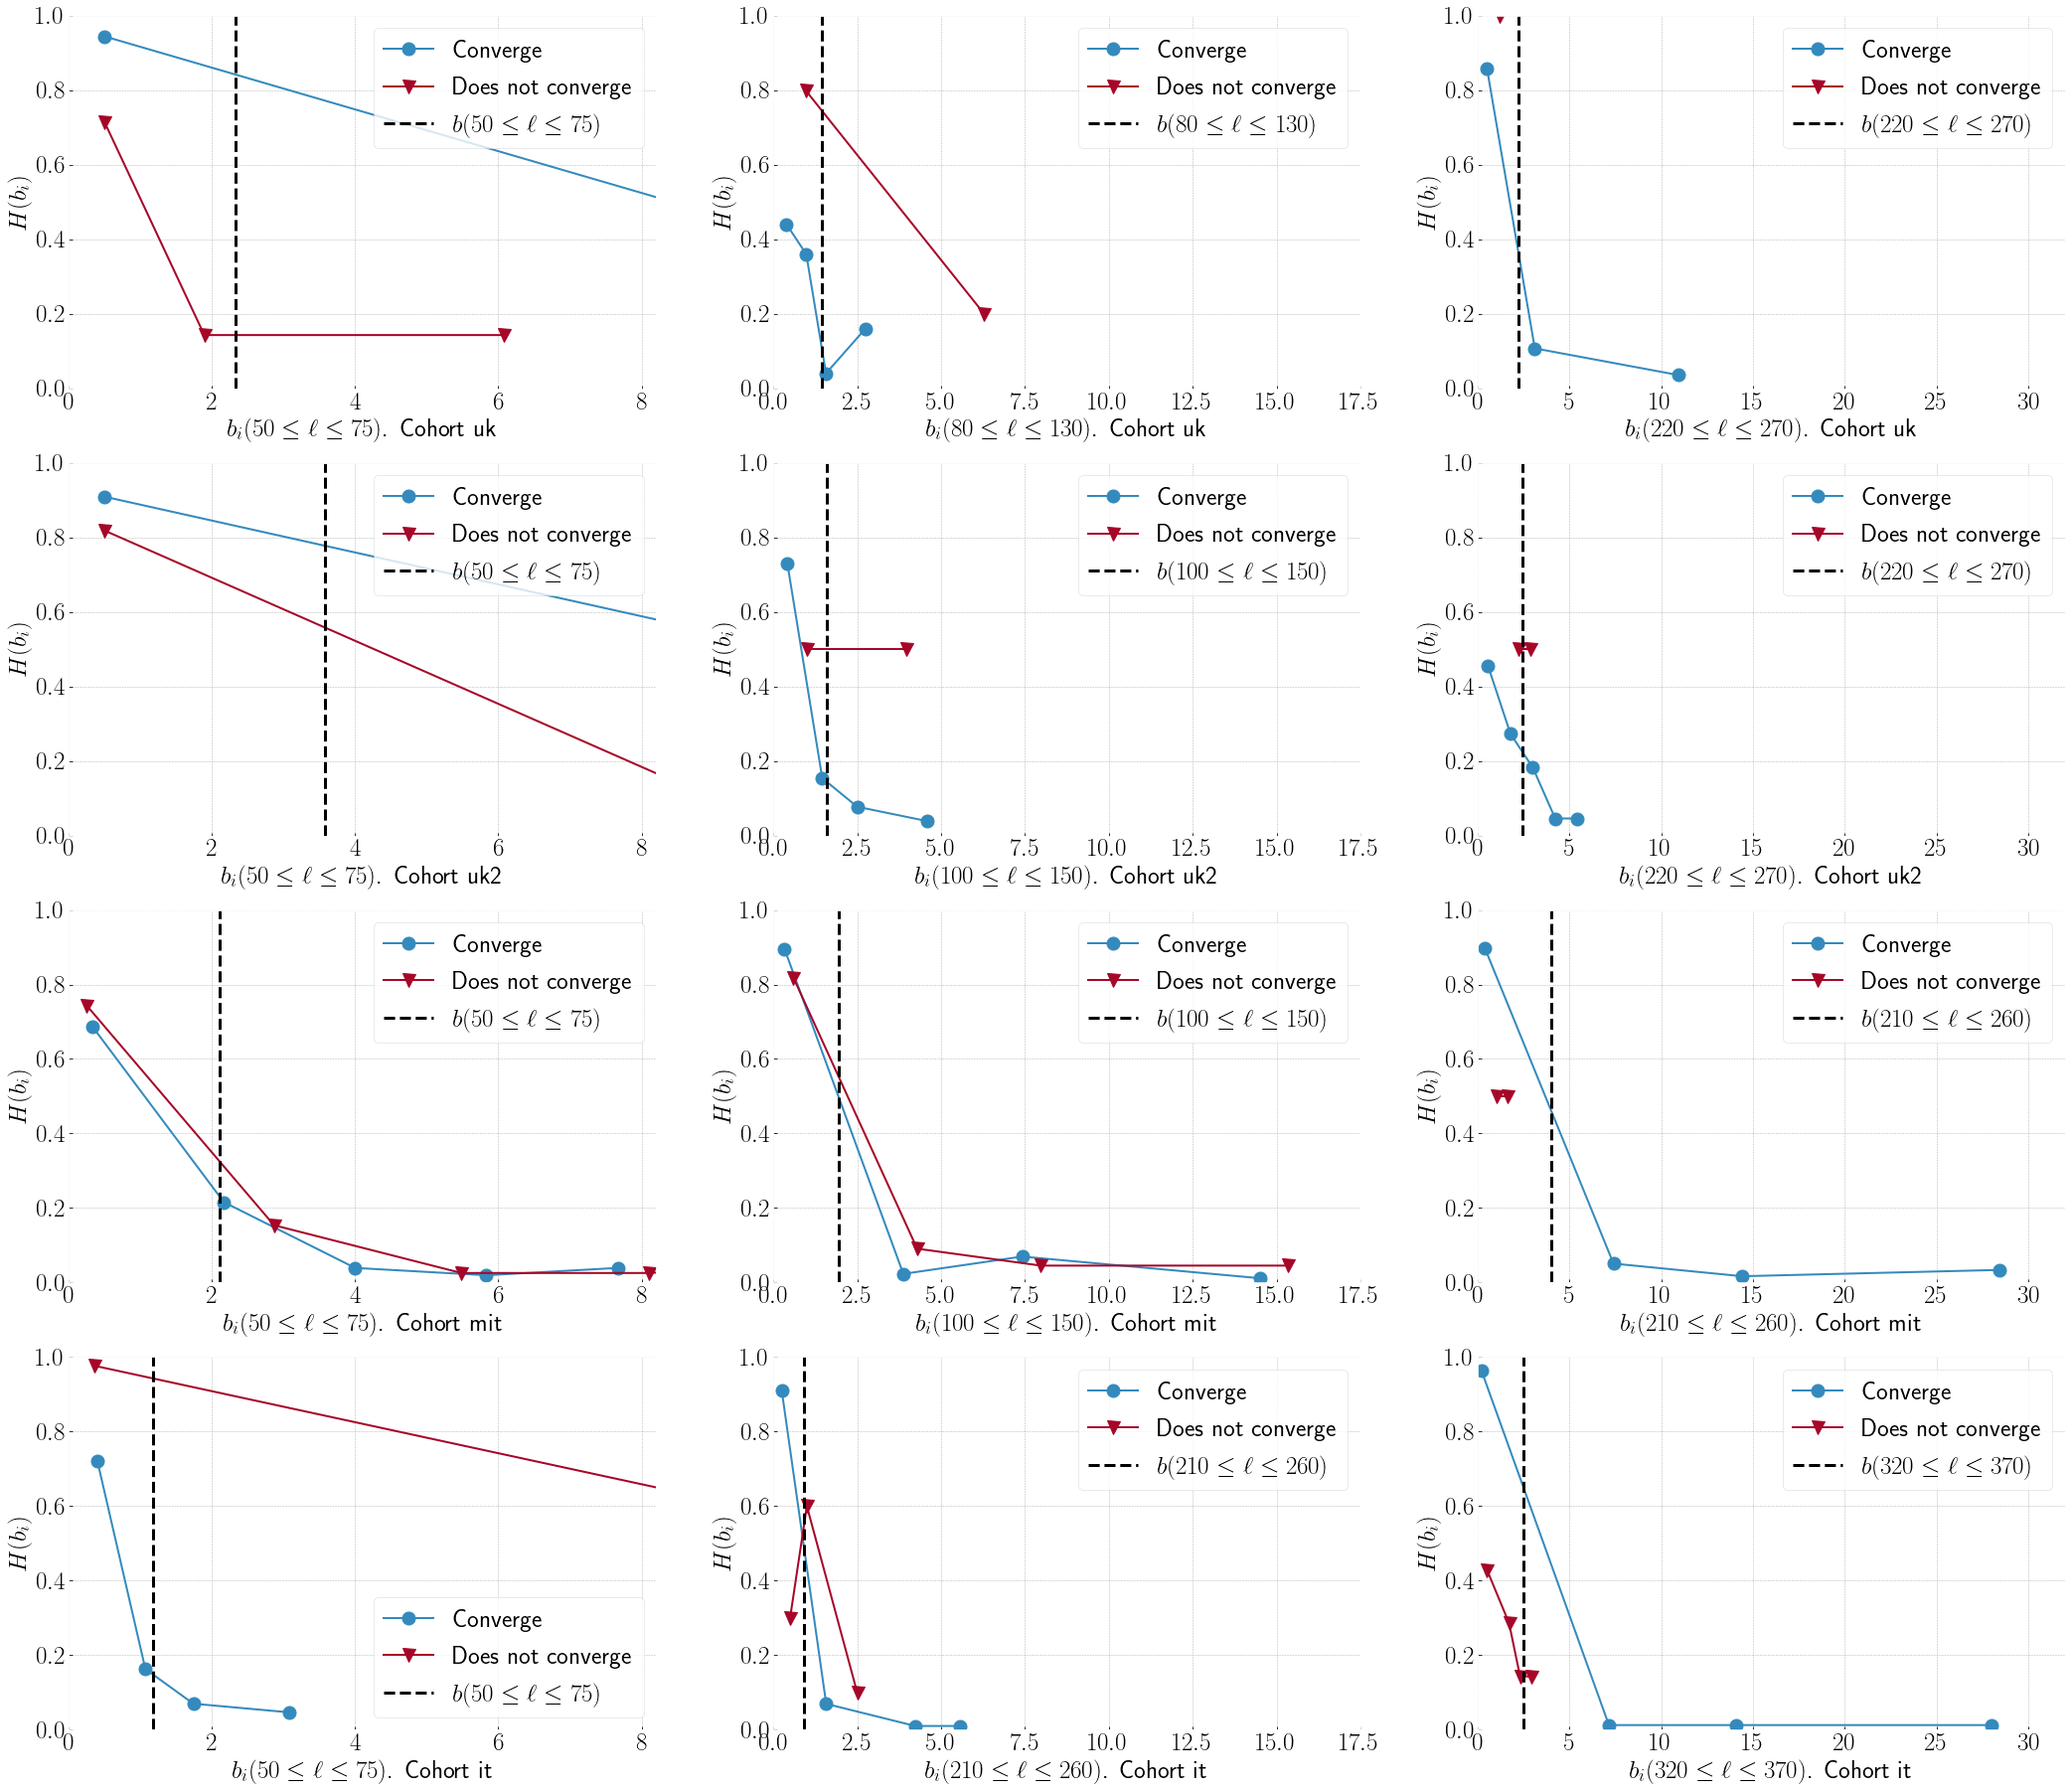

In [97]:
plt.figure(figsize=(12*3, 8*5))
p = 1
for c in fig1.keys():
    for lamb in fig1[c].keys():
        plt.subplot(5, 3, p)
        plt.xlabel(fr'$b_i({limits[c][lamb][0]} \leq \ell \leq {limits[c][lamb][1]})$. Cohort {c}')
        plt.ylabel(r'$H(b_i)$')
        plt.ylim(0, 1)
#         plt.semilogy()
        if lamb == 0:
            plt.xlim(0, 8.2)
        elif lamb == 1:
            plt.xlim(0, 17.5)
        else:
            plt.xlim(0, 32)
        m = 0
        for t in ['converge', 'notconverge']:
            if len(bhist[c][lamb][t]) > 0:
                H = histogram(bhist[c][lamb][t], 5, log=False)
                plt.plot(H['label'], H['pmf'], marker=markers[m], markersize=13, ls="solid", lw=2, label=f'{["Converge", "Does not converge"][m]}')
                m += 1
            else:
                continue
        plt.axvline(dashed[c][lamb], ls="dashed", lw=3, c="black", label=fr'$b({limits[c][lamb][0]} \leq \ell \leq {limits[c][lamb][1]})$')
        plt.legend()
        p += 1

In [98]:
dashed['uk']

{0: 2.32372083740256, 1: 1.4581887315198958, 2: 2.2256547446074486}

In [99]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = get_b_slopes(curve, FlagConverge=True)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])

### Export to TikZ 

In [100]:
for c in bhist.keys():
    for ell in bhist[c].keys():
        print(len(bhist[c][ell]))

25
30
29
22
28
24
90
108
61
86
111
88


In [101]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist.keys():
    for ell in [1, 2]:
        thelist = bhist[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2down.dat", index=False, header=True, sep="\t")

In [102]:
tmp

ukm       ukl      uk2m      uk2l       mitm      mitl       itm  \
0    0.958333  1.197917  0.416667  1.685714   0.666667  3.312500  0.350000   
1    1.350000  4.000000  2.200000  1.250000   0.840000  1.747253  1.666667   
2    1.016667  1.250000  0.952381  2.333333   1.000000  5.371429  5.533333   
3    0.500000  2.538462  1.000000  1.277778   1.166667  4.875000  0.355769   
4    0.515152  1.166667  1.333333  6.653846   1.933333  1.100000  0.281250   
..        ...       ...       ...       ...        ...       ...       ...   
106       NaN       NaN       NaN       NaN  10.500000       NaN  0.625000   
107       NaN       NaN       NaN       NaN   1.333333       NaN  0.625000   
108       NaN       NaN       NaN       NaN        NaN       NaN  1.000000   
109       NaN       NaN       NaN       NaN        NaN       NaN  0.516667   
110       NaN       NaN       NaN       NaN        NaN       NaN  0.540816   

          itl  
0    0.255556  
1    0.400000  
2    0.600000  
3    0.666667  
4    0.333333  
..        ...  
106       NaN  
107       NaN  
108       NaN  
109       NaN  
110       NaN  

[111 rows x 8 columns]

In [103]:
cols = ['ukm', 'uk2m', 'itm', 'mitm', 'ukl', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
a.to_csv("../commpatterns/PNAS_paper/figs/fig2bmdown.dat", index=True, header=True, sep="\t")
b.to_csv("../commpatterns/PNAS_paper/figs/fig2bldown.dat", index=True, header=True, sep="\t")

In [104]:
a

c  pos      mean       sem
idx                               
0     ukm    0  1.472629  1.393692
1    uk2m    3  1.570490  1.192998
2     itm    6  0.844317  0.895238
3    mitm    9  2.005966  3.113534

# One cohort

To replicate fig 1, and calculate $b$ and $b_i$

In [105]:
tmp = {}
allcdff = {}
for c in ['uk', 'it', 'mit']:
    if c == 'it':
        tmp[c] = itdffa15[60]
        allcdff.update(tmp[c])
    else:
        tmp[c] = pc.get_f(calls[c], 'all', 15, 50)
        allcdff.update(tmp[c])

In [106]:
lives = {}
for c in calls.keys():
    lives[c] = pc.lives_dictionary(calls[c])
lives['it'] = itlives[60]

lives['all'] = {}
for c in ['uk', 'mit', 'it']:
    lives['all'].update(lives[c])

In [107]:
lives.keys()

dict_keys(['uk', 'uk2', 'mit', 'uk1', 'it', 'all'])

In [108]:
plats = {}
converge = {}
plats['b'] = {}
converge['b'] = {}
for ell in range(500):
    curve = pc.get_avgfa(allcdff, lives['all'], ell, ell + 50)
    if len(curve) > 3:
        points = get_b_slopes(curve, FlagConverge=True)
        plats['b'][ell] = points[1][1]
        converge['b'][ell] = points[2]
plats['b'] = pd.DataFrame.from_dict(plats['b'], orient='index').sort_index().rename({0: 'b'}, axis='columns')
tmp = pd.DataFrame.from_dict(converge['b'], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
plats['b'] = plats['b'].merge(tmp, left_index=True, right_index=True, how='outer')
plats['b']['ma50'] = plats['b']['b'].rolling(window=50).mean()

In [109]:
plats['bi'] = {}
converge = {}
for ego in allcdff.keys():
    plats['bi'][ego] = {}
    converge[ego] = {}
    tmp = {ego: allcdff[ego]}
    for ell in range(500):
        curve = pc.get_avgfa(tmp, lives['all'], ell, ell + 50)
        if len(curve) > 3:
            points = get_b_slopes(curve, FlagConverge=True)
            plats['bi'][ego][ell] = points[1][1]
            converge[ego][ell] = points[2]
    if len(plats['bi'][ego].keys()) > 0:
        plats['bi'][ego] = pd.DataFrame.from_dict(plats['bi'][ego], orient='index').sort_index().rename({0: 'b'}, axis='columns')
        tmp = pd.DataFrame.from_dict(converge[ego], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
        plats['bi'][ego] = plats['bi'][ego].merge(tmp, left_index=True, right_index=True, how='outer')
        plats['bi'][ego]['ma50'] = plats['bi'][ego]['b'].rolling(window=50).mean()

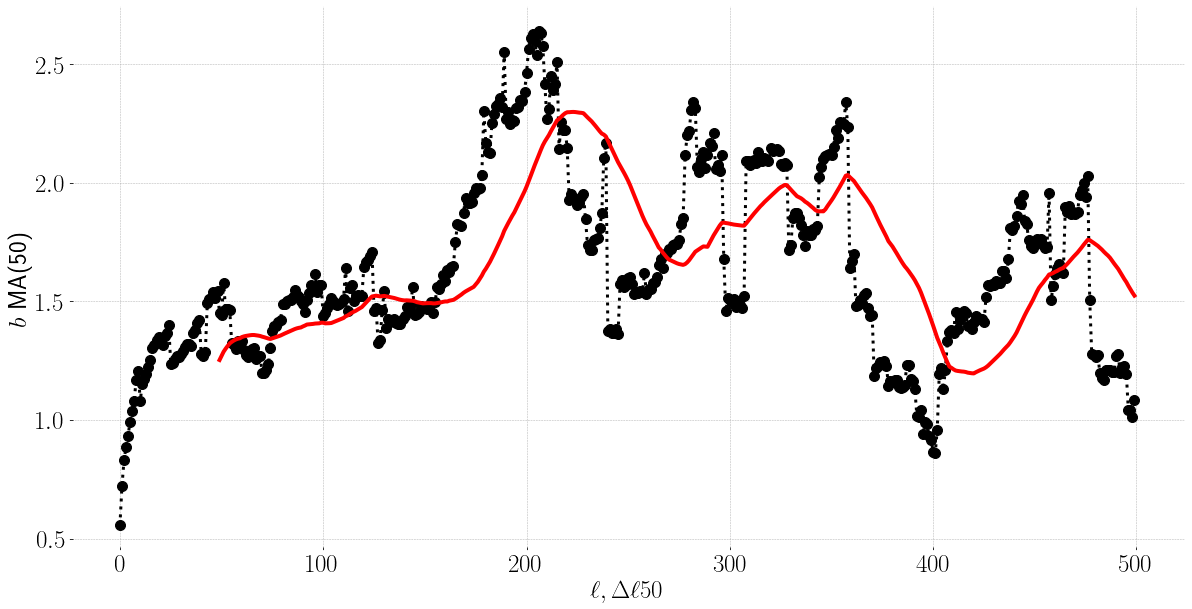

In [110]:
plt.ylabel(r'$b$ MA(50)')
plt.xlabel(r'$\ell, \Delta \ell 50$')
plt.plot(plats['b'].index, plats['b']['b'], marker="o", markersize=10, ls="dotted", lw=3, c="black")
plt.plot(plats['b'].index, plats['b']['ma50'], marker="", markersize=13, ls="solid", lw=4, c="red")

# Trying to scale fig3

The first try involves scaling the horizontal axis by $\frac{\ell}{\tilde{\ell}}$

In [127]:
dff = {}
dff['all'] = {}
for c in calls.keys():
    dff[c] = pc.get_f(calls[c], 'all', 30, 10)
    dff['all'].update(dff[c])
    
dff['it'] = itdffa30[60]
dff['all'].update(dff['it'])

In [128]:
survival = {}
for c in dff.keys():
    survival[c] = pc.get_survival(dff[c], lambdamax=25)

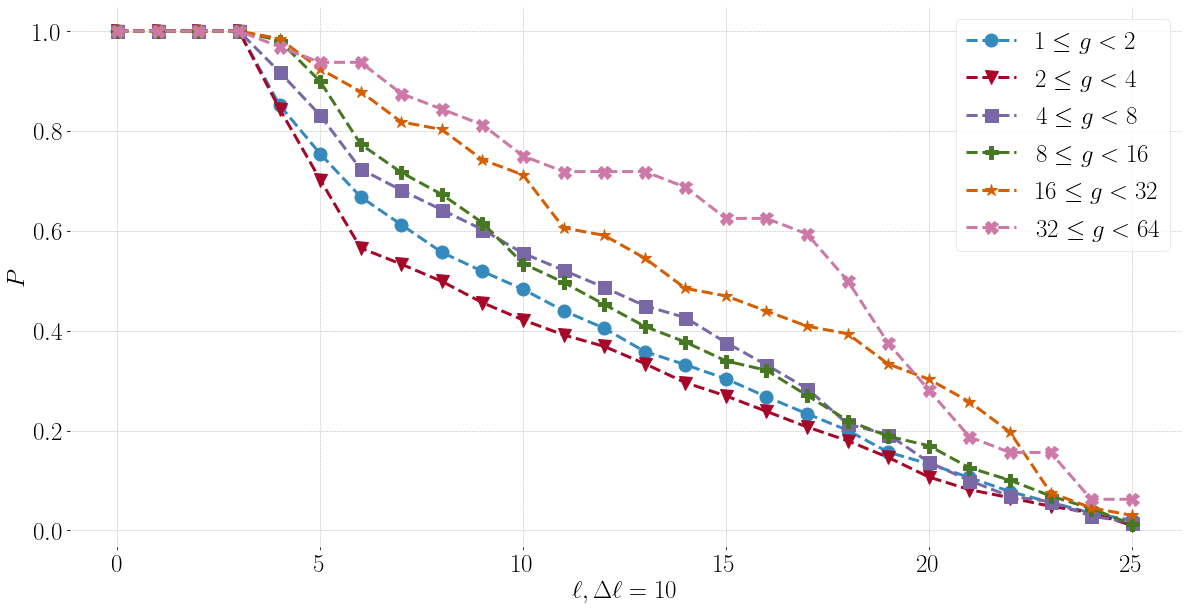

In [129]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

# Mutual Information

In [111]:
def get_month2(dff, lives):
    result = pd.DataFrame()
    idx = 0
    for ego in dff.keys():
        for alter in dff[ego].keys():
            df = dff[ego][alter].loc[dff[ego][alter]['alpha'] == 1]
            if (len(df) > 0) and (ego in lives.keys()):
                result.at[idx, 'ego'] = ego
                result.at[idx, 'alter'] = alter
                result.at[idx, 'F'] = sum(df['f'])
                result.at[idx, 'lambda'] = lives[ego][alter]['ell']
                idx += 1
    return result

In [112]:
alldff = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    if c == 'it':
        alldff[c] = itdffa30[60]
    else:
        alldff[c] = pc.get_f(calls[c], 'all', 30, 10)
    alldff['all'] = alldff.get('all', {})
    alldff['all'].update(alldff[c])

In [113]:
miall = []
for i in ['uk', 'uk2', 'it', 'mit', 'all']:
    miall.append(get_month2(alldff[i], lives[i]))

In [114]:
import sklearn.metrics as sk
miplot = []
for i in miall:
    miplot.append(sk.mutual_info_score(i['F'], i['lambda']))
for i in range(len(miplot)):
    print(['uk', 'uk2', 'it', 'mit', 'all'][i],"\t", miplot[i],"\t", miplot[i]*1.44)

uk 	 1.6147868892901935 	 2.3252931205778786
uk2 	 1.8407683598093174 	 2.650706438125417
it 	 0.8232150164261027 	 1.185429623653588
mit 	 1.0373225591576791 	 1.4937444851870578
all 	 0.7531148502643005 	 1.0844853843805926


In [115]:
entropies = []
for i in miall:
    X = stats.entropy([xx / sum(i["F"]) for xx in i['F']])
    Y = stats.entropy([yy / sum(i['lambda']) for yy in i['lambda']])
    entropies.append(np.mean([X, Y]))
    print(X, Y, np.mean([X, Y]))

5.724442912527049 6.334203824143561 6.029323368335305
4.767516836085946 5.545227261203276 5.156372048644611
6.809541309471975 7.126016628171526 6.967778968821751
6.3074025574415575 7.0075664430367315 6.6574845002391445
7.222617694257568 7.80228682933224 7.512452261794904


In [116]:
for i in range(len(miplot)):
    print(['uk', 'uk2', 'mit', 'it', 'all'][i],"\t", miplot[i],"\t", miplot[i] / entropies[i])

uk 	 1.6147868892901935 	 0.2678222398504454
uk2 	 1.8407683598093174 	 0.3569890501390753
mit 	 0.8232150164261027 	 0.11814597163740229
it 	 1.0373225591576791 	 0.15581298899312757
all 	 0.7531148502643005 	 0.10024887001203564


This removes alters with excesive volume of phone calls to recalculate the mutual information scores. 

In [117]:
alldff['uk']['C07974937643']['C07810890593']

lambda  alpha  f
0       4      0  2
1       4      1  1

In [118]:
t0 = dt.datetime.now()
alldff_sel = {}
for c in alldff.keys():
    alldff_sel[c] = {}
    for ego in alldff[c].keys():
        alldff_sel[c][ego] = {}
        for alter in alldff[c][ego].keys():
            df = alldff[c][ego][alter]
            df1 = df.loc[df['alpha'] == 1]
            if (len(df1) > 0) and (sum(df1['f'] <= 32)):
                alldff_sel[c][ego][alter] = df1
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:05.613103


In [119]:
miall2 = []
for i in ['uk', 'uk2', 'it', 'mit', 'all']:
    miall2.append(get_month2(alldff_sel[i], lives[i]))

In [120]:
miplot2 = []
for i in miall2:
    miplot2.append(sk.mutual_info_score(i['F'], i['lambda']))
for i in range(len(miplot2)):
    print(['uk', 'uk2', 'it', 'mit', 'all'][i],"\t", miplot2[i],"\t", miplot2[i]*1.44)

uk 	 1.5249843177816187 	 2.1959774176055307
uk2 	 1.7516794714000103 	 2.5224184388160147
it 	 0.789715457772193 	 1.1371902591919578
mit 	 0.9080638676530554 	 1.3076119694203996
all 	 0.67123691791543 	 0.9665811617982193


In [121]:
entropies2 = []
for i in miall2:
    X = stats.entropy([xx / sum(i["F"]) for xx in i['F']])
    Y = stats.entropy([yy / sum(i['lambda']) for yy in i['lambda']])
    entropies2.append(np.mean([X, Y]))
    print(X, Y, np.mean([X, Y]))

6.036700393080455 6.313088538097192 6.174894465588824
5.173912960267994 5.520181521202883 5.347047240735439
7.006020013022876 7.118972437869035 7.062496225445955
6.691969440558017 6.977002271192664 6.83448585587534
7.592216831418325 7.782600710364868 7.687408770891596


In [122]:
for i in range(len(miplot2)):
    print(['uk', 'uk2', 'mit', 'it', 'all'][i],"\t", miplot2[i],"\t", miplot2[i] / entropies2[i])

uk 	 1.5249843177816187 	 0.24696524390497412
uk2 	 1.7516794714000103 	 0.32759753047535867
mit 	 0.789715457772193 	 0.11181817767588642
it 	 0.9080638676530554 	 0.1328649860138972
all 	 0.67123691791543 	 0.08731640763752167


# Global Time

In [123]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")

This notebook took 0:21:05.777713


0